This is a record of the initial EDA when the project was first began. As I went through the project I decided that ranking.csv is all based on cumulative averages and is not really needed as these and other rolling averages can be calculated from the games.csv data. I also decided to hold off initially using the individual player stats in games_details.csv. I may add select features from this data later.

# EDA Analysis of Raw NBA DATA

In [58]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#%config InlineBackend.figure_format = 'svg'

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')


## Data
 - games_details.csv .. (each-game player stats for everyone on the roster)
 - games.csv .......... (each-game team stats: final scores, points scored, field-goal & free-throw percentages, etc...)
 - players.csv ........ (index of players' names and teams)
 - ranking.csv ........ (incremental daily record of standings, games played, won, lost, win%, home record, road record)
 - teams.csv .......... (index of team info such as city and arena names and also head coach) 
 
 NOTES 
 - games and ranking will need to be linked by SEASON->SEASON_ID, GAME_DATE_EST->STANDINGSDATE(-1 day), HOME_TEAM_ID->TEAM_ID / VISITOR_TEAM_ID->TEAM_ID
 - games and game_details will need to be linked by GAME_ID->GAME_ID, HOME_TEAM_ID->TEAM_ID / VISITOR_TEAM_ID->TEAM_ID
 - just very basic stats are provided, but the data is there to generate much more, particulary running averages and other agreggates
 - some games during COVID were played in the "Bubble" - not true home arenas. These will need to be flagged at the least.
 - preseason games should be dropped. Post season probably as well.
 
 games.csv
 - 99 games from early 2003 are missing data; they seem fairly evenly distributed among the teams and probably not worth the effort to manually repopulate. Probably drop these.
 - GAME_ID format:
    - 1st digit: 1=pre-season, 2=regular season, >2 = post season,
    - 2nd & 3rd digit: last two digits of season year (eg 103######## represents preseason game in 2003)
 - redundant fields in games.csv: HOME_TEAM_ID / TEAM_ID_home and VISITOR_TEAM_ID / TEAM_ID_away
 - it appears that certain fields can be dropped: 'GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away'
 - some overtime games have as much as 168 points scored by a single team, but data does not indicate if overtime game or not.
 - outlier games may need to be flagged - overtime games, blow-outs, etc...
 - PTS, REB, AST have trended up the last several seasons, but Home win ratio is down
 - Strongest postive correlations: FG_PCT and AST to PTS.
 - Strongest negative correlation: REB_PCT_away to FG_PCT_home 
 - Strongest correlations to winning (in order): FG_PCT, PTS, FG3_PCT, AST, REB, FT_PCT (same ordering for either home or away)
 - When limiting winning correlations to just 2021 season or to just the last 5 seasons, then FG_PCT and PTS are reversed for away teams as is AST_away and REB_away (PTS, FG_PCT, FG3_PCT, REB, AST, FT_PCT for away teams).
 
 ranking.csv
 - this is primarily just supplemental data that needs to be integrated with the games data
 - RETURNTOPLAY field only used for a small portion of ranking stats (East conference March 2020 thru Dec 2020)
 - LEAGUE_ID always 0, can drop
 - SEASON_ID beginning with 1 appears to be preseason standings, while regular season standings start with a 2
 - My initial plan is to focus just on regular season games, so preseason standings can be removed from the updated dataset
 - Fields to be dropped: 'LEAGUE_ID', 'RETURNTOPLAY', 'TEAM'
 - HOME_RECORD and ROAD_RECORD each needs to be split into games won, games lost, and win percentage
 - There appears to be several duplicate rows that pandas failed to find. These were discovered when later merging games.csv and ranking.csv
 
 games_details.csv
 - this contains all individual players stats for each game
 - 105603 records have NaN for all stats - the player did not play that game
 - TEAM_ABBREVIATION, TEAM_CITY, PLAYER_NAME, NICKNAME are not needed and can be found in index tables if needed
 - COMMENT field will denote why player did not play, usually in a "XXX -" format (e.g. DNP - Injury/Illness) , but 1121 records do not follow the format
 - START_POSITION is null for both players that played but did not start and for players that did not play - maybe separate these two
 - MIN (minutes played) contains mixed formats: integers and MIN:SEC
 - MIN contains 12 records with negative values
 - 19 records have players over 60 minutes and seem to be overtime games
 - several other outlier stats have been verified as correct
  

## games.csv

In [59]:
TARGET = 'HOME_TEAM_WINS'
games = pd.read_csv(DATAPATH / "games_old.csv")
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-03-12,22101005,Final,1610612748,1610612750,2021,1610612748,104.0,0.398,0.760,0.333,23.0,53.0,1610612750,113.0,0.422,0.875,0.357,21.0,46.0,0
1,2022-03-12,22101006,Final,1610612741,1610612739,2021,1610612741,101.0,0.443,0.933,0.429,20.0,46.0,1610612739,91.0,0.419,0.824,0.208,19.0,40.0,1
2,2022-03-12,22101007,Final,1610612759,1610612754,2021,1610612759,108.0,0.412,0.813,0.324,28.0,52.0,1610612754,119.0,0.489,1.000,0.389,23.0,47.0,0
3,2022-03-12,22101008,Final,1610612744,1610612749,2021,1610612744,122.0,0.484,0.933,0.400,33.0,55.0,1610612749,109.0,0.413,0.696,0.386,27.0,39.0,1
4,2022-03-12,22101009,Final,1610612743,1610612761,2021,1610612743,115.0,0.551,0.750,0.407,32.0,39.0,1610612761,127.0,0.471,0.760,0.387,28.0,50.0,0


In [60]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25796 entries, 0 to 25795
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     25796 non-null  object 
 1   GAME_ID           25796 non-null  int64  
 2   GAME_STATUS_TEXT  25796 non-null  object 
 3   HOME_TEAM_ID      25796 non-null  int64  
 4   VISITOR_TEAM_ID   25796 non-null  int64  
 5   SEASON            25796 non-null  int64  
 6   TEAM_ID_home      25796 non-null  int64  
 7   PTS_home          25697 non-null  float64
 8   FG_PCT_home       25697 non-null  float64
 9   FT_PCT_home       25697 non-null  float64
 10  FG3_PCT_home      25697 non-null  float64
 11  AST_home          25697 non-null  float64
 12  REB_home          25697 non-null  float64
 13  TEAM_ID_away      25796 non-null  int64  
 14  PTS_away          25697 non-null  float64
 15  FG_PCT_away       25697 non-null  float64
 16  FT_PCT_away       25697 non-null  float6

###
### Check for duplicates and nulls

In [61]:
# duplicates
games.duplicated().sum()

0

In [62]:
#null values
games.isnull().sum()

GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_home         0
PTS_home            99
FG_PCT_home         99
FT_PCT_home         99
FG3_PCT_home        99
AST_home            99
REB_home            99
TEAM_ID_away         0
PTS_away            99
FG_PCT_away         99
FT_PCT_away         99
FG3_PCT_away        99
AST_away            99
REB_away            99
HOME_TEAM_WINS       0
dtype: int64

In [63]:
#show the nulls
games[games.isna().any(axis=1)]

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
18320,2003-10-24,10300116,Final,1610612753,1610612762,2003,1610612753,NaN,NaN,NaN,NaN,NaN,NaN,1610612762,NaN,NaN,NaN,NaN,NaN,NaN,0
18321,2003-10-24,10300108,Final,1610612737,1610612764,2003,1610612737,NaN,NaN,NaN,NaN,NaN,NaN,1610612764,NaN,NaN,NaN,NaN,NaN,NaN,0
18322,2003-10-24,10300109,Final,1610612738,1610612751,2003,1610612738,NaN,NaN,NaN,NaN,NaN,NaN,1610612751,NaN,NaN,NaN,NaN,NaN,NaN,0
18323,2003-10-24,10300113,Final,1610612759,1610612745,2003,1610612759,NaN,NaN,NaN,NaN,NaN,NaN,1610612745,NaN,NaN,NaN,NaN,NaN,NaN,0
18324,2003-10-24,10300112,Final,1610612749,1610612765,2003,1610612749,NaN,NaN,NaN,NaN,NaN,NaN,1610612765,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18414,2003-10-09,10300019,Final,1610612743,1610612756,2003,1610612743,NaN,NaN,NaN,NaN,NaN,NaN,1610612756,NaN,NaN,NaN,NaN,NaN,NaN,0
18415,2003-10-09,10300022,Final,1610612757,1610612758,2003,1610612757,NaN,NaN,NaN,NaN,NaN,NaN,1610612758,NaN,NaN,NaN,NaN,NaN,NaN,0
18416,2003-10-08,10300013,Final,1610612759,1610612763,2003,1610612759,NaN,NaN,NaN,NaN,NaN,NaN,1610612763,NaN,NaN,NaN,NaN,NaN,NaN,0
18423,2003-10-08,10300015,Final,1610612747,1610612744,2003,1610612747,NaN,NaN,NaN,NaN,NaN,NaN,1610612744,NaN,NaN,NaN,NaN,NaN,NaN,0


NOTE - 99 games from the early part of 2003 season missing data. 

NOTE - GAME_ID format: 

- 1st digit: 1=pre-season, 2=regular season, >2 = post season,  
- 2nd & 3rd digit: last two digits of season year (eg 103######## represents preseason game in 2003)

###
### Check distribution of missing games
Make sure these are fairly evenly distributed in case we decide to just delete them.

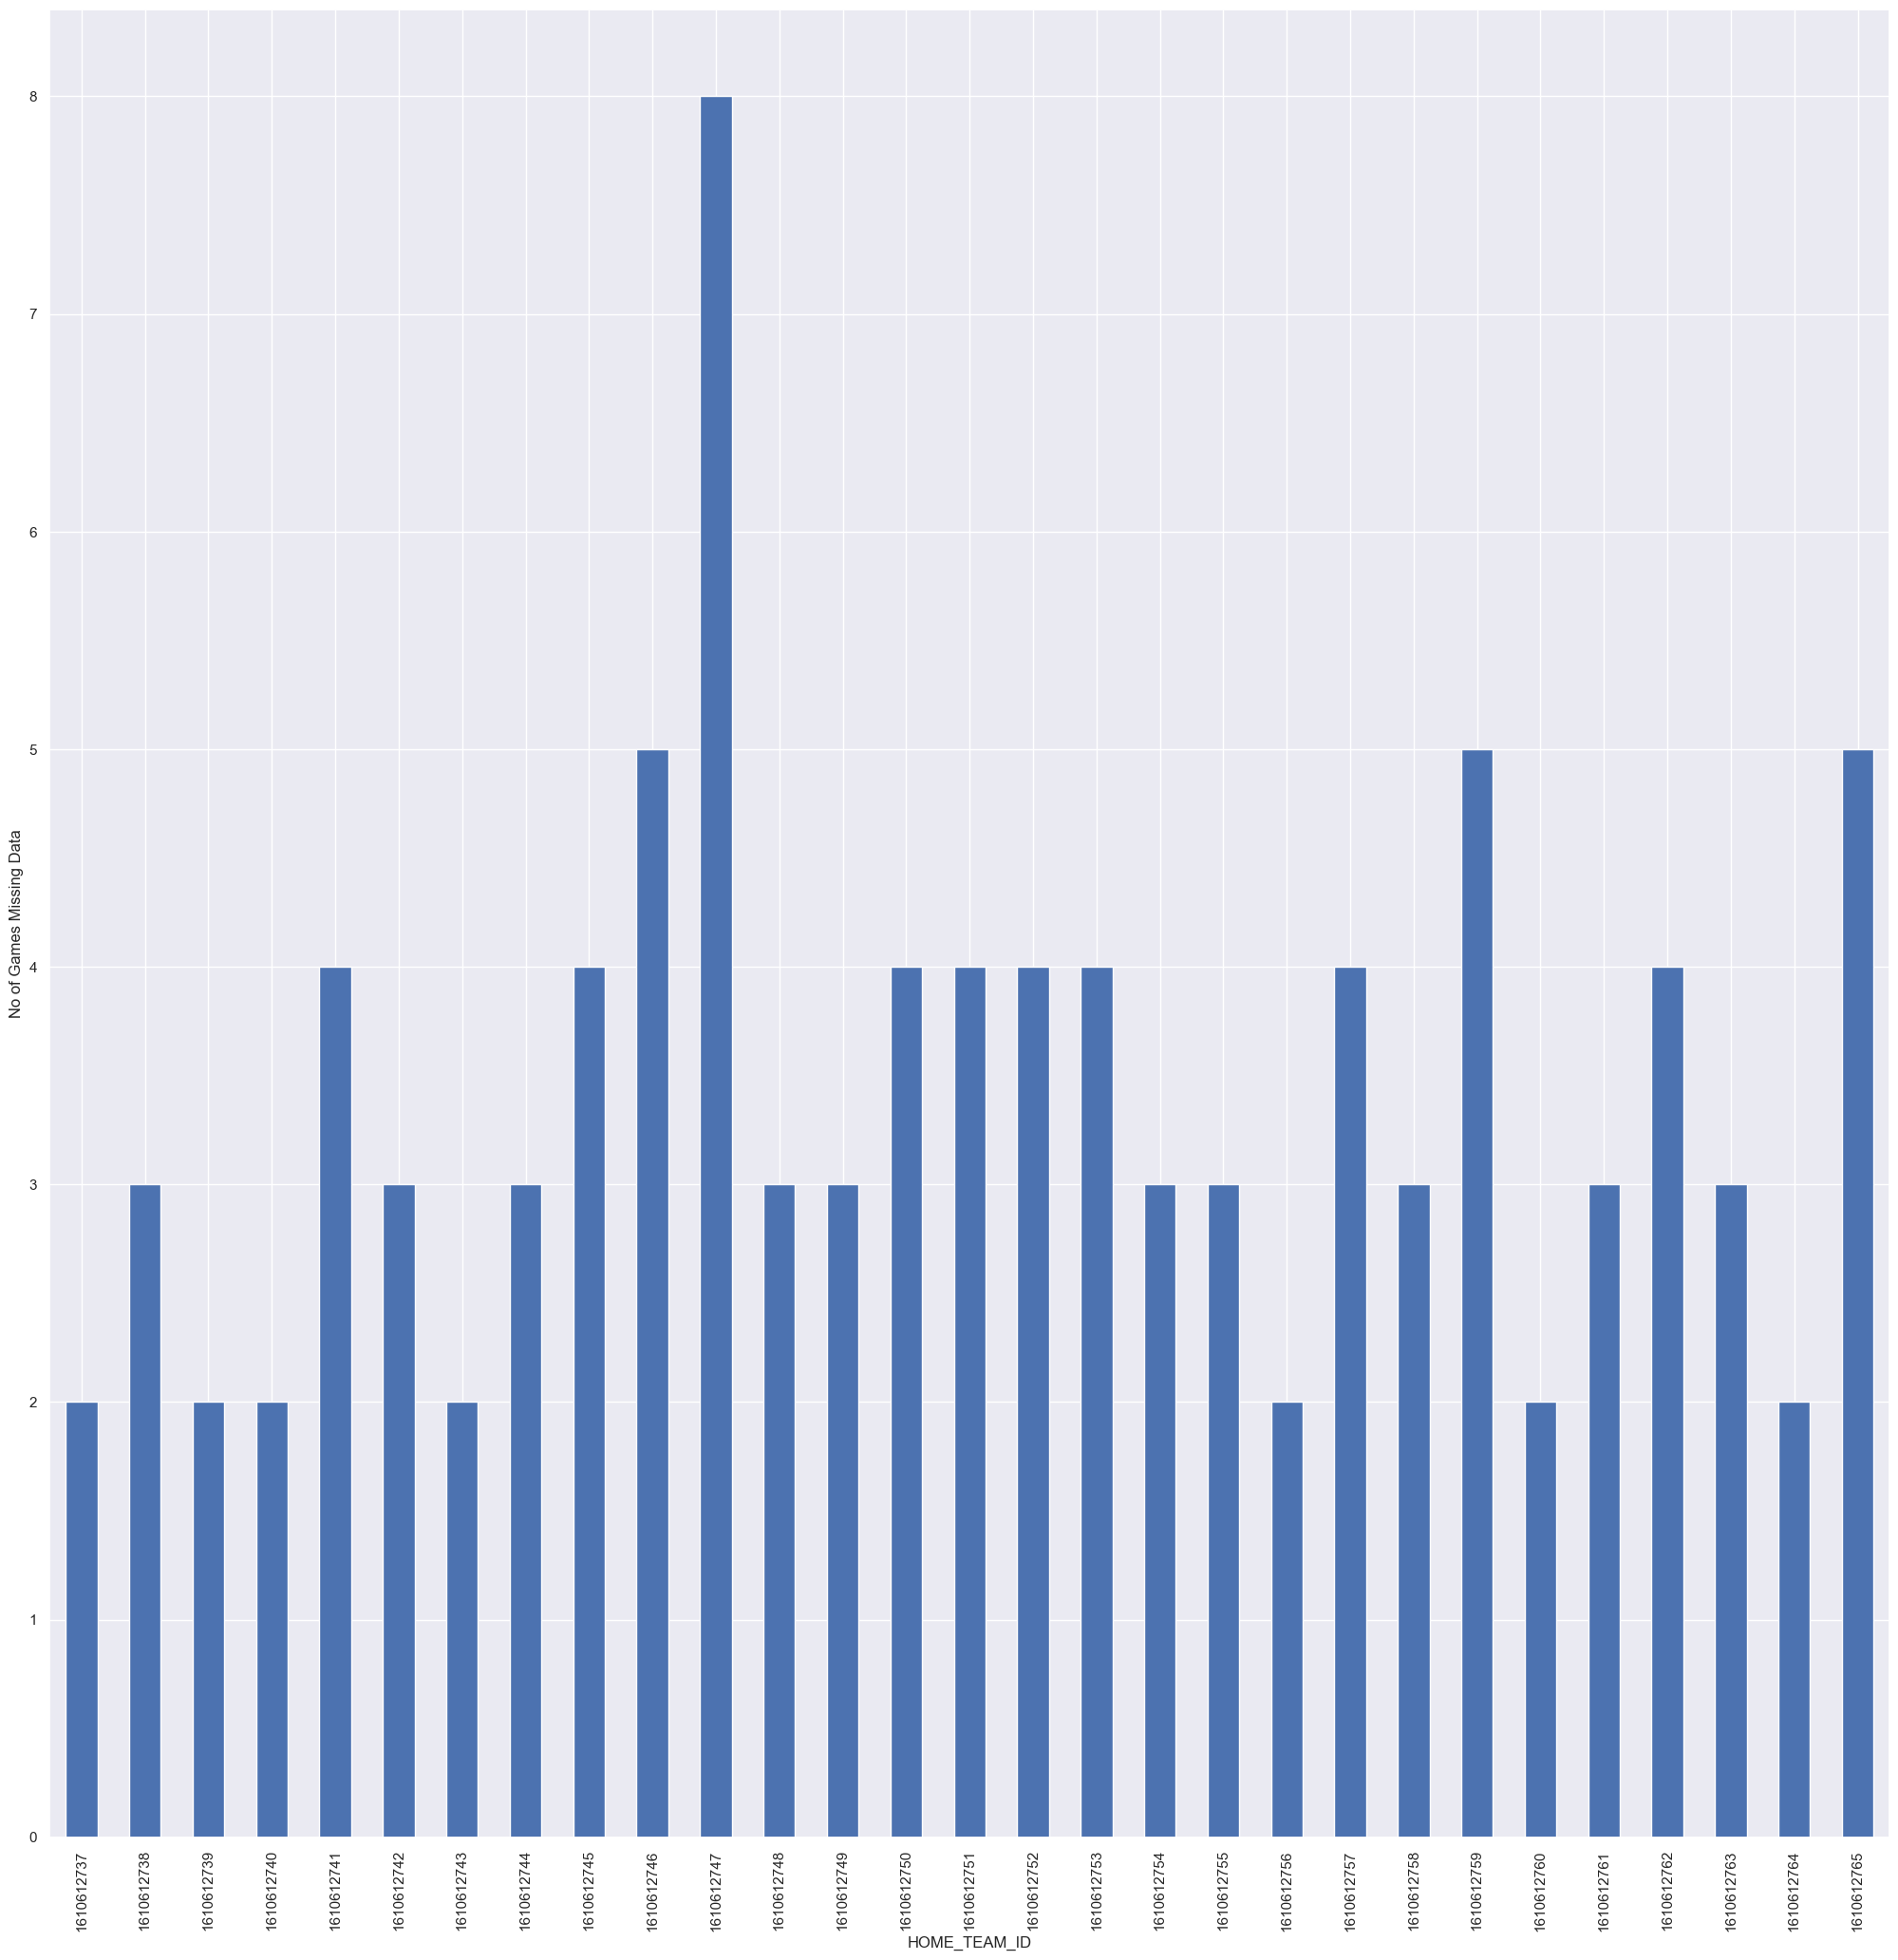

In [64]:
# check distribution of missing games 
df_home = games[games.isna().any(axis=1)].groupby(['HOME_TEAM_ID'])['HOME_TEAM_ID'].count()
ax = df_home.plot.bar(x='HOME_TEAM_ID', y='count', rot=90, ylabel="No of Games Missing Data")

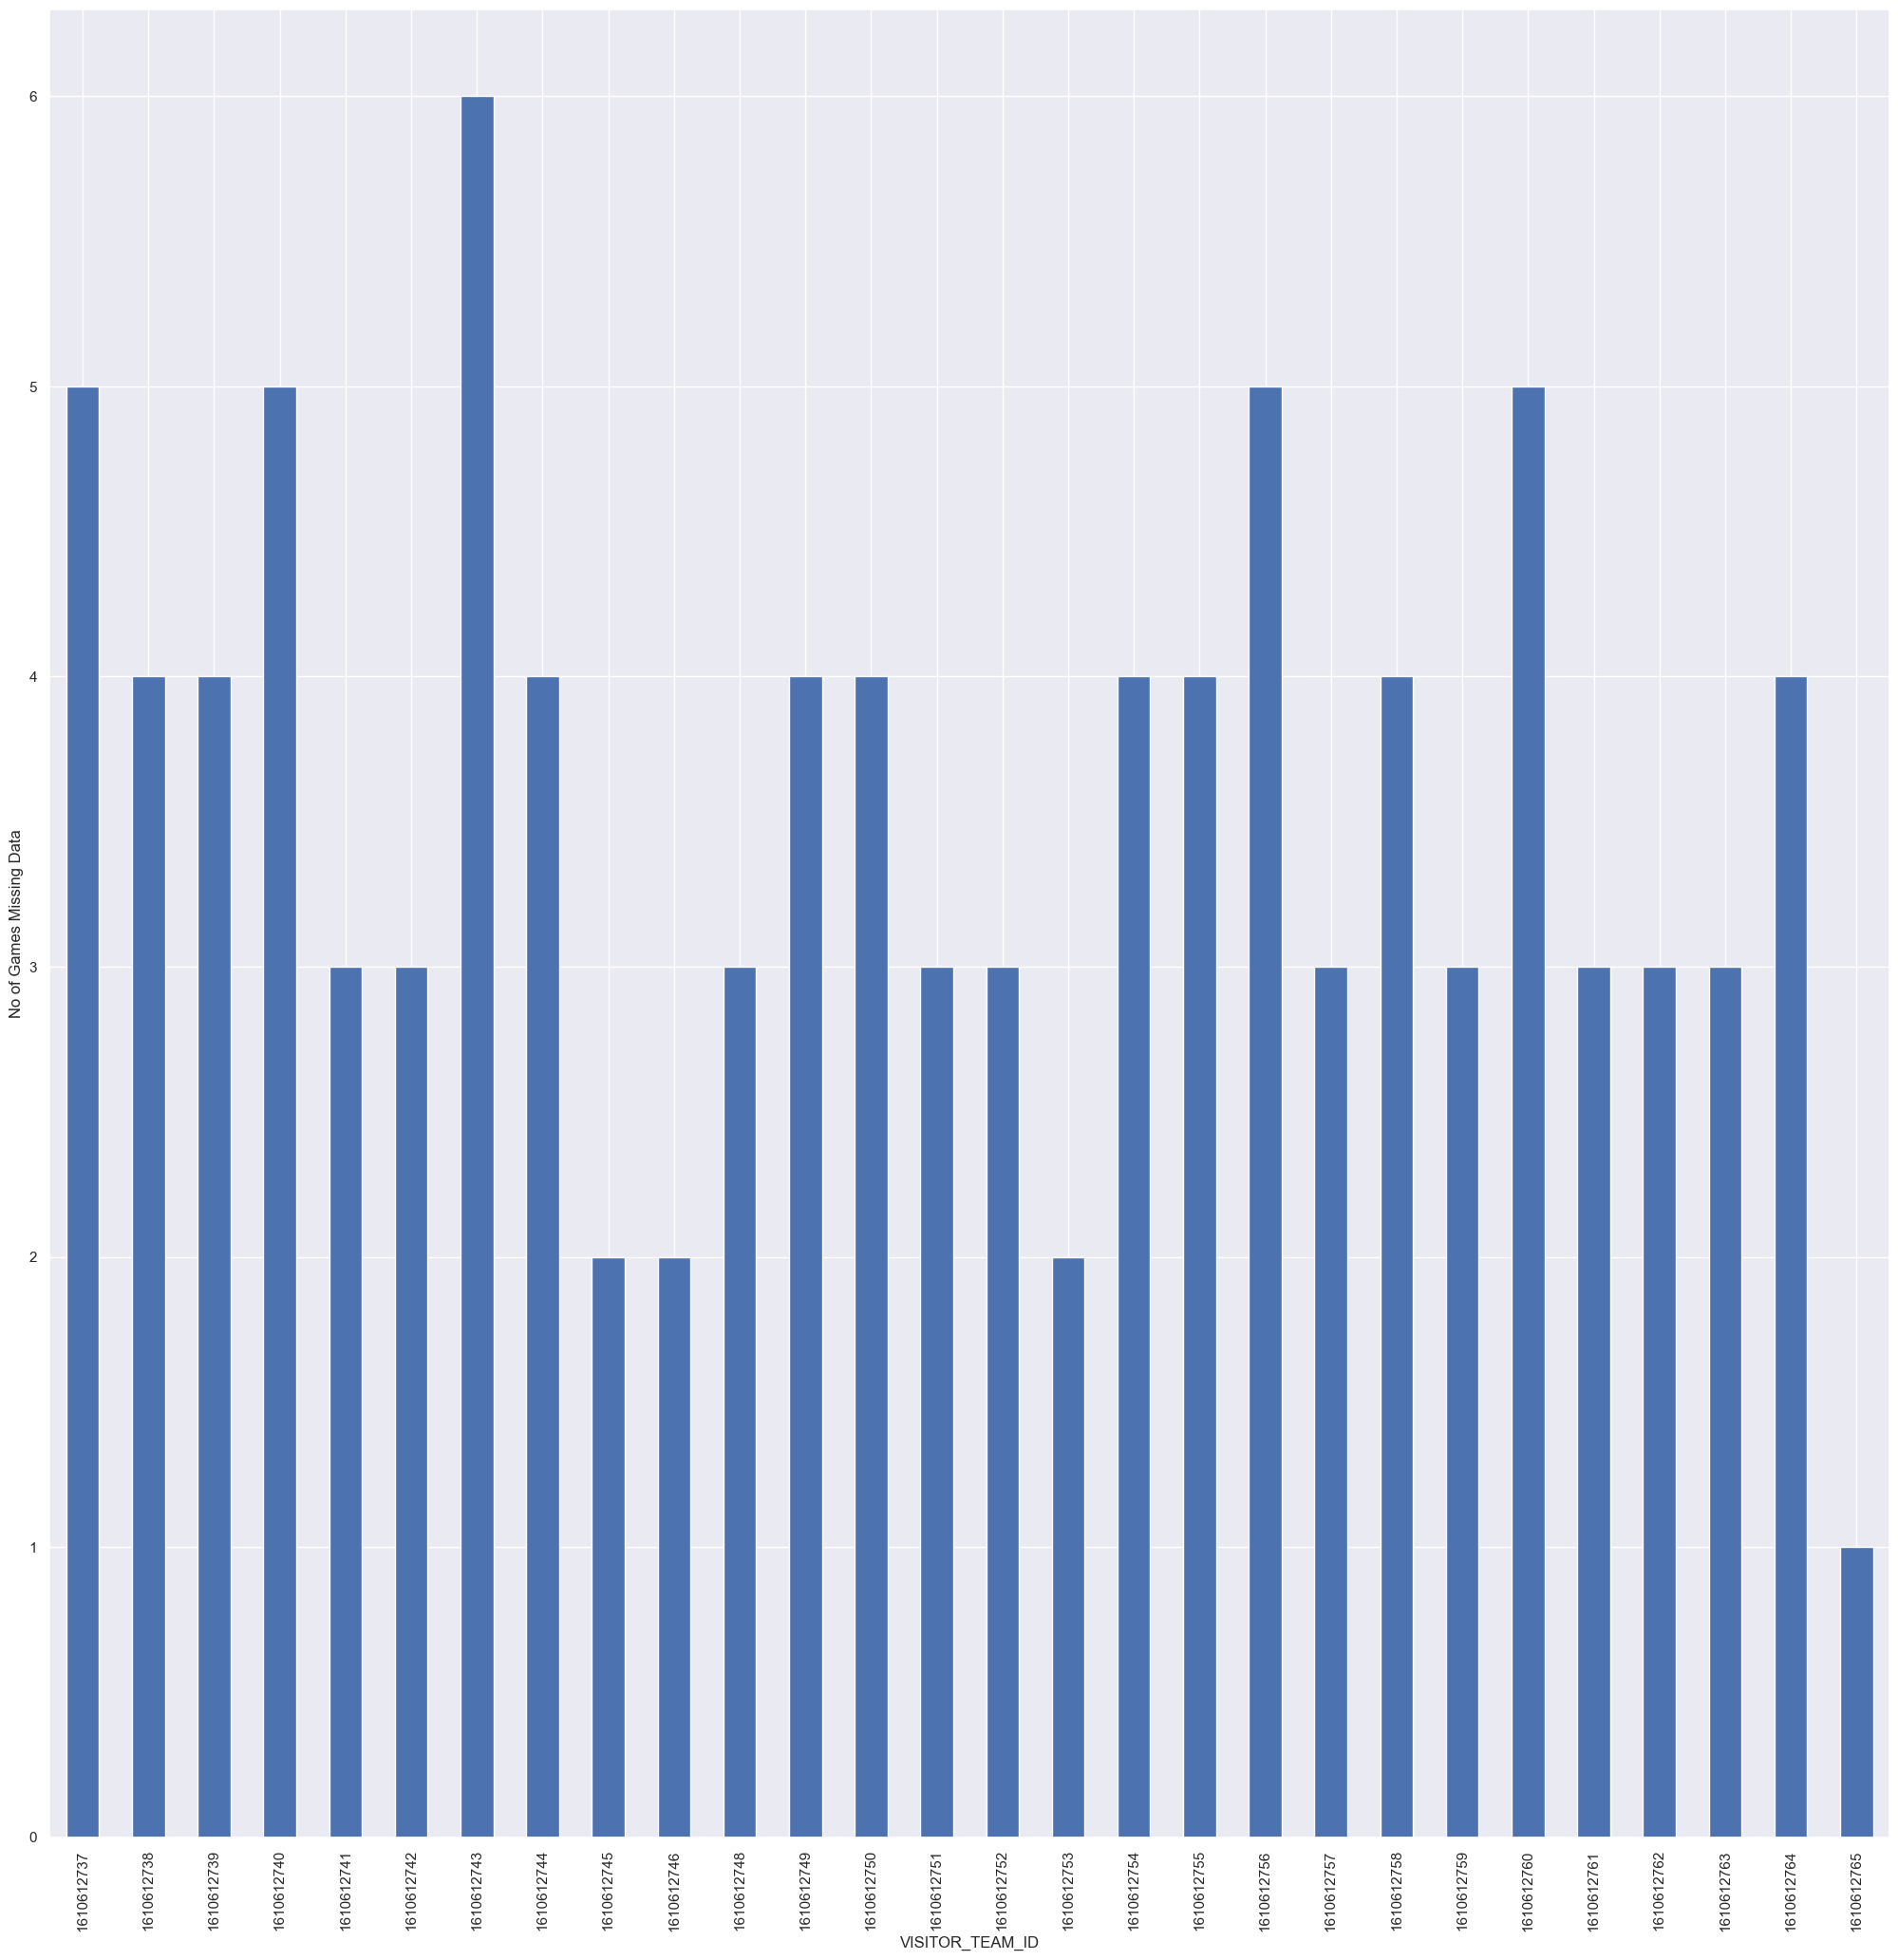

In [65]:
# check distribution of missing games 
df_visitor = games[games.isna().any(axis=1)].groupby(['VISITOR_TEAM_ID'])['VISITOR_TEAM_ID'].count()
ax = df_visitor.plot.bar(x='VISITOR_TEAM_ID', y='count', rot=90, ylabel="No of Games Missing Data")

<AxesSubplot: ylabel='No of Games Missing Data'>

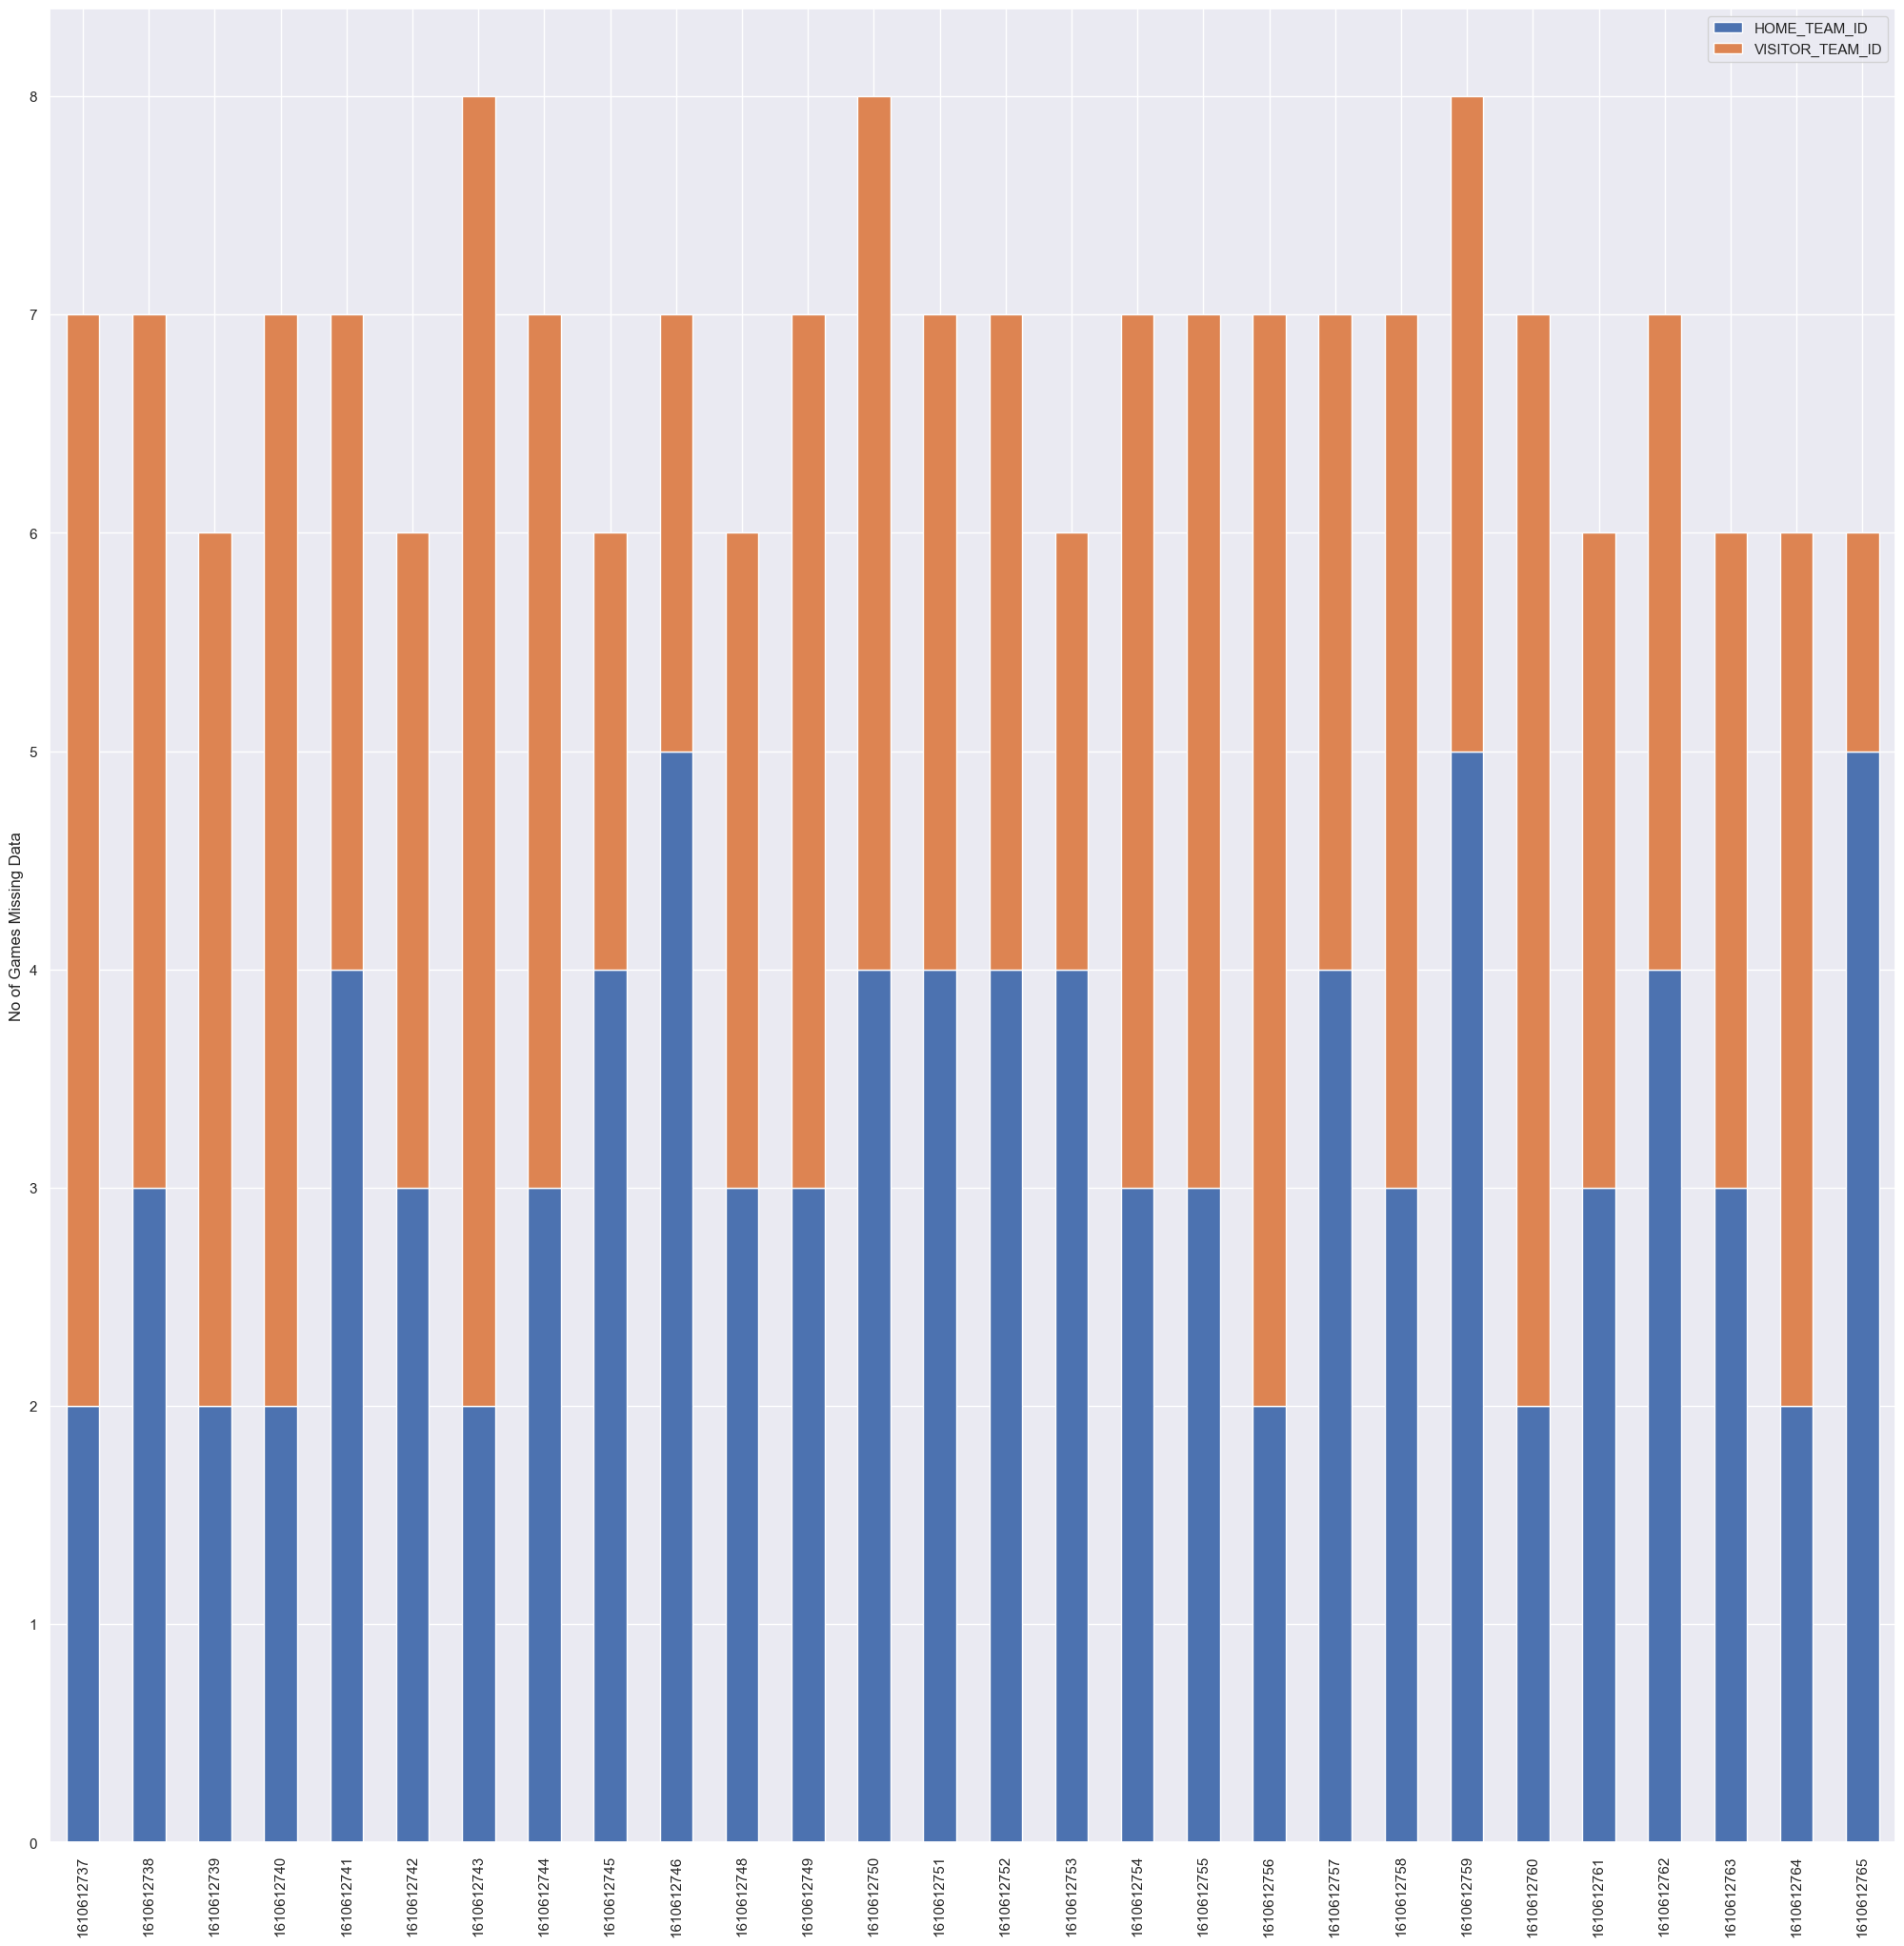

In [66]:
df = pd.merge(df_home, df_visitor, right_index = True, left_index = True)
df.plot.bar(stacked = True, ylabel="No of Games Missing Data")

###
### Verify okay to drop certain fields
 - Confirm that GAMES_STATUS_TEXT always = "Final"
 - Confirm that HOME_TEAM_ID always = TEAM_ID-home
 - Confirm that VISITOR_TEAM_ID always = TEAM_ID-away

In [67]:
#count all games not Final

games[games['GAME_STATUS_TEXT'] != 'Final'].shape[0]

0

NOTE - All games in dataset are Final. This field is not needed for modeling.

In [68]:
#check if fields are redundant

games[games['HOME_TEAM_ID'] != games['TEAM_ID_home']].shape[0]

0

In [69]:
#check if fields are redundant

games[games['VISITOR_TEAM_ID'] != games['TEAM_ID_away']].shape[0]

0

NOTE - for some reason Home and Visitor teams IDs are included twice, but are always the same

In [70]:
#these fields not needed for processing, analysis, or modeling

drop_fields = ['GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away']

games = games.drop(drop_fields,axis=1)

###
### Describe the data


In [71]:
# fix data types first

games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'])

category_fields = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

for cat in category_fields:
    games[cat] = games[cat].astype('category')

In [72]:
games.describe(include = 'category').T

,count,unique,top,freq
HOME_TEAM_ID,25796,30,1610612747,945
VISITOR_TEAM_ID,25796,30,1610612748,908
SEASON,25796,19,2005,1432


30 NBA teams and 19 seasons 

In [73]:
games.describe().T.applymap('{:,.4f}'.format)

,count,mean,std,min,25%,50%,75%,max
GAME_ID,"25,796.0000","21,692,079.3182","5,496,041.0508","10,300,001.0000","20,601,091.7500","21,200,400.5000","21,700,700.2500","52,000,211.0000"
PTS_home,"25,697.0000",103.1060,13.1747,36.0000,94.0000,103.0000,112.0000,168.0000
FG_PCT_home,"25,697.0000",0.4603,0.0566,0.2500,0.4210,0.4590,0.5000,0.6840
FT_PCT_home,"25,697.0000",0.7597,0.1007,0.1430,0.6960,0.7650,0.8290,1.0000
FG3_PCT_home,"25,697.0000",0.3559,0.1119,0.0000,0.2860,0.3550,0.4290,1.0000
AST_home,"25,697.0000",22.7368,5.1776,6.0000,19.0000,23.0000,26.0000,50.0000
REB_home,"25,697.0000",43.3458,6.6218,15.0000,39.0000,43.0000,48.0000,72.0000
PTS_away,"25,697.0000",100.2941,13.3430,33.0000,91.0000,100.0000,109.0000,168.0000
FG_PCT_away,"25,697.0000",0.4493,0.0555,0.2440,0.4120,0.4480,0.4870,0.6870
FT_PCT_away,"25,697.0000",0.7581,0.1034,0.1430,0.6920,0.7650,0.8330,1.0000


###
### Check anomalies
Some games seem to have a lot of points scored

In [74]:
# max points = 168?
games[(games['PTS_home'] > 160) | (games['PTS_away'] > 160) ]

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
11755,2008-03-16,20700989,1610612743,1610612760,2007,168.0,0.604,0.857,0.516,44.0,51.0,116.0,0.430,0.688,0.200,28.0,45.0,1
13872,2006-12-07,20600271,1610612751,1610612756,2006,157.0,0.561,0.871,0.476,37.0,50.0,161.0,0.521,0.815,0.548,43.0,39.0,0
19175,2019-03-01,21800928,1610612737,1610612741,2018,161.0,0.496,0.680,0.367,33.0,59.0,168.0,0.471,0.729,0.438,30.0,62.0,0


NOTE - Google search reveals that the 168 point games are overtime games

###
### Check Distributions


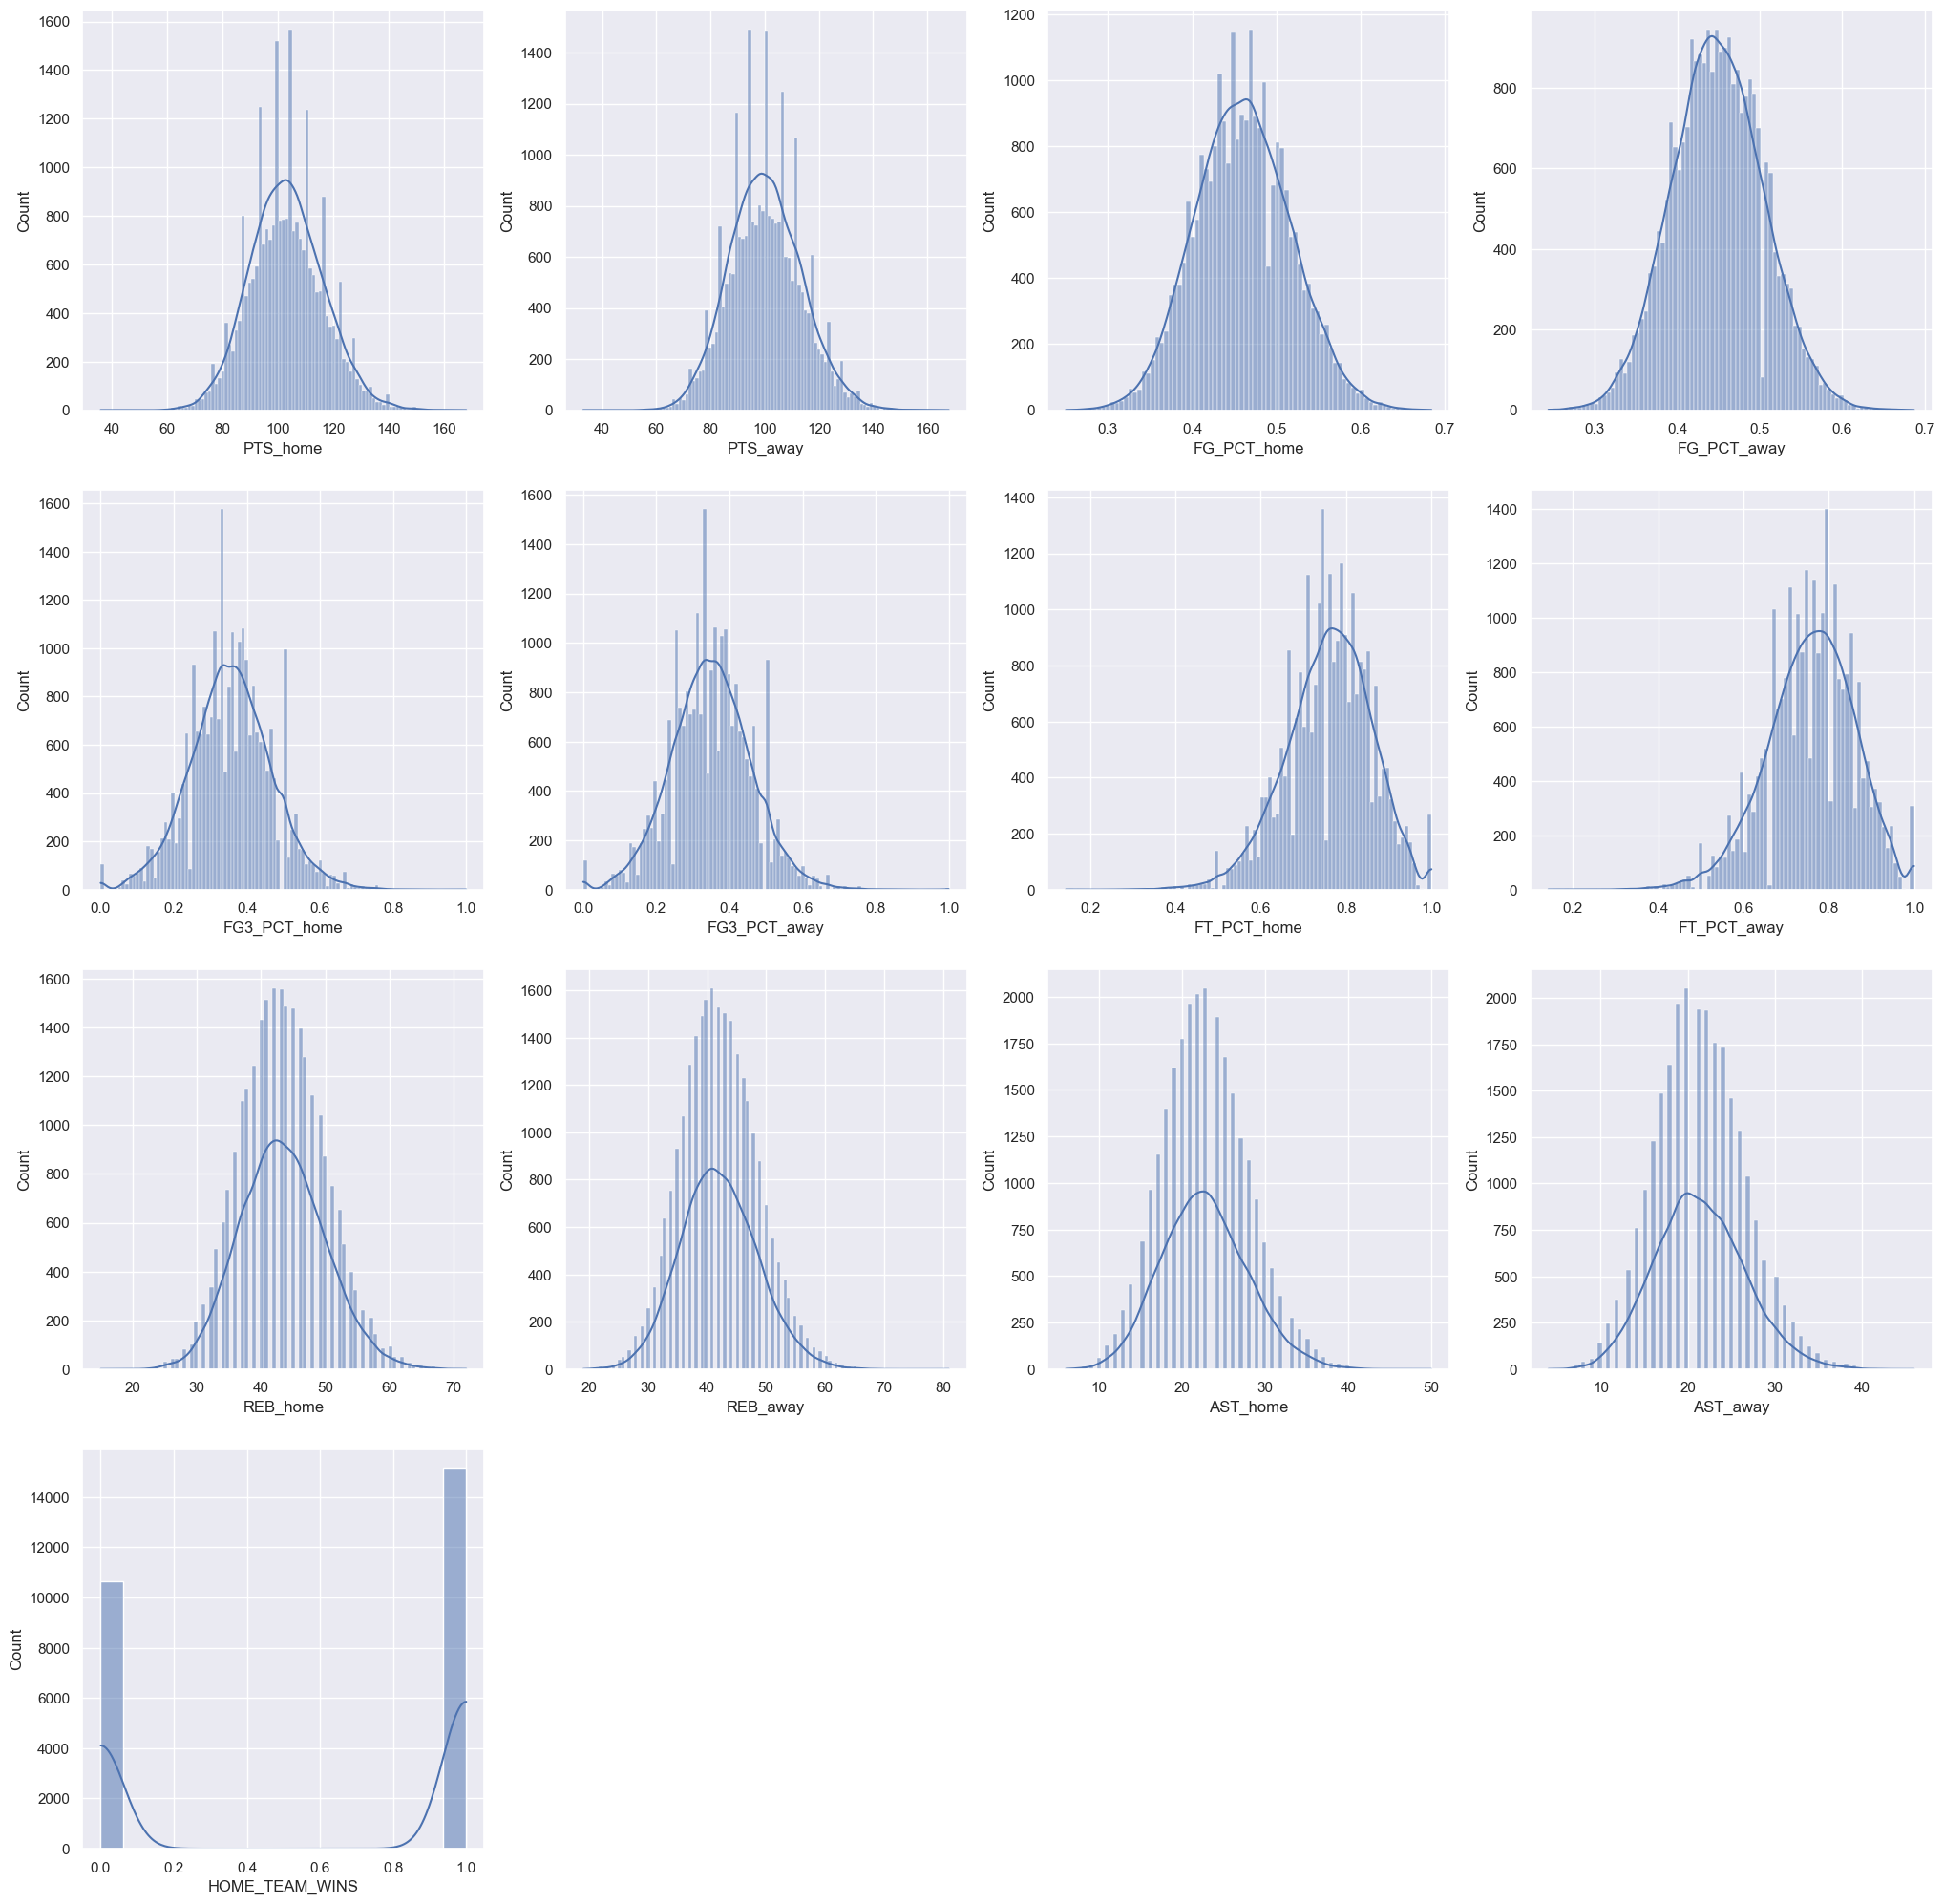

In [75]:
value_list = ['PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FG_PCT_away', 
              'FG3_PCT_home', 'FG3_PCT_away',
              'FT_PCT_home', 'FT_PCT_away', 
              'REB_home', 'REB_away',
              'AST_home', 'AST_away', 
              'HOME_TEAM_WINS',
             ]

sns.set(rc={'figure.figsize':(25,25)})
for i, column in enumerate(value_list, 1):
    plt.subplot(4,4,i)
    p=sns.histplot(x=column, data=games, stat='count', kde=True)

###
### Group data to check season-by-season variation


In [76]:
# summarize data for each season to check season by season variation

value_list = ['GAME_ID', 'HOME_TEAM_WINS', 'PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
              'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 
             ]
agg_dict = {'GAME_ID': len, 'HOME_TEAM_WINS': np.sum, 'PTS_home': np.mean, 'PTS_away': np.mean,
           'FG_PCT_home': np.mean, 'FT_PCT_home': np.mean, 'FG3_PCT_home': np.mean, 'AST_home': np.mean, 'REB_home': np.mean,
           'FG_PCT_away': np.mean, 'FT_PCT_away': np.mean, 'FG3_PCT_away': np.mean, 'AST_away': np.mean, 'REB_away': np.mean,
           }

df = pd.pivot_table(games,index=['SEASON'],
                    values=value_list,
                    aggfunc=agg_dict,
                   )
df = df.reset_index()
df = df.rename(columns={'GAME_ID': 'GAMES_PLAYED',})

df['HOME_WIN_RATIO'] = df['HOME_TEAM_WINS'] / df['GAMES_PLAYED']

# move more interesting columns to front
column1 = df.pop('GAMES_PLAYED')
column2 = df.pop('HOME_TEAM_WINS')
column3 = df.pop('HOME_WIN_RATIO')
df.insert(1,'GAMES_PLAYED', column1)
df.insert(2,'HOME_TEAM_WINS', column2)
df.insert(3,'HOME_WIN_RATIO', column3)

df

,SEASON,GAMES_PLAYED,HOME_TEAM_WINS,HOME_WIN_RATIO,AST_away,AST_home,FG3_PCT_away,FG3_PCT_home,FG_PCT_away,FG_PCT_home,FT_PCT_away,FT_PCT_home,PTS_away,PTS_home,REB_away,REB_home
0,2003,1385,800,0.577617,20.262053,22.056765,0.330227,0.342993,0.431240,0.445108,0.750990,0.748642,91.092535,94.907465,41.241058,43.173406
1,2004,1362,824,0.604993,20.240088,21.928781,0.346637,0.354970,0.441678,0.454632,0.752280,0.756231,95.381791,98.604993,41.000000,42.533040
2,2005,1432,866,0.604749,19.689944,21.152235,0.355920,0.350063,0.448051,0.460089,0.742950,0.744709,95.172486,98.406425,39.972067,41.799581
3,2006,1419,839,0.591261,20.223397,22.004933,0.348088,0.353187,0.450718,0.462074,0.748125,0.748553,96.944327,99.849190,40.442565,41.609584
4,2007,1411,862,0.610914,20.579022,22.496811,0.352690,0.359906,0.448358,0.463230,0.752360,0.757163,97.549256,101.273565,41.146704,42.702339
5,2008,1425,857,0.601404,20.002105,21.588070,0.357941,0.363791,0.451627,0.463702,0.767012,0.766348,97.903860,100.922807,40.530526,41.960000
6,2009,1424,857,0.601826,20.259831,21.884831,0.350468,0.349756,0.456085,0.465970,0.754971,0.757674,98.745787,101.654494,41.030899,42.205758
7,2010,1422,871,0.612518,20.533052,21.976090,0.348895,0.355870,0.450444,0.463857,0.759762,0.763982,97.384669,100.756681,40.860759,41.908579
8,2011,1104,656,0.594203,20.115036,21.380435,0.338460,0.344514,0.441467,0.453630,0.751953,0.753493,94.429348,97.392210,41.421196,42.860507
9,2012,1420,872,0.614085,21.218310,22.605634,0.343558,0.363454,0.445188,0.458730,0.754877,0.749131,96.114085,99.381690,41.549296,42.756338


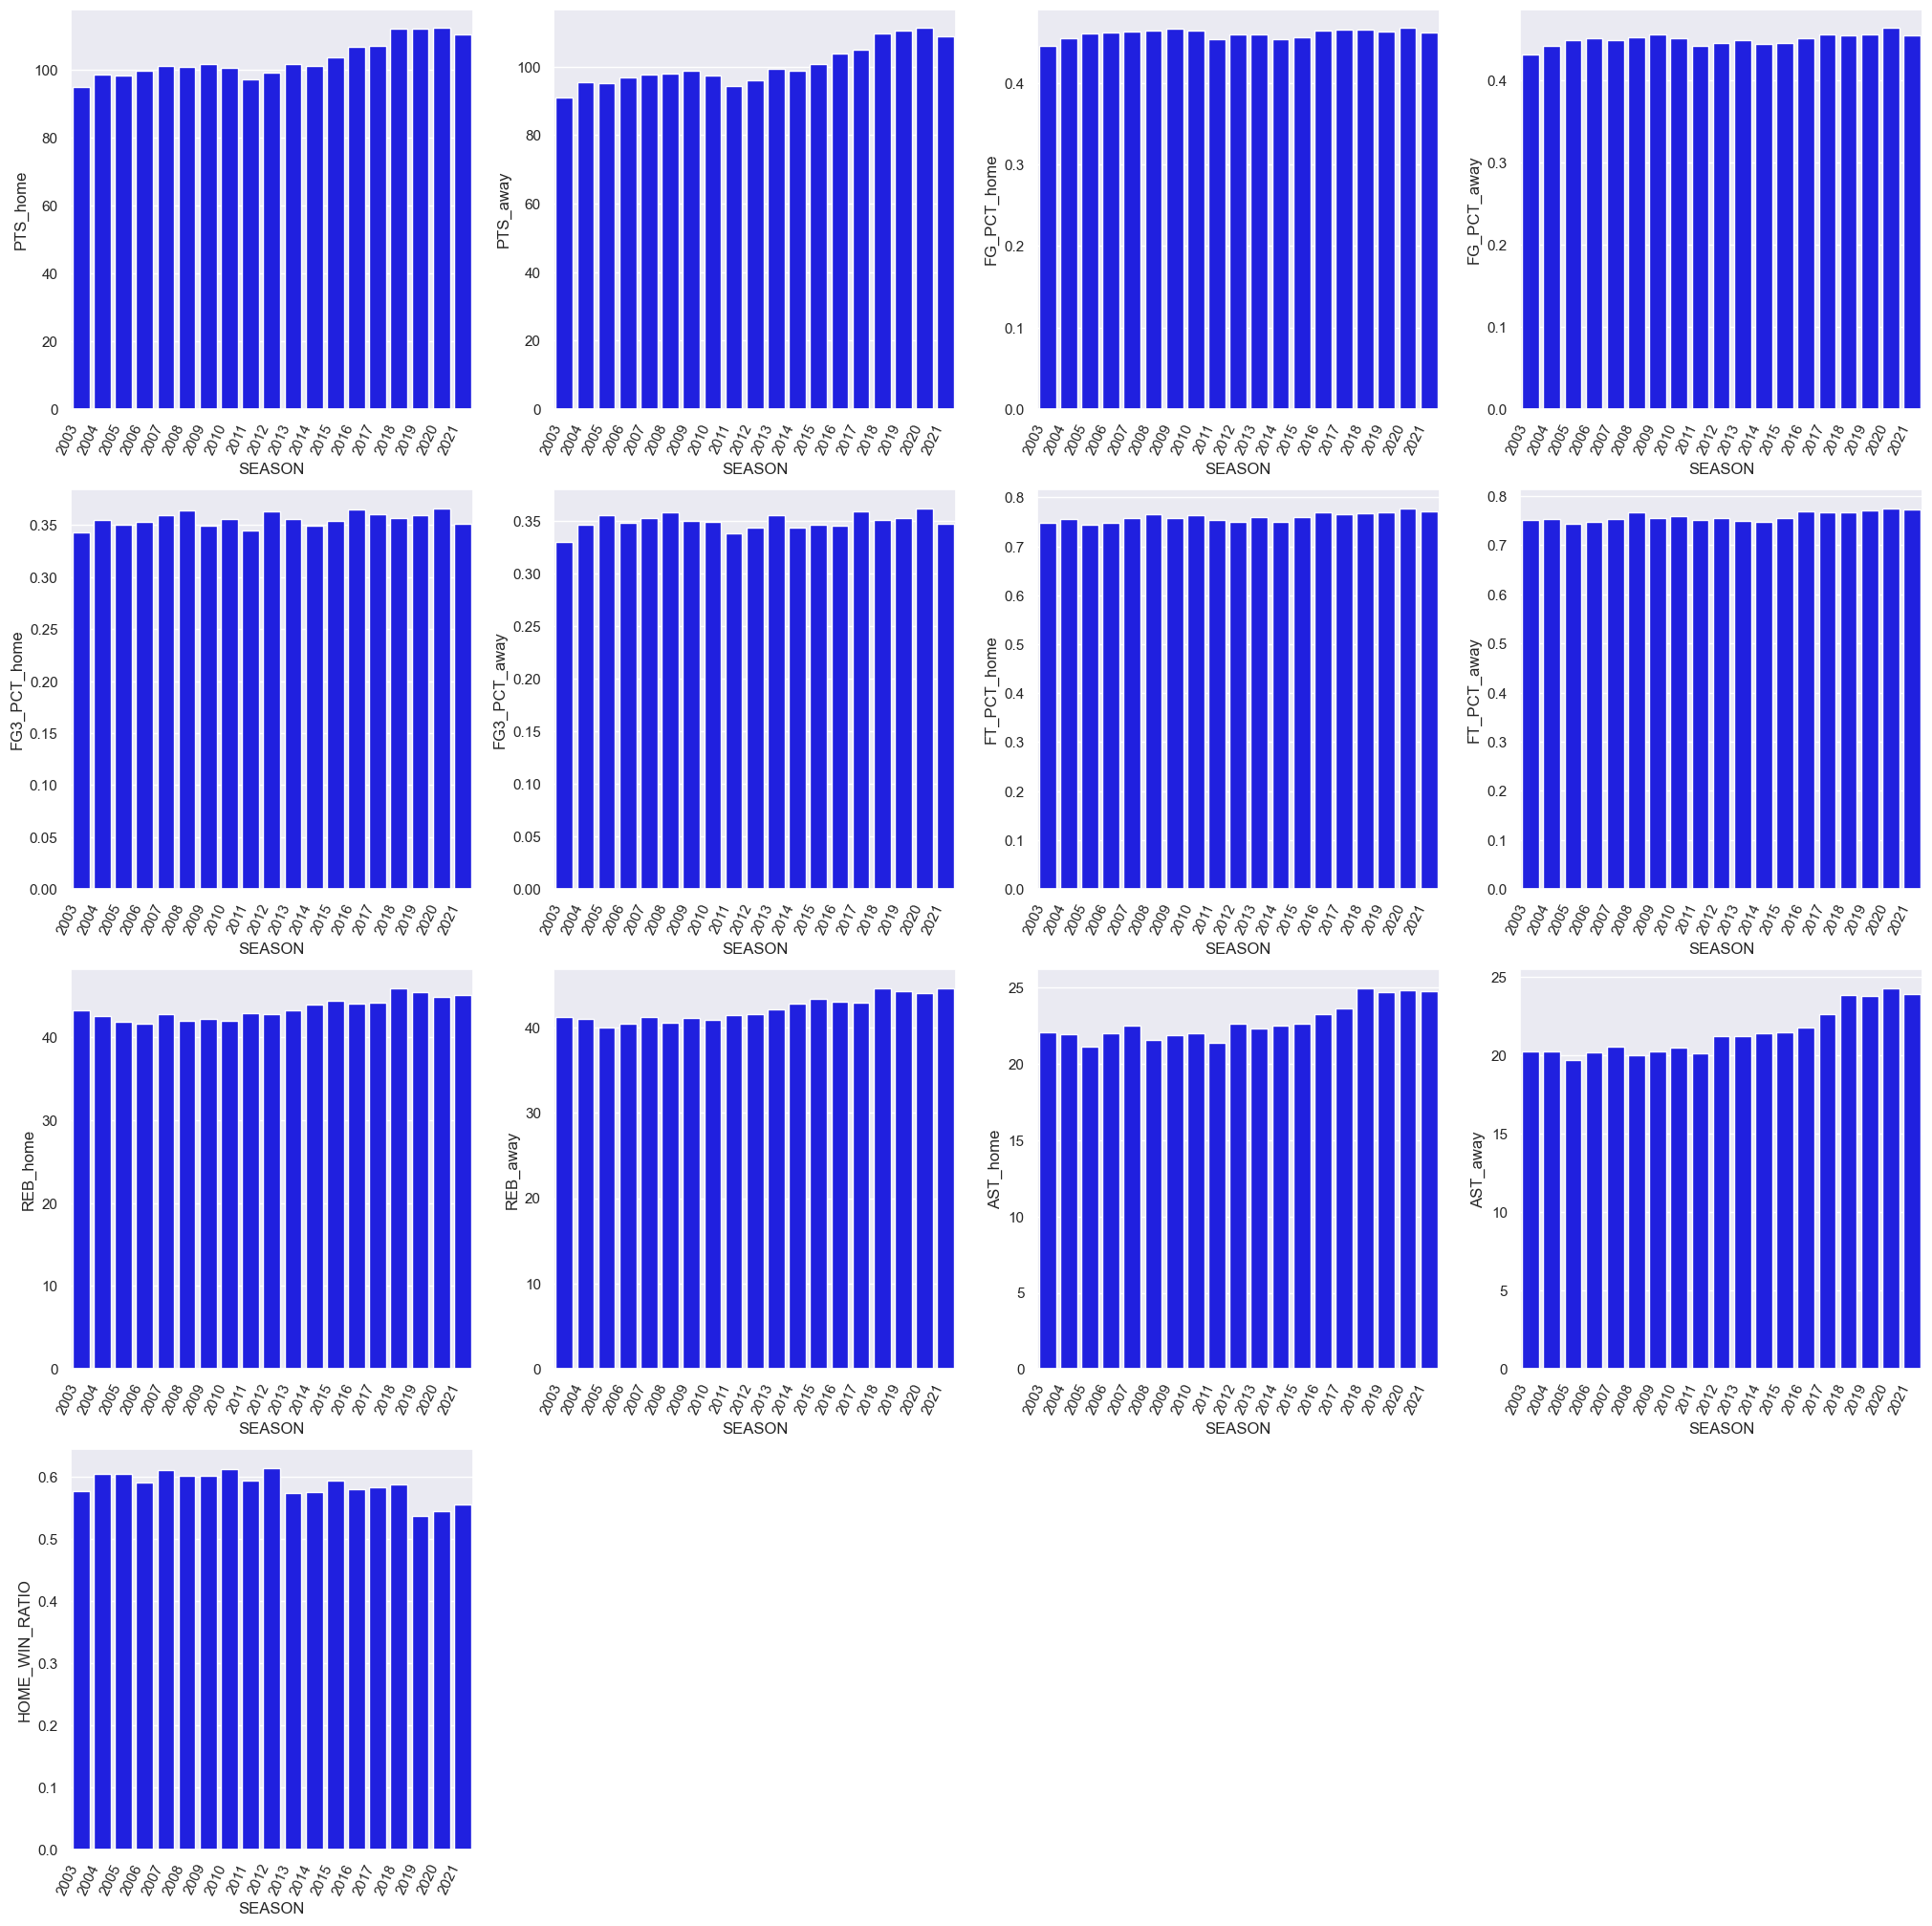

In [77]:
value_list = ['PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FG_PCT_away', 
              'FG3_PCT_home', 'FG3_PCT_away',
              'FT_PCT_home', 'FT_PCT_away', 
              'REB_home', 'REB_away',
              'AST_home', 'AST_away', 
              'HOME_WIN_RATIO',
             ]
for i, column in enumerate(value_list, 1):
    plt.subplot(4,4,i)
    plt.xticks(rotation=65, horizontalalignment='right',)
    ax = sns.barplot(data=df, x='SEASON', y=column, color='blue')
 

NOTE - PTS, REB, AST have trended up the last several seasons, but Home win ratio is down

In [78]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GAMES_PLAYED,19.0,1357.684211,109.049964,1076.000000,1370.000000,1411.000000,1421.000000,1432.000000
HOME_TEAM_WINS,19.0,797.631579,82.883593,597.000000,802.500000,819.000000,857.000000,872.000000
HOME_WIN_RATIO,19.0,0.586563,0.022238,0.536664,0.576538,0.591261,0.603287,0.614085
AST_away,19.0,21.454112,1.524009,19.689944,20.249960,21.218310,22.224126,24.302642
AST_home,19.0,22.773837,1.229183,21.152235,21.952436,22.496811,23.461422,24.961538
FG3_PCT_away,19.0,0.349273,0.007579,0.330227,0.345872,0.348895,0.354134,0.362180
FG3_PCT_home,19.0,0.355751,0.006663,0.342993,0.350853,0.355870,0.360421,0.366418
FG_PCT_away,19.0,0.449277,0.006996,0.431240,0.445298,0.450444,0.454240,0.463211
FG_PCT_home,19.0,0.460237,0.005547,0.445108,0.457373,0.462074,0.463779,0.466913
FT_PCT_away,19.0,0.758384,0.009902,0.742950,0.751471,0.754877,0.767010,0.775382


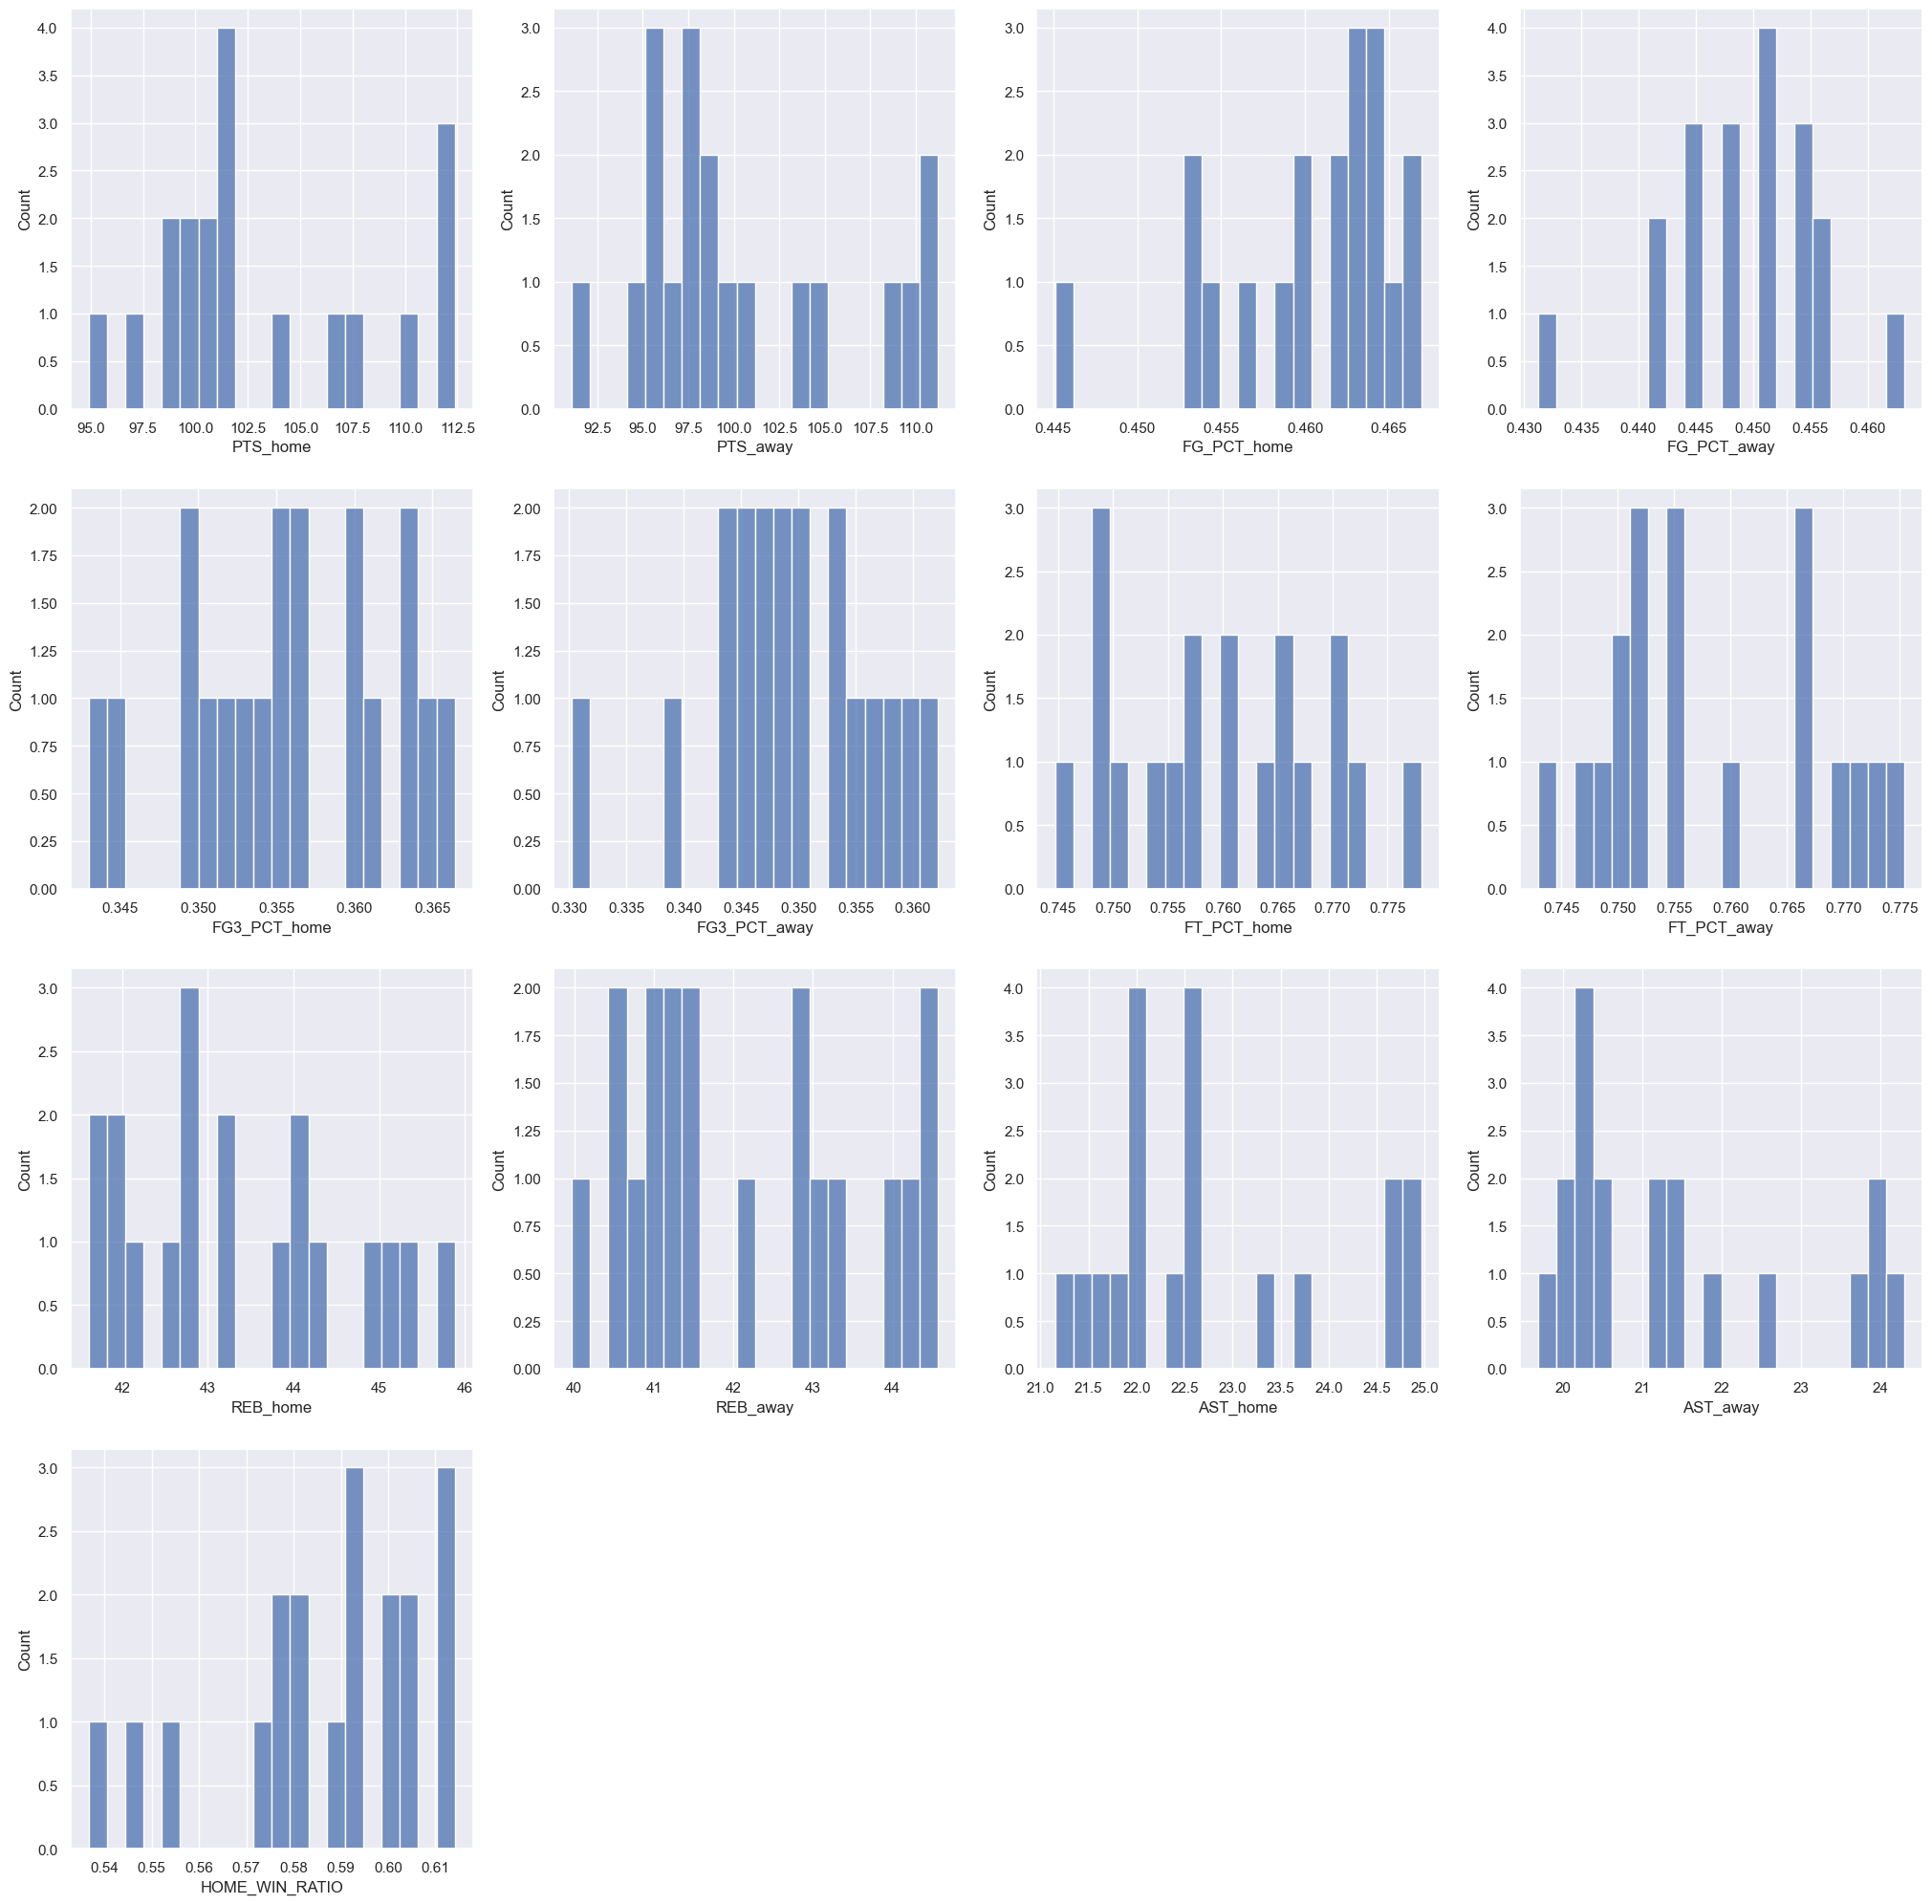

In [79]:
value_list = ['PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FG_PCT_away', 
              'FG3_PCT_home', 'FG3_PCT_away',
              'FT_PCT_home', 'FT_PCT_away', 
              'REB_home', 'REB_away',
              'AST_home', 'AST_away', 
              'HOME_WIN_RATIO',
             ]

sns.set(rc={'figure.figsize':(25,25)})
for i, column in enumerate(value_list, 1):
    plt.subplot(4,4,i)
    p=sns.histplot(x=column, data=df, stat='count',bins = 20)

### 
### Group to check team-by-team variation for one season

In [80]:
# summarize data for each team during 2021 to check team-by-team variation

games2021 = games[games['SEASON']==2021]

value_list = ['GAME_ID', 'HOME_TEAM_WINS', 'PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
              'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away', 
             ]
agg_dict = {'GAME_ID': len, 'HOME_TEAM_WINS': np.sum, 'PTS_home': np.mean, 'PTS_away': np.mean,
           'FG_PCT_home': np.mean, 'FT_PCT_home': np.mean, 'FG3_PCT_home': np.mean, 'AST_home': np.mean, 'REB_home': np.mean,
           'FG_PCT_away': np.mean, 'FT_PCT_away': np.mean, 'FG3_PCT_away': np.mean, 'AST_away': np.mean, 'REB_away': np.mean,
           }

df = pd.pivot_table(games2021,index=['HOME_TEAM_ID'],
                    values=value_list,
                    aggfunc=agg_dict,
                   )

df = df.reset_index()
df = df.rename(columns={'GAME_ID': 'GAMES_PLAYED',})

df['HOME_WIN_RATIO'] = df['HOME_TEAM_WINS'] / df['GAMES_PLAYED']

# move more interesting columns to front
column1 = df.pop('GAMES_PLAYED')
column2 = df.pop('HOME_TEAM_WINS')
column3 = df.pop('HOME_WIN_RATIO')
df.insert(1,'GAMES_PLAYED', column1)
df.insert(2,'HOME_TEAM_WINS', column2)
df.insert(3,'HOME_WIN_RATIO', column3)

df

,HOME_TEAM_ID,GAMES_PLAYED,HOME_TEAM_WINS,HOME_WIN_RATIO,AST_away,AST_home,FG3_PCT_away,FG3_PCT_home,FG_PCT_away,FG_PCT_home,FT_PCT_away,FT_PCT_home,PTS_away,PTS_home,REB_away,REB_home
0,1610612737,35,21,0.600000,25.371429,25.428571,0.364486,0.382486,0.465257,0.482886,0.791314,0.813229,110.628571,115.114286,42.257143,43.828571
1,1610612738,37,26,0.702703,21.594595,23.729730,0.344351,0.347108,0.433270,0.456270,0.785946,0.818351,103.459459,108.945946,44.540541,46.432432
2,1610612739,33,20,0.606061,23.424242,24.939394,0.321000,0.348727,0.440273,0.463364,0.760606,0.744515,100.909091,105.818182,43.727273,44.757576
3,1610612740,35,16,0.457143,23.400000,25.800000,0.357029,0.334229,0.459057,0.462800,0.780057,0.796514,109.028571,109.885714,42.285714,45.857143
4,1610612741,38,28,0.736842,24.131579,25.026316,0.351184,0.378447,0.461447,0.487342,0.774763,0.808895,108.815789,115.210526,42.921053,44.842105
5,1610612742,37,25,0.675676,23.297297,23.027027,0.323865,0.342027,0.454676,0.452595,0.745541,0.749000,102.513514,106.918919,44.432432,43.594595
6,1610612743,34,20,0.588235,24.117647,28.147059,0.347382,0.350647,0.468735,0.477029,0.751735,0.791118,109.676471,113.352941,43.382353,44.352941
7,1610612744,38,31,0.815789,22.078947,28.342105,0.327316,0.371421,0.421289,0.474553,0.775000,0.761974,102.552632,113.868421,43.342105,47.000000
8,1610612745,34,11,0.323529,24.558824,24.205882,0.349559,0.352235,0.474824,0.458500,0.773824,0.711559,117.529412,111.058824,46.205882,41.676471
9,1610612746,37,21,0.567568,24.189189,23.675676,0.326649,0.371135,0.451595,0.456865,0.789405,0.792676,108.405405,108.108108,45.945946,44.729730


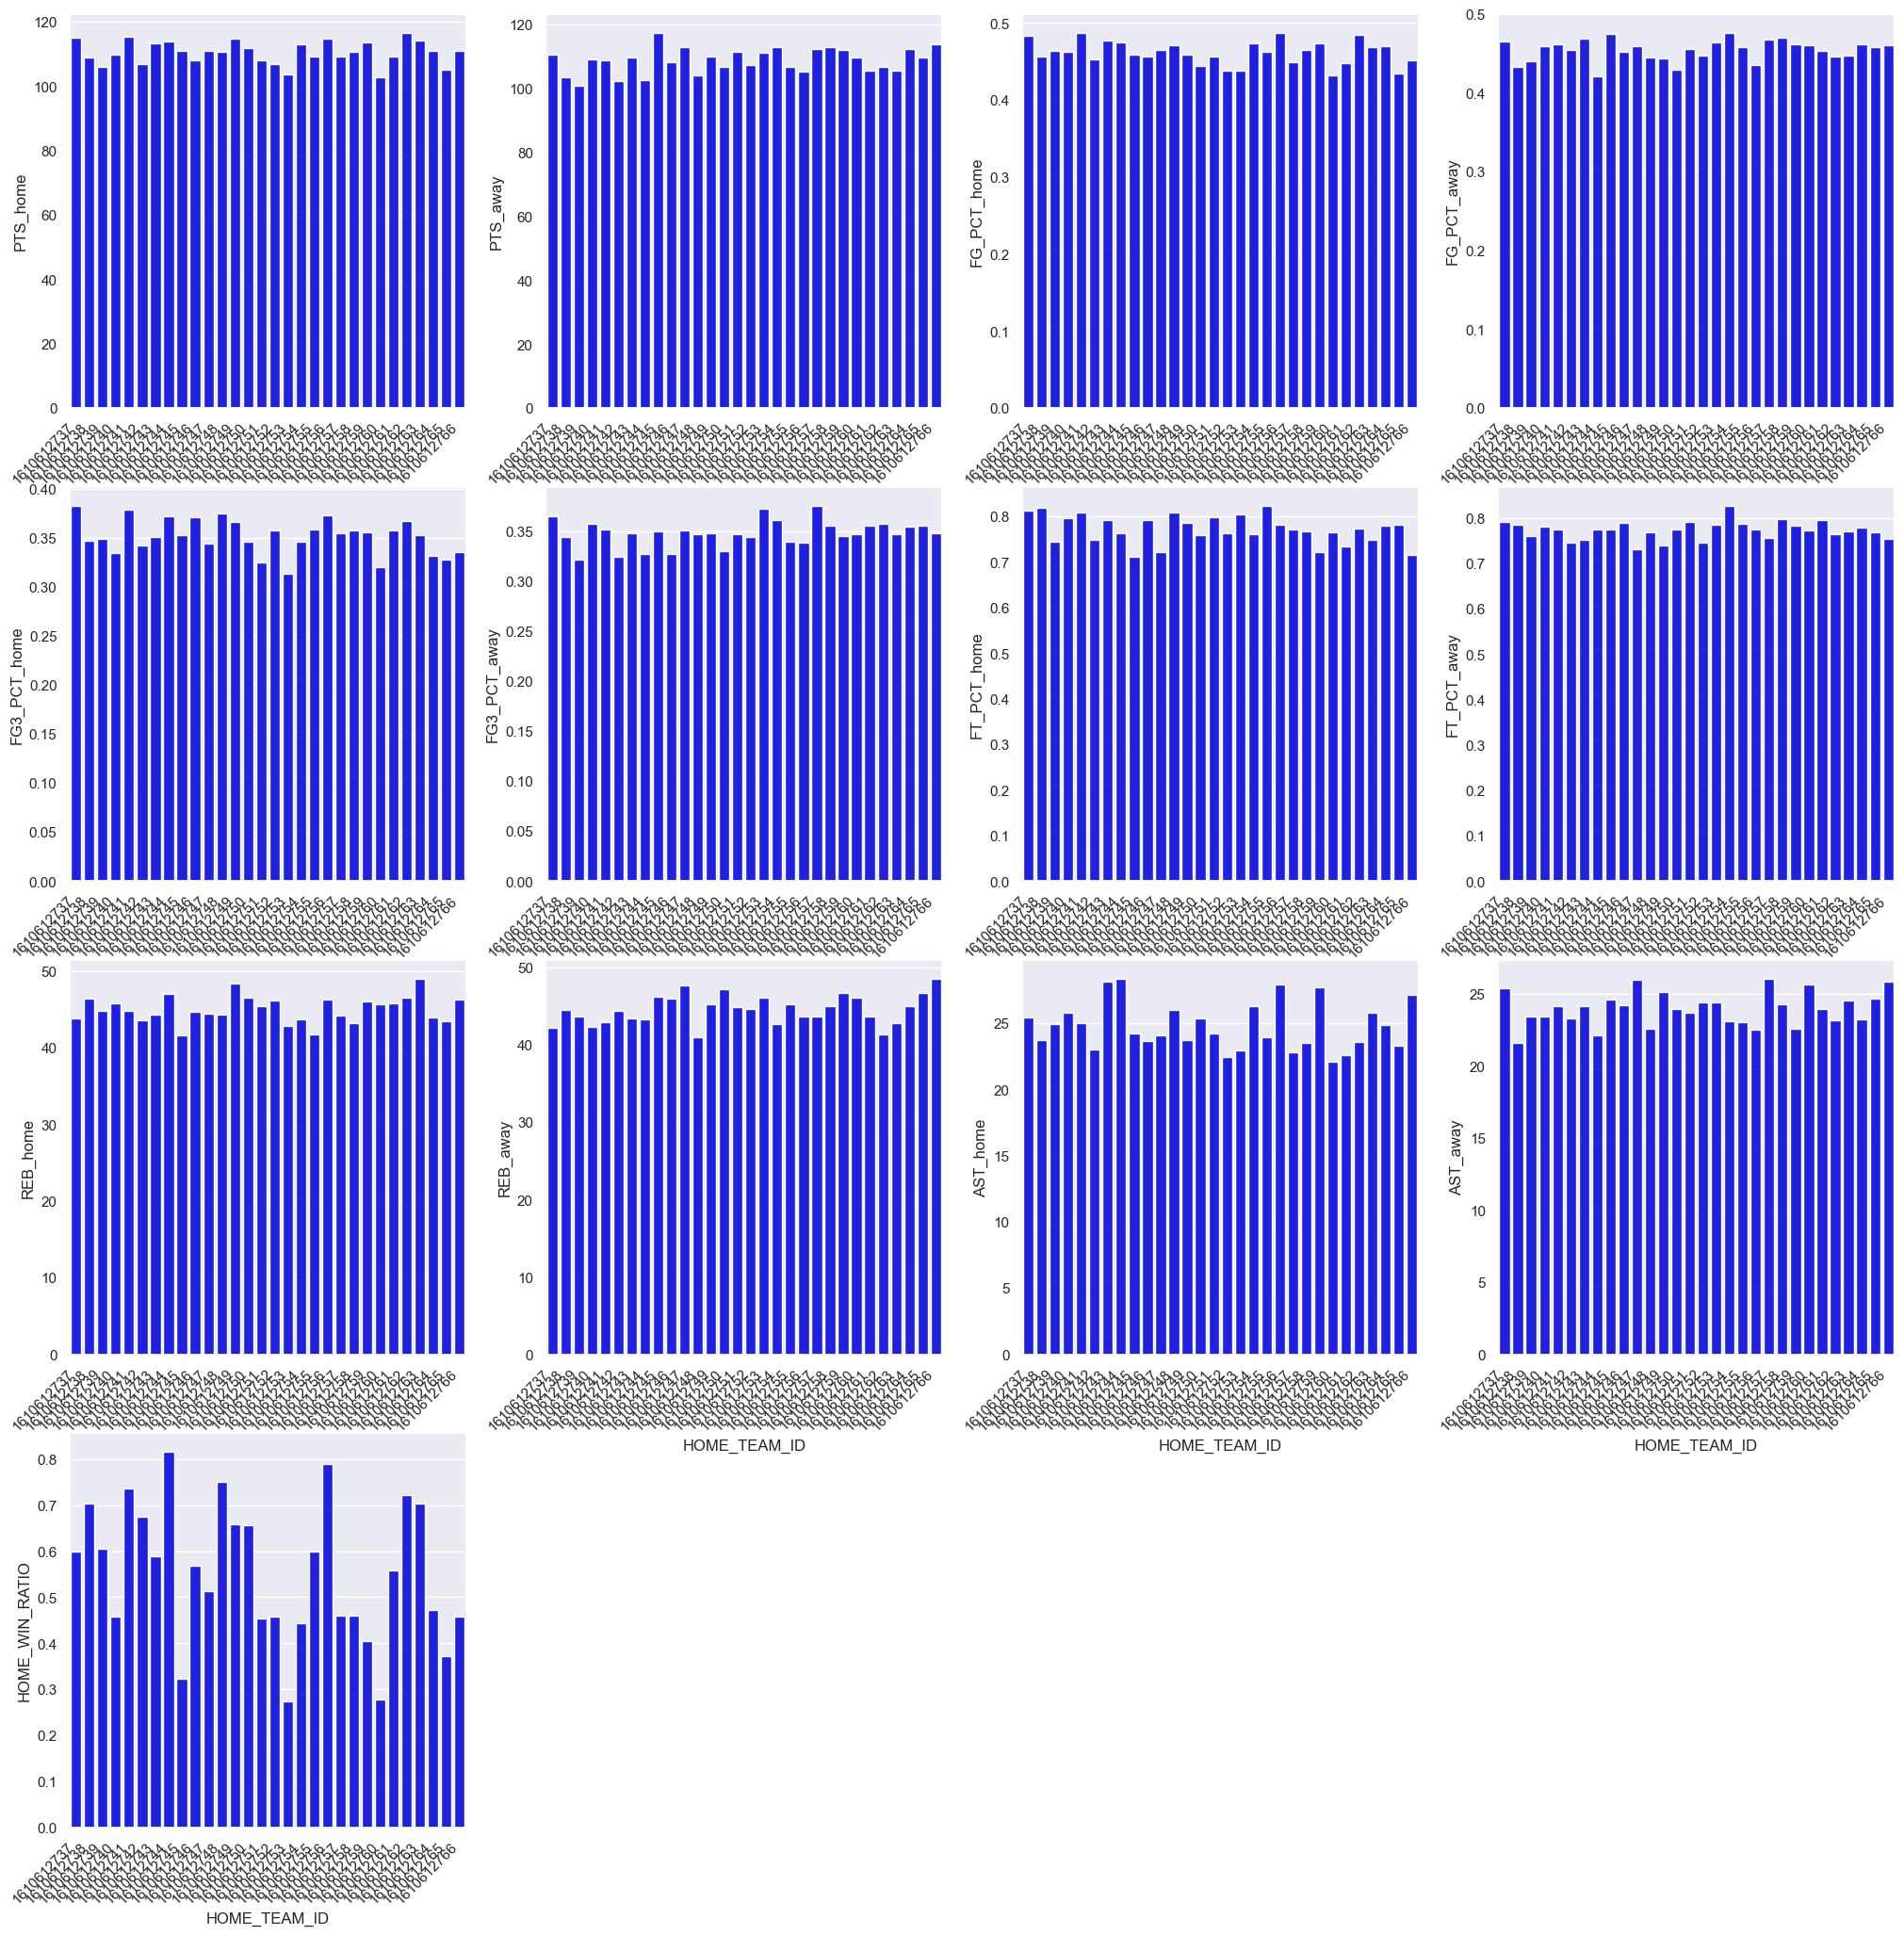

In [81]:
value_list = ['PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FG_PCT_away', 
              'FG3_PCT_home', 'FG3_PCT_away',
              'FT_PCT_home', 'FT_PCT_away', 
              'REB_home', 'REB_away',
              'AST_home', 'AST_away', 
              'HOME_WIN_RATIO',
             ]
for i, column in enumerate(value_list, 1):
    plt.subplot(4,4,i)
    plt.xticks(rotation=45, horizontalalignment='right',)
    ax = sns.barplot(data=df, x='HOME_TEAM_ID', y=column, color='blue')

In [82]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GAMES_PLAYED,30.0,35.866667,1.634400,33.000000,35.000000,36.000000,37.000000,39.000000
HOME_TEAM_WINS,30.0,19.900000,5.862505,9.000000,16.000000,20.000000,25.000000,31.000000
HOME_WIN_RATIO,30.0,0.551879,0.150059,0.272727,0.457143,0.563196,0.671230,0.815789
AST_away,30.0,23.951150,1.155892,21.594595,23.159722,24.030252,24.554253,26.027027
AST_home,30.0,24.749118,1.794987,22.055556,23.503754,24.209002,25.795946,28.342105
FG3_PCT_away,30.0,0.347572,0.012952,0.321000,0.344302,0.347391,0.355153,0.375243
FG3_PCT_home,30.0,0.351295,0.017605,0.312788,0.342584,0.352550,0.364068,0.382486
FG_PCT_away,30.0,0.454227,0.013354,0.421289,0.445919,0.458000,0.461363,0.476250
FG_PCT_home,30.0,0.461370,0.015401,0.431361,0.451463,0.462786,0.472729,0.487342
FT_PCT_away,30.0,0.773113,0.019834,0.731179,0.761774,0.774510,0.785899,0.826944


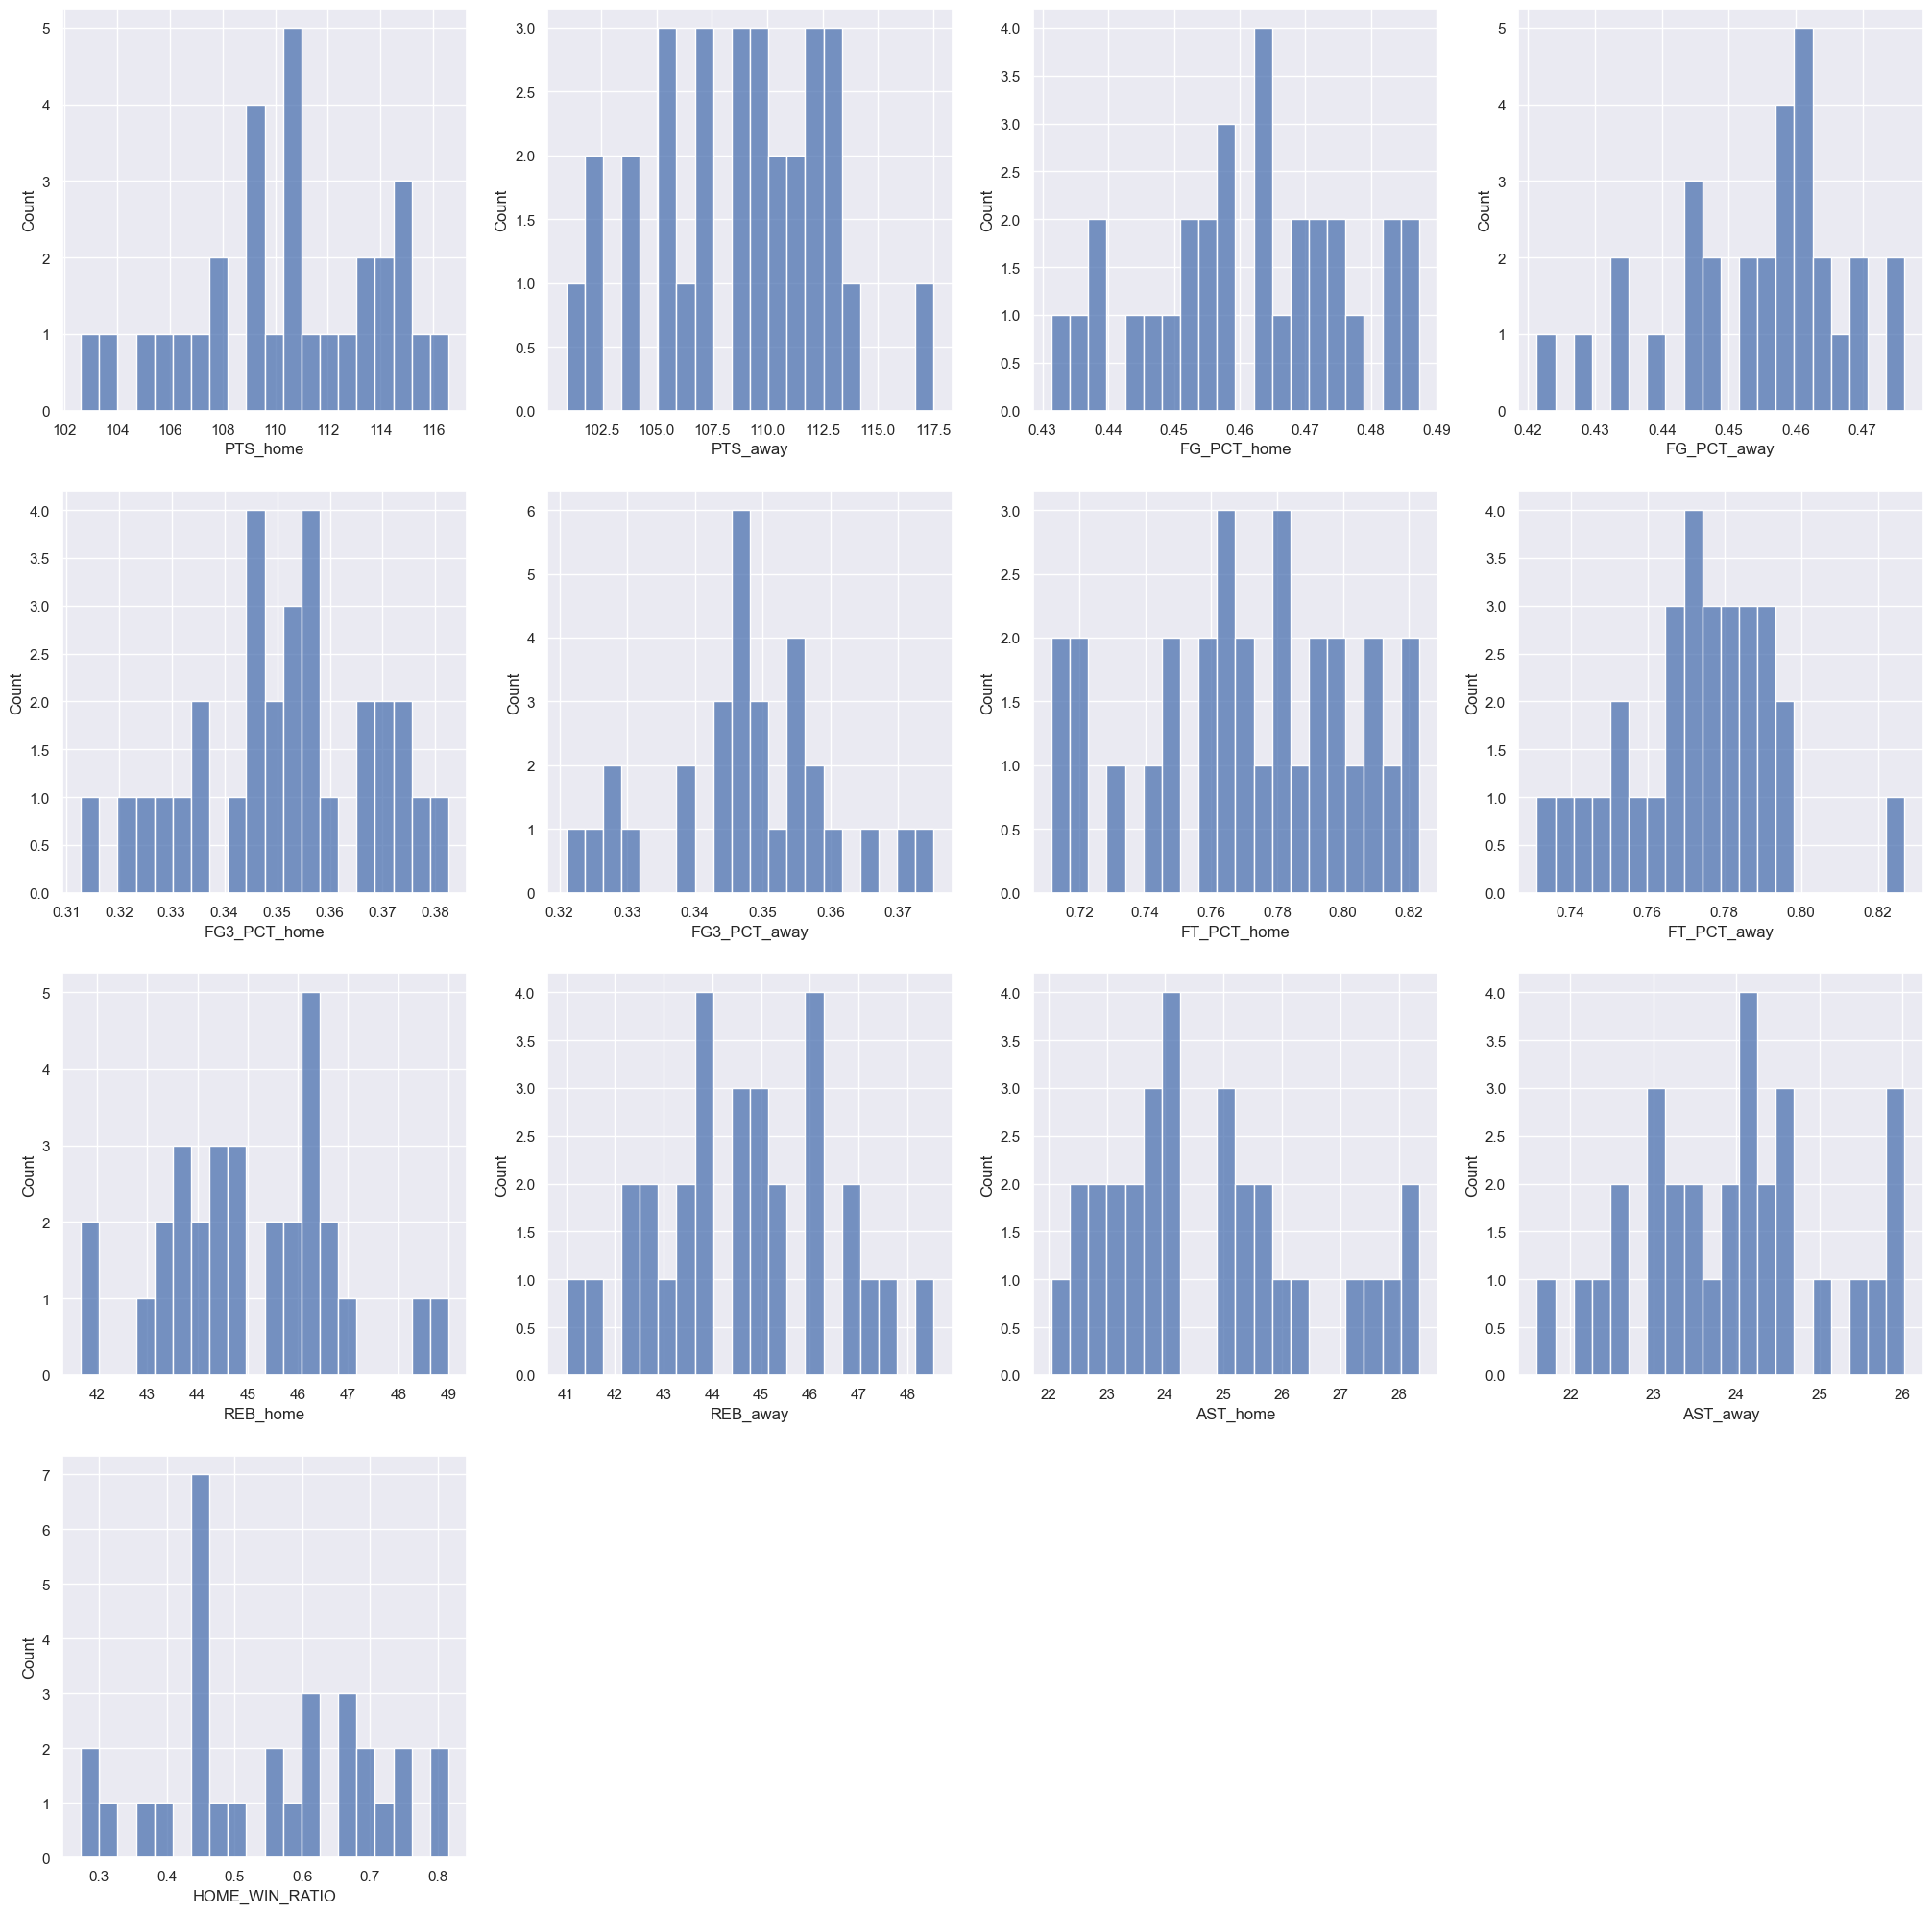

In [83]:
value_list = ['PTS_home', 'PTS_away', 
              'FG_PCT_home', 'FG_PCT_away', 
              'FG3_PCT_home', 'FG3_PCT_away',
              'FT_PCT_home', 'FT_PCT_away', 
              'REB_home', 'REB_away',
              'AST_home', 'AST_away', 
              'HOME_WIN_RATIO',
             ]

sns.set(rc={'figure.figsize':(25,25)})
for i, column in enumerate(value_list, 1):
    plt.subplot(4,4,i)
    p=sns.histplot(x=column, data=df, stat='count', bins = 20)

###
### Correlations

PTS_away      FG_PCT_away       0.657157
PTS_home      FG_PCT_home       0.648772
              AST_home          0.578856
PTS_away      AST_away          0.570553
FG_PCT_home   AST_home          0.532937
FG_PCT_away   AST_away          0.503504
PTS_home      PTS_away          0.465219
FG_PCT_home   FG3_PCT_home      0.449162
FG_PCT_away   FG3_PCT_away      0.438180
FG_PCT_home   HOME_TEAM_WINS    0.436742
PTS_home      FG3_PCT_home      0.426019
PTS_away      FG3_PCT_away      0.418945
PTS_home      HOME_TEAM_WINS    0.400126
FG3_PCT_home  AST_home          0.352671
FG3_PCT_away  AST_away          0.325120
FG3_PCT_home  HOME_TEAM_WINS    0.311429
AST_home      HOME_TEAM_WINS    0.303158
REB_home      HOME_TEAM_WINS    0.244826
PTS_home      AST_away          0.202457
PTS_away      FT_PCT_away       0.194275
PTS_home      FT_PCT_home       0.178647
AST_home      PTS_away          0.172181
PTS_away      REB_away          0.163203
PTS_home      REB_home          0.149032
AST_home      AS

<AxesSubplot: >

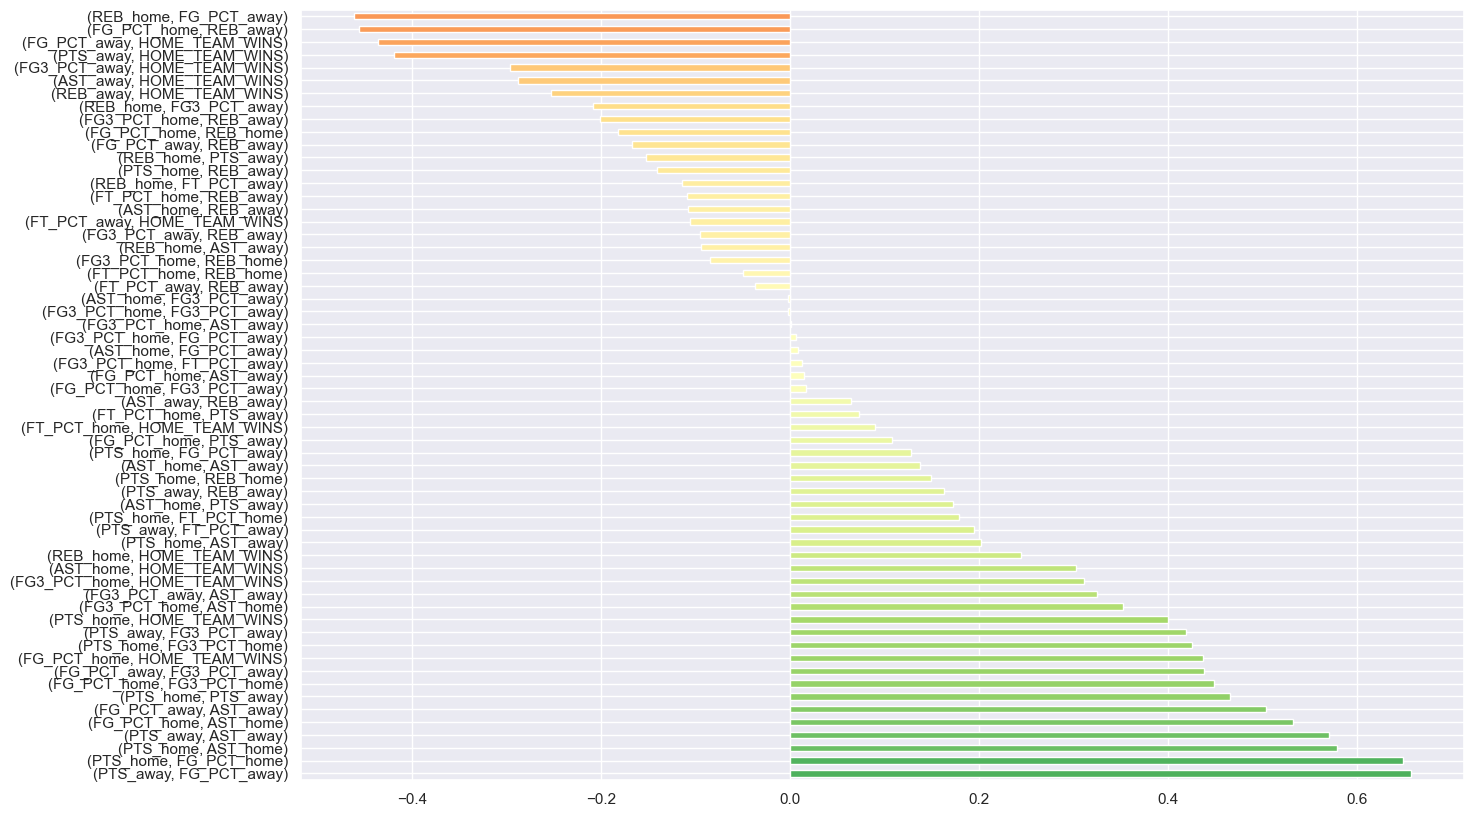

In [84]:
# correlation bar chart

from matplotlib.colors import TwoSlopeNorm

df1 = games.drop(columns=['GAME_ID'])
#df1[cat_cols] = OrdinalEncoder().fit_transform(df1[cat_cols])

useful_columns =  df1.select_dtypes(include=['number']).columns

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0,df.shape[1]):
        for j in range(0,i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

def get_correlations(df,n=30):
    au_corr = df.corr(method = 'spearman').unstack() #spearman used because not all data is normalized
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending=False)
    top_n = au_corr[0:n]    
    bottom_n =  au_corr[-n:]
    top_corr = pd.concat([top_n, bottom_n])
    return top_corr

corrplot = get_correlations(df1[useful_columns])


fig, ax = plt.subplots(figsize=(15,10))
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax =1)
colors = [plt.cm.RdYlGn(norm(c)) for c in corrplot.values]

print(corrplot)

corrplot.plot.barh(color=colors)

NOTE 
- FG_PCT and AST strongly correlated to PTS. 
- Opposing REB_PCT strongly negatively correlated to FG_PCT.

### Correlations vs TARGET (all seasons composite)

FG_PCT_home     0.436742
PTS_home        0.400126
FG3_PCT_home    0.311429
AST_home        0.303158
REB_home        0.244826
FT_PCT_home     0.089880
FT_PCT_away    -0.106141
REB_away       -0.252744
AST_away       -0.288199
FG3_PCT_away   -0.296431
PTS_away       -0.419197
FG_PCT_away    -0.436554
dtype: float64


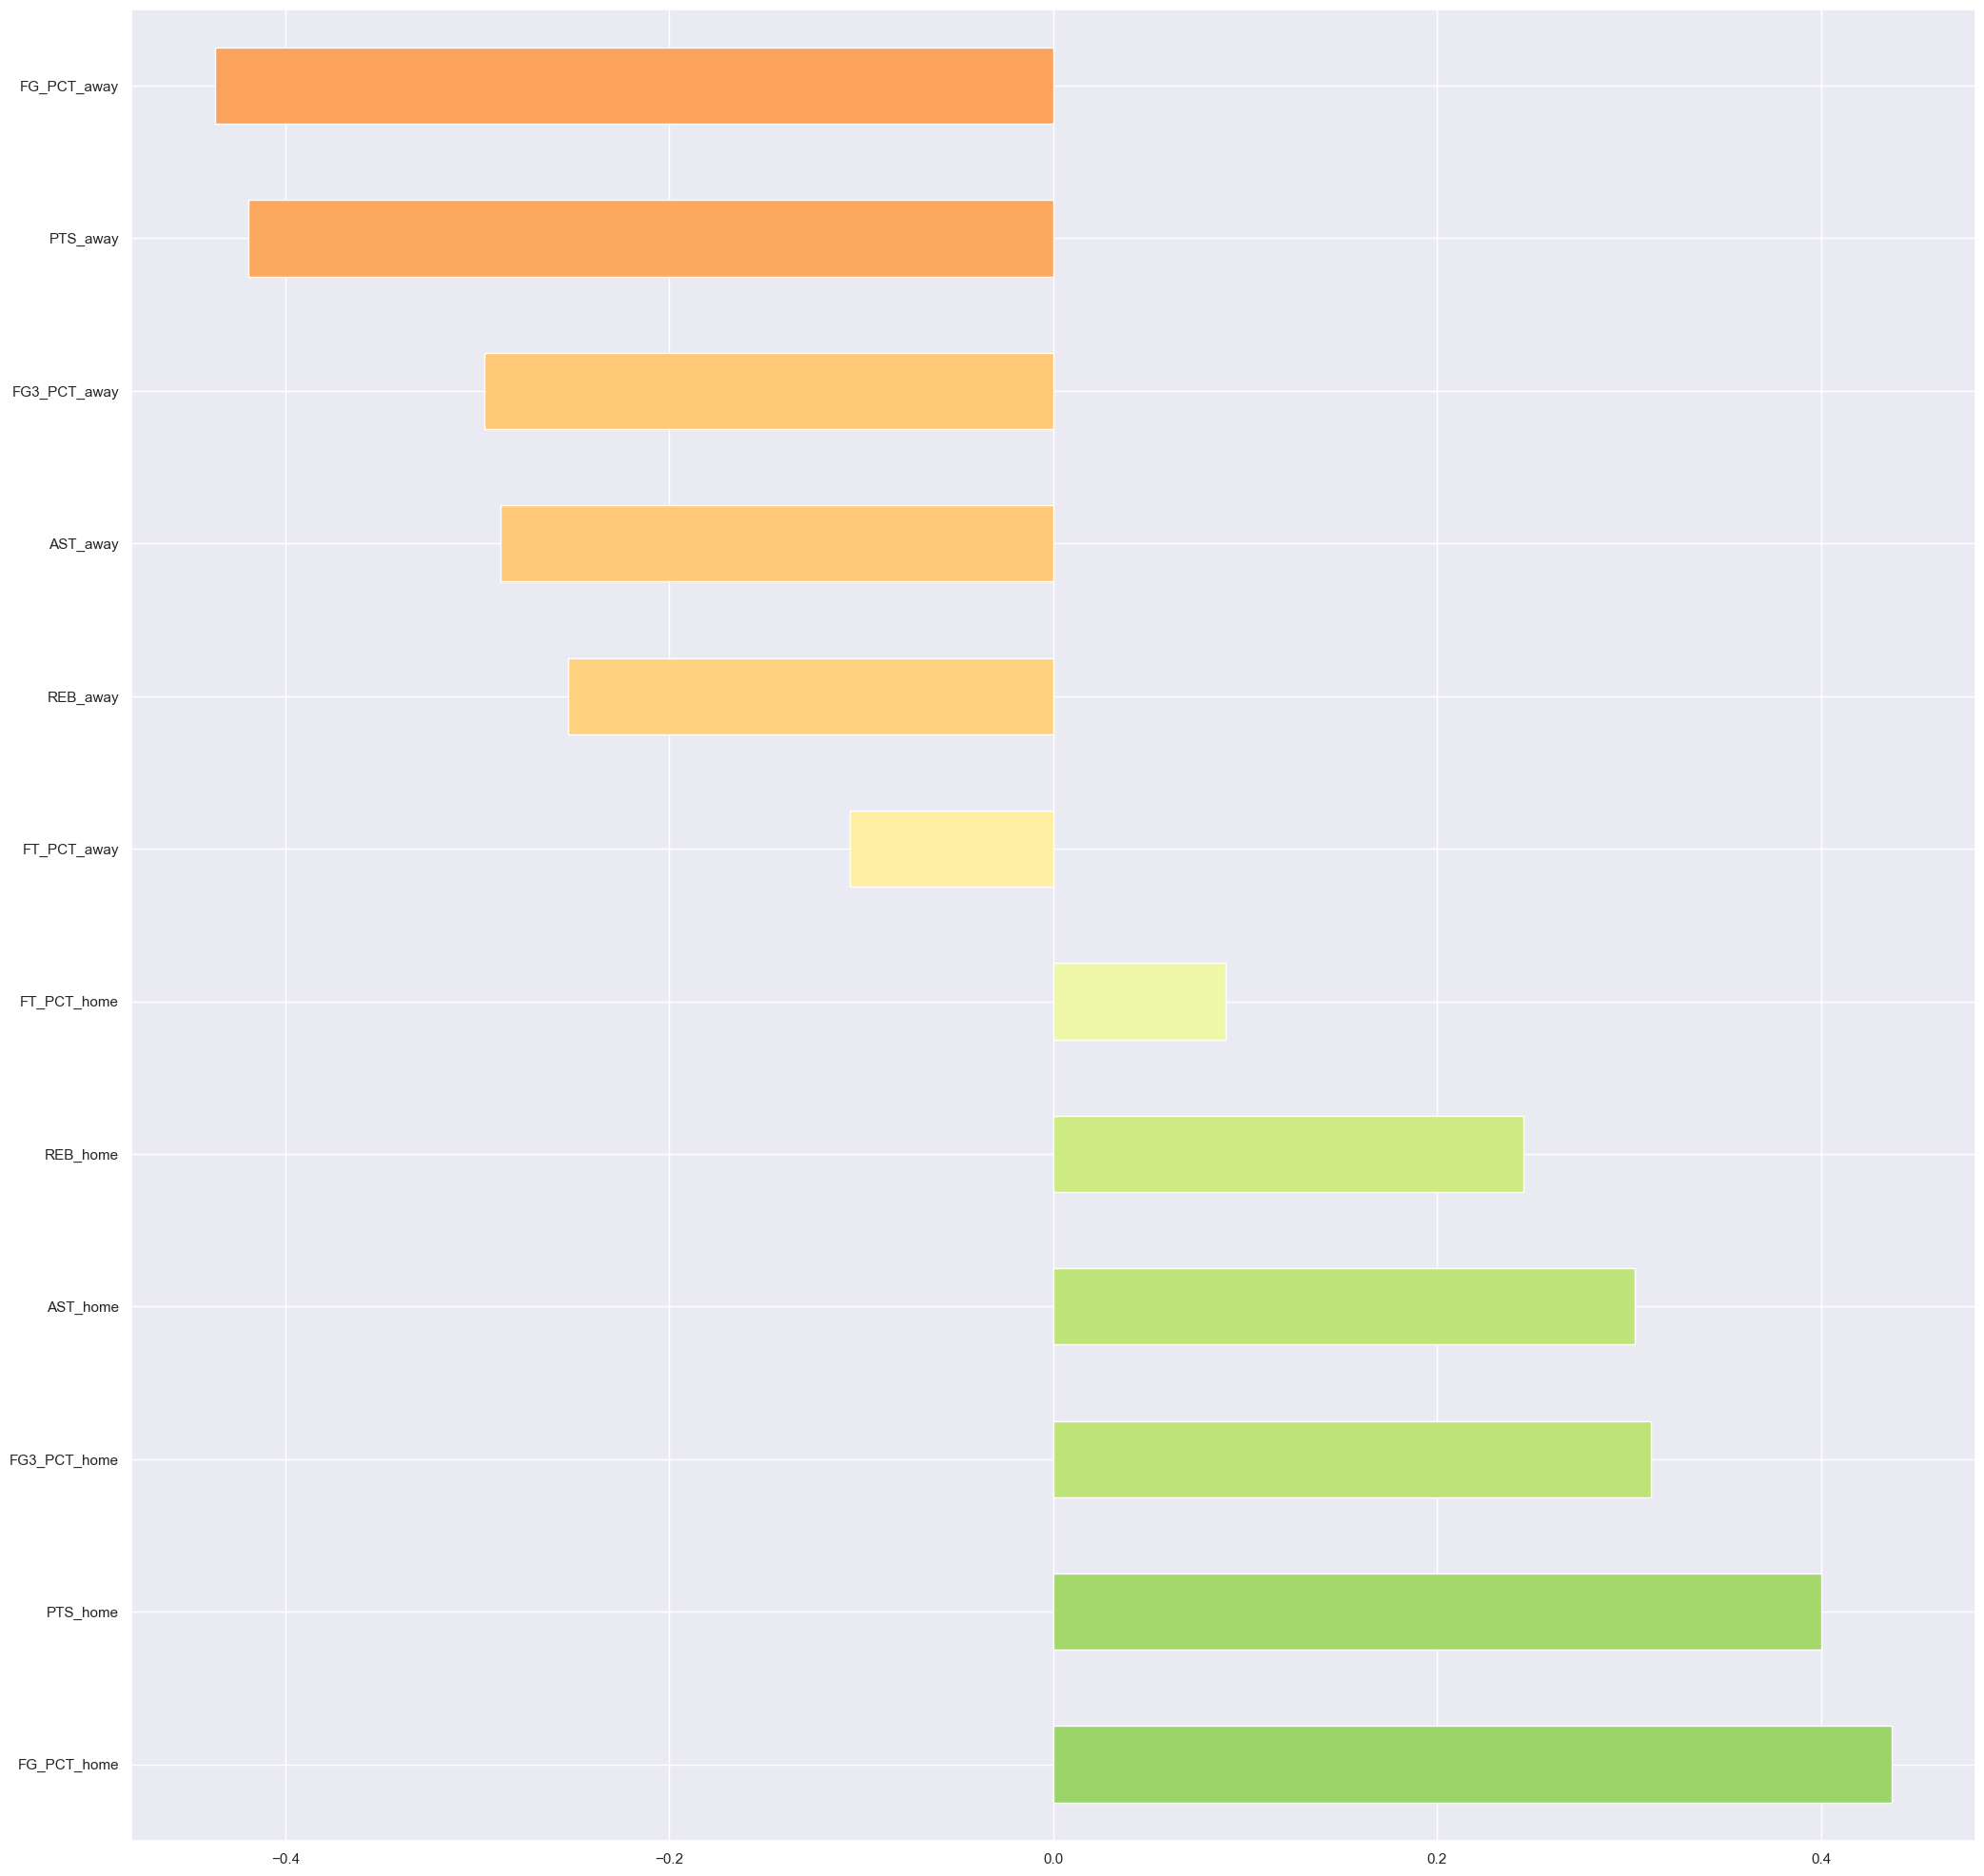

In [85]:
# correlations vs target
df1 = games.drop(columns=['GAME_ID', TARGET])
#df1[cat_cols] = OrdinalEncoder().fit_transform(df1[cat_cols])

x = df1.corrwith(games[TARGET], method = 'spearman').sort_values(ascending=False)

print(x)

colors = [plt.cm.RdYlGn(norm(c)) for c in x.values]
x.plot.barh(color=colors)

x_all = x

NOTE - FG_PCT more correlated with winning than PTS

### Correlations vs TARGET 2021 only

FG_PCT_home     0.505021
PTS_home        0.494156
FG3_PCT_home    0.390810
AST_home        0.360099
REB_home        0.307233
FT_PCT_home     0.104841
FT_PCT_away    -0.140544
REB_away       -0.304578
AST_away       -0.305828
FG3_PCT_away   -0.365179
FG_PCT_away    -0.460270
PTS_away       -0.498964
dtype: float64


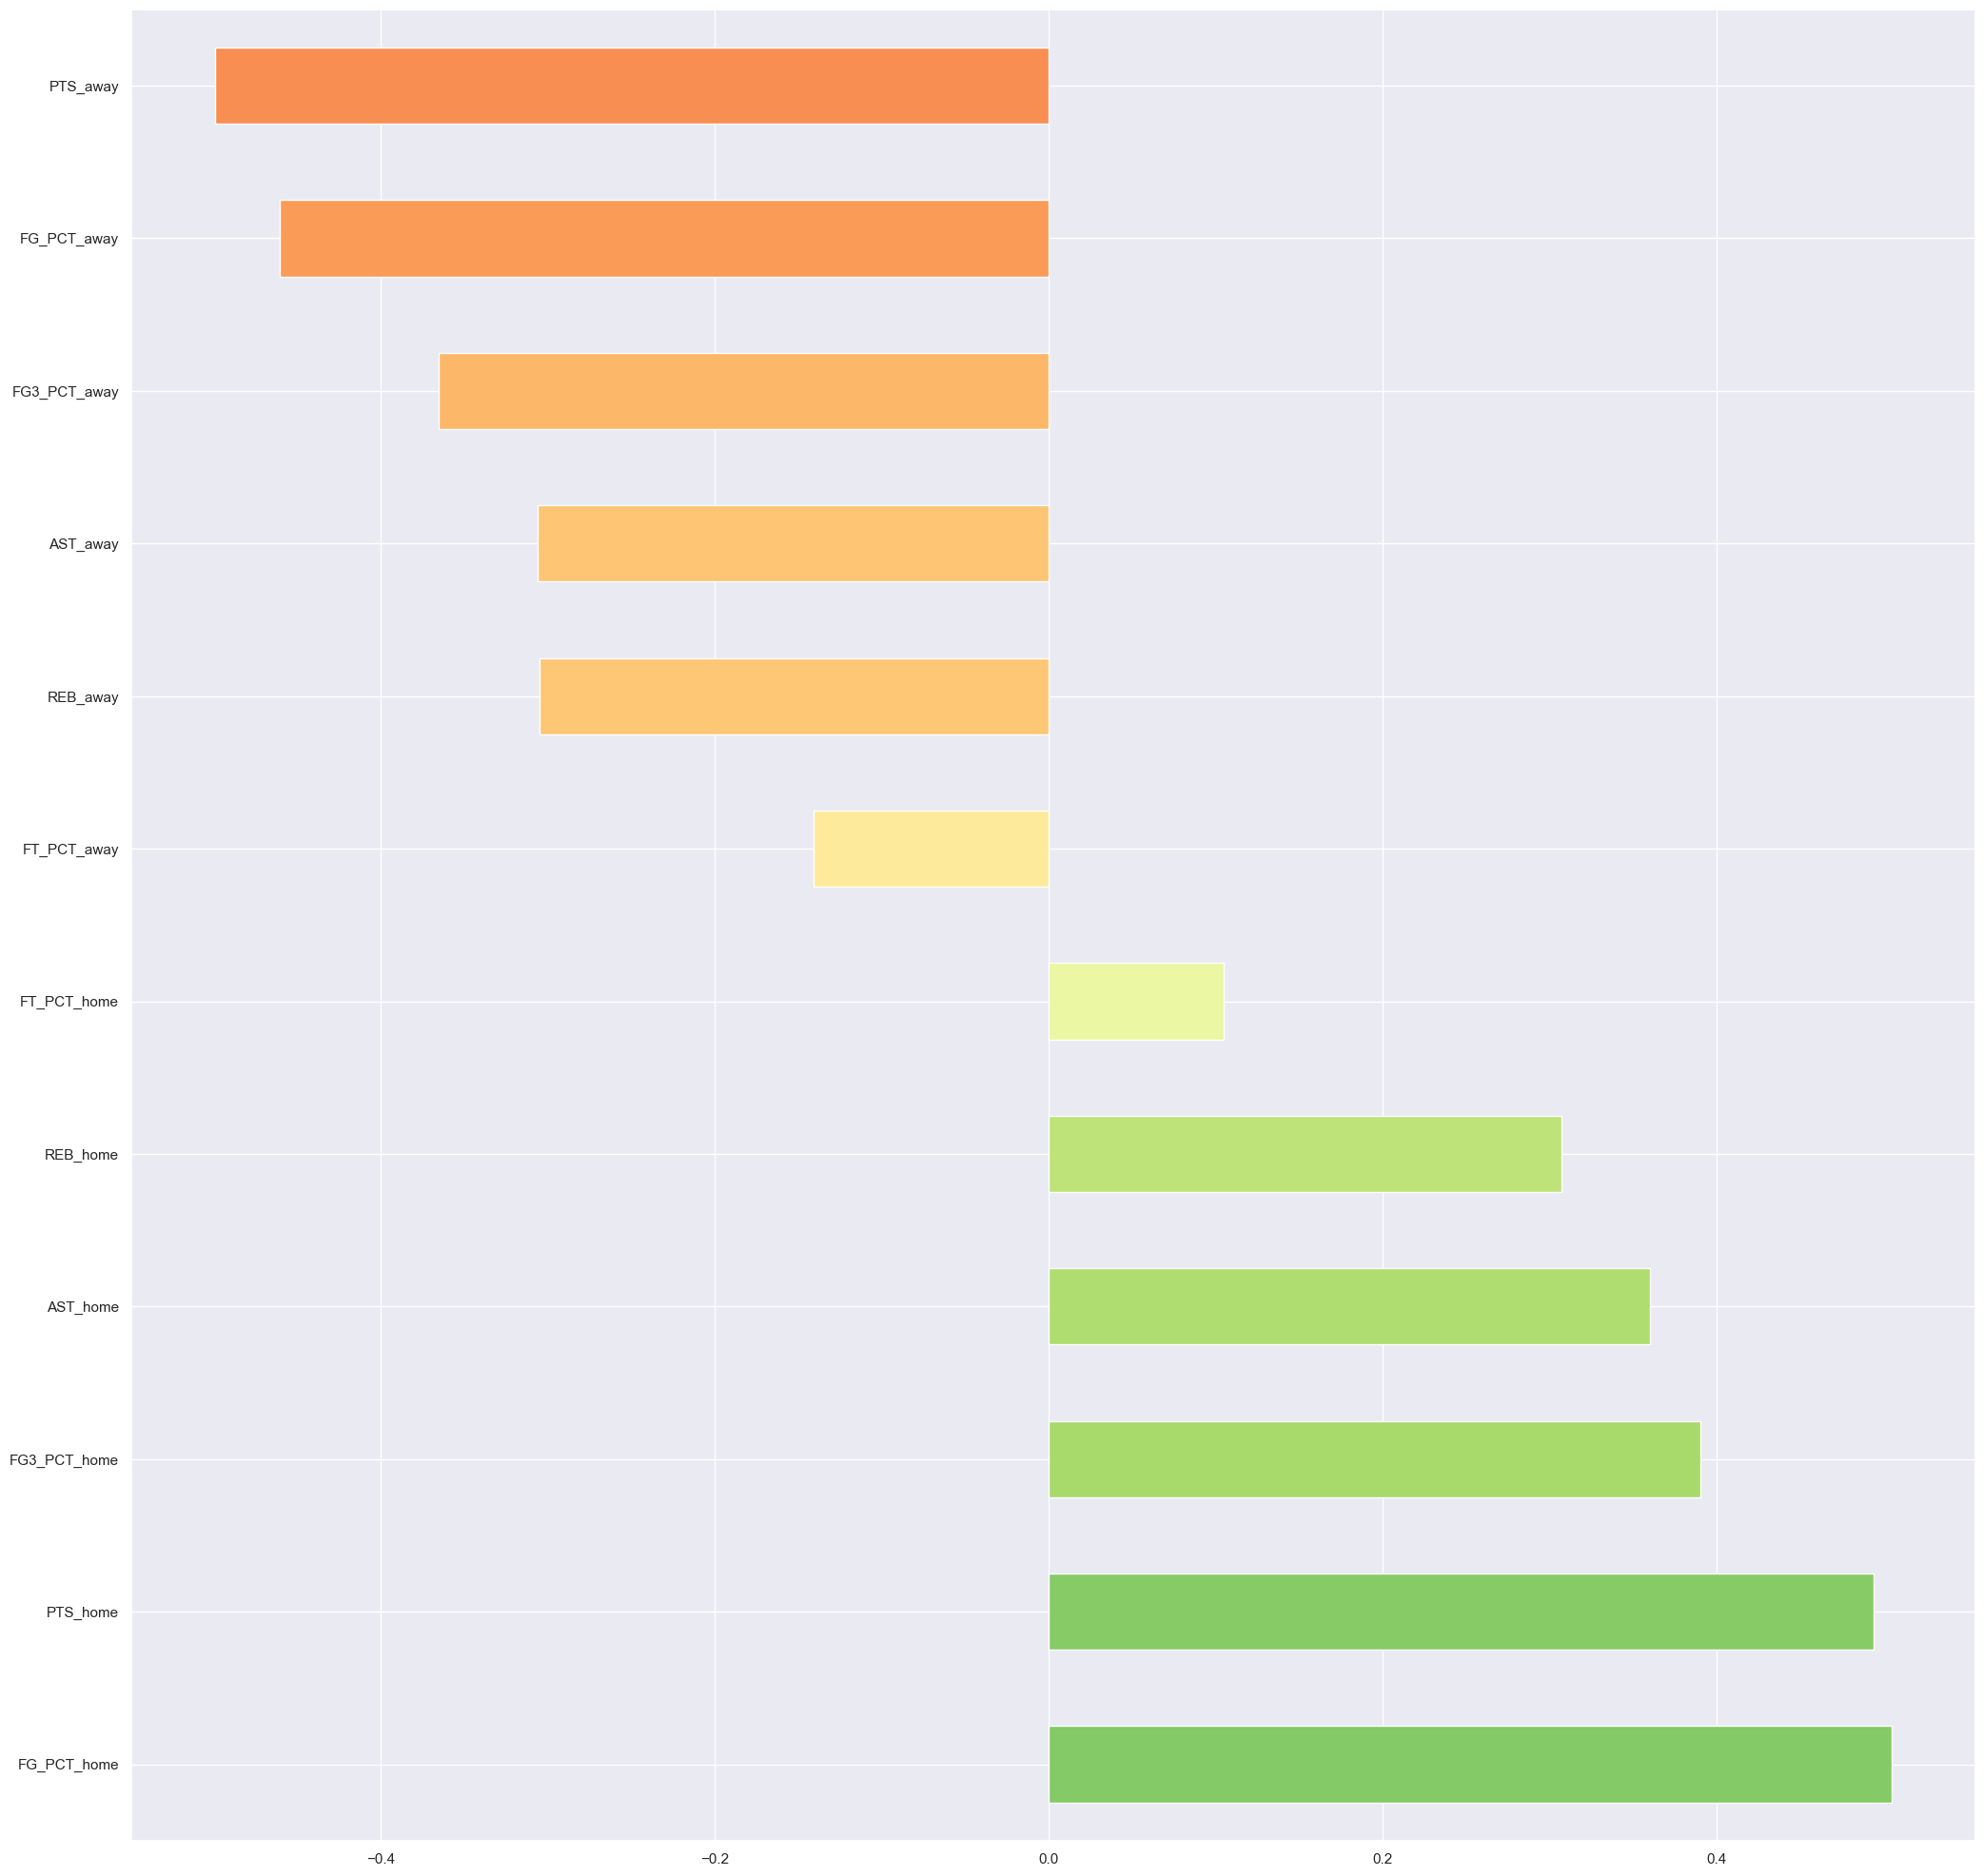

In [86]:
# correlations vs target
df1 = games.drop(columns=['GAME_ID', TARGET])
#df1[cat_cols] = OrdinalEncoder().fit_transform(df1[cat_cols])
df1 = df1[df1['SEASON']==2021]
targets = games[TARGET].loc[games['SEASON']==2021]

x = df1.corrwith(targets, method = 'spearman').sort_values(ascending=False)

print(x)

colors = [plt.cm.RdYlGn(norm(c)) for c in x.values]
x.plot.barh(color=colors)

x2021 = x

### Correlations vs TARGET (2017 thru 2021 composite)

PTS_home        0.470094
FG_PCT_home     0.456410
FG3_PCT_home    0.354337
AST_home        0.288228
REB_home        0.281476
FT_PCT_home     0.109760
FT_PCT_away    -0.118704
AST_away       -0.291190
REB_away       -0.313593
FG3_PCT_away   -0.342496
FG_PCT_away    -0.438324
PTS_away       -0.471843
dtype: float64


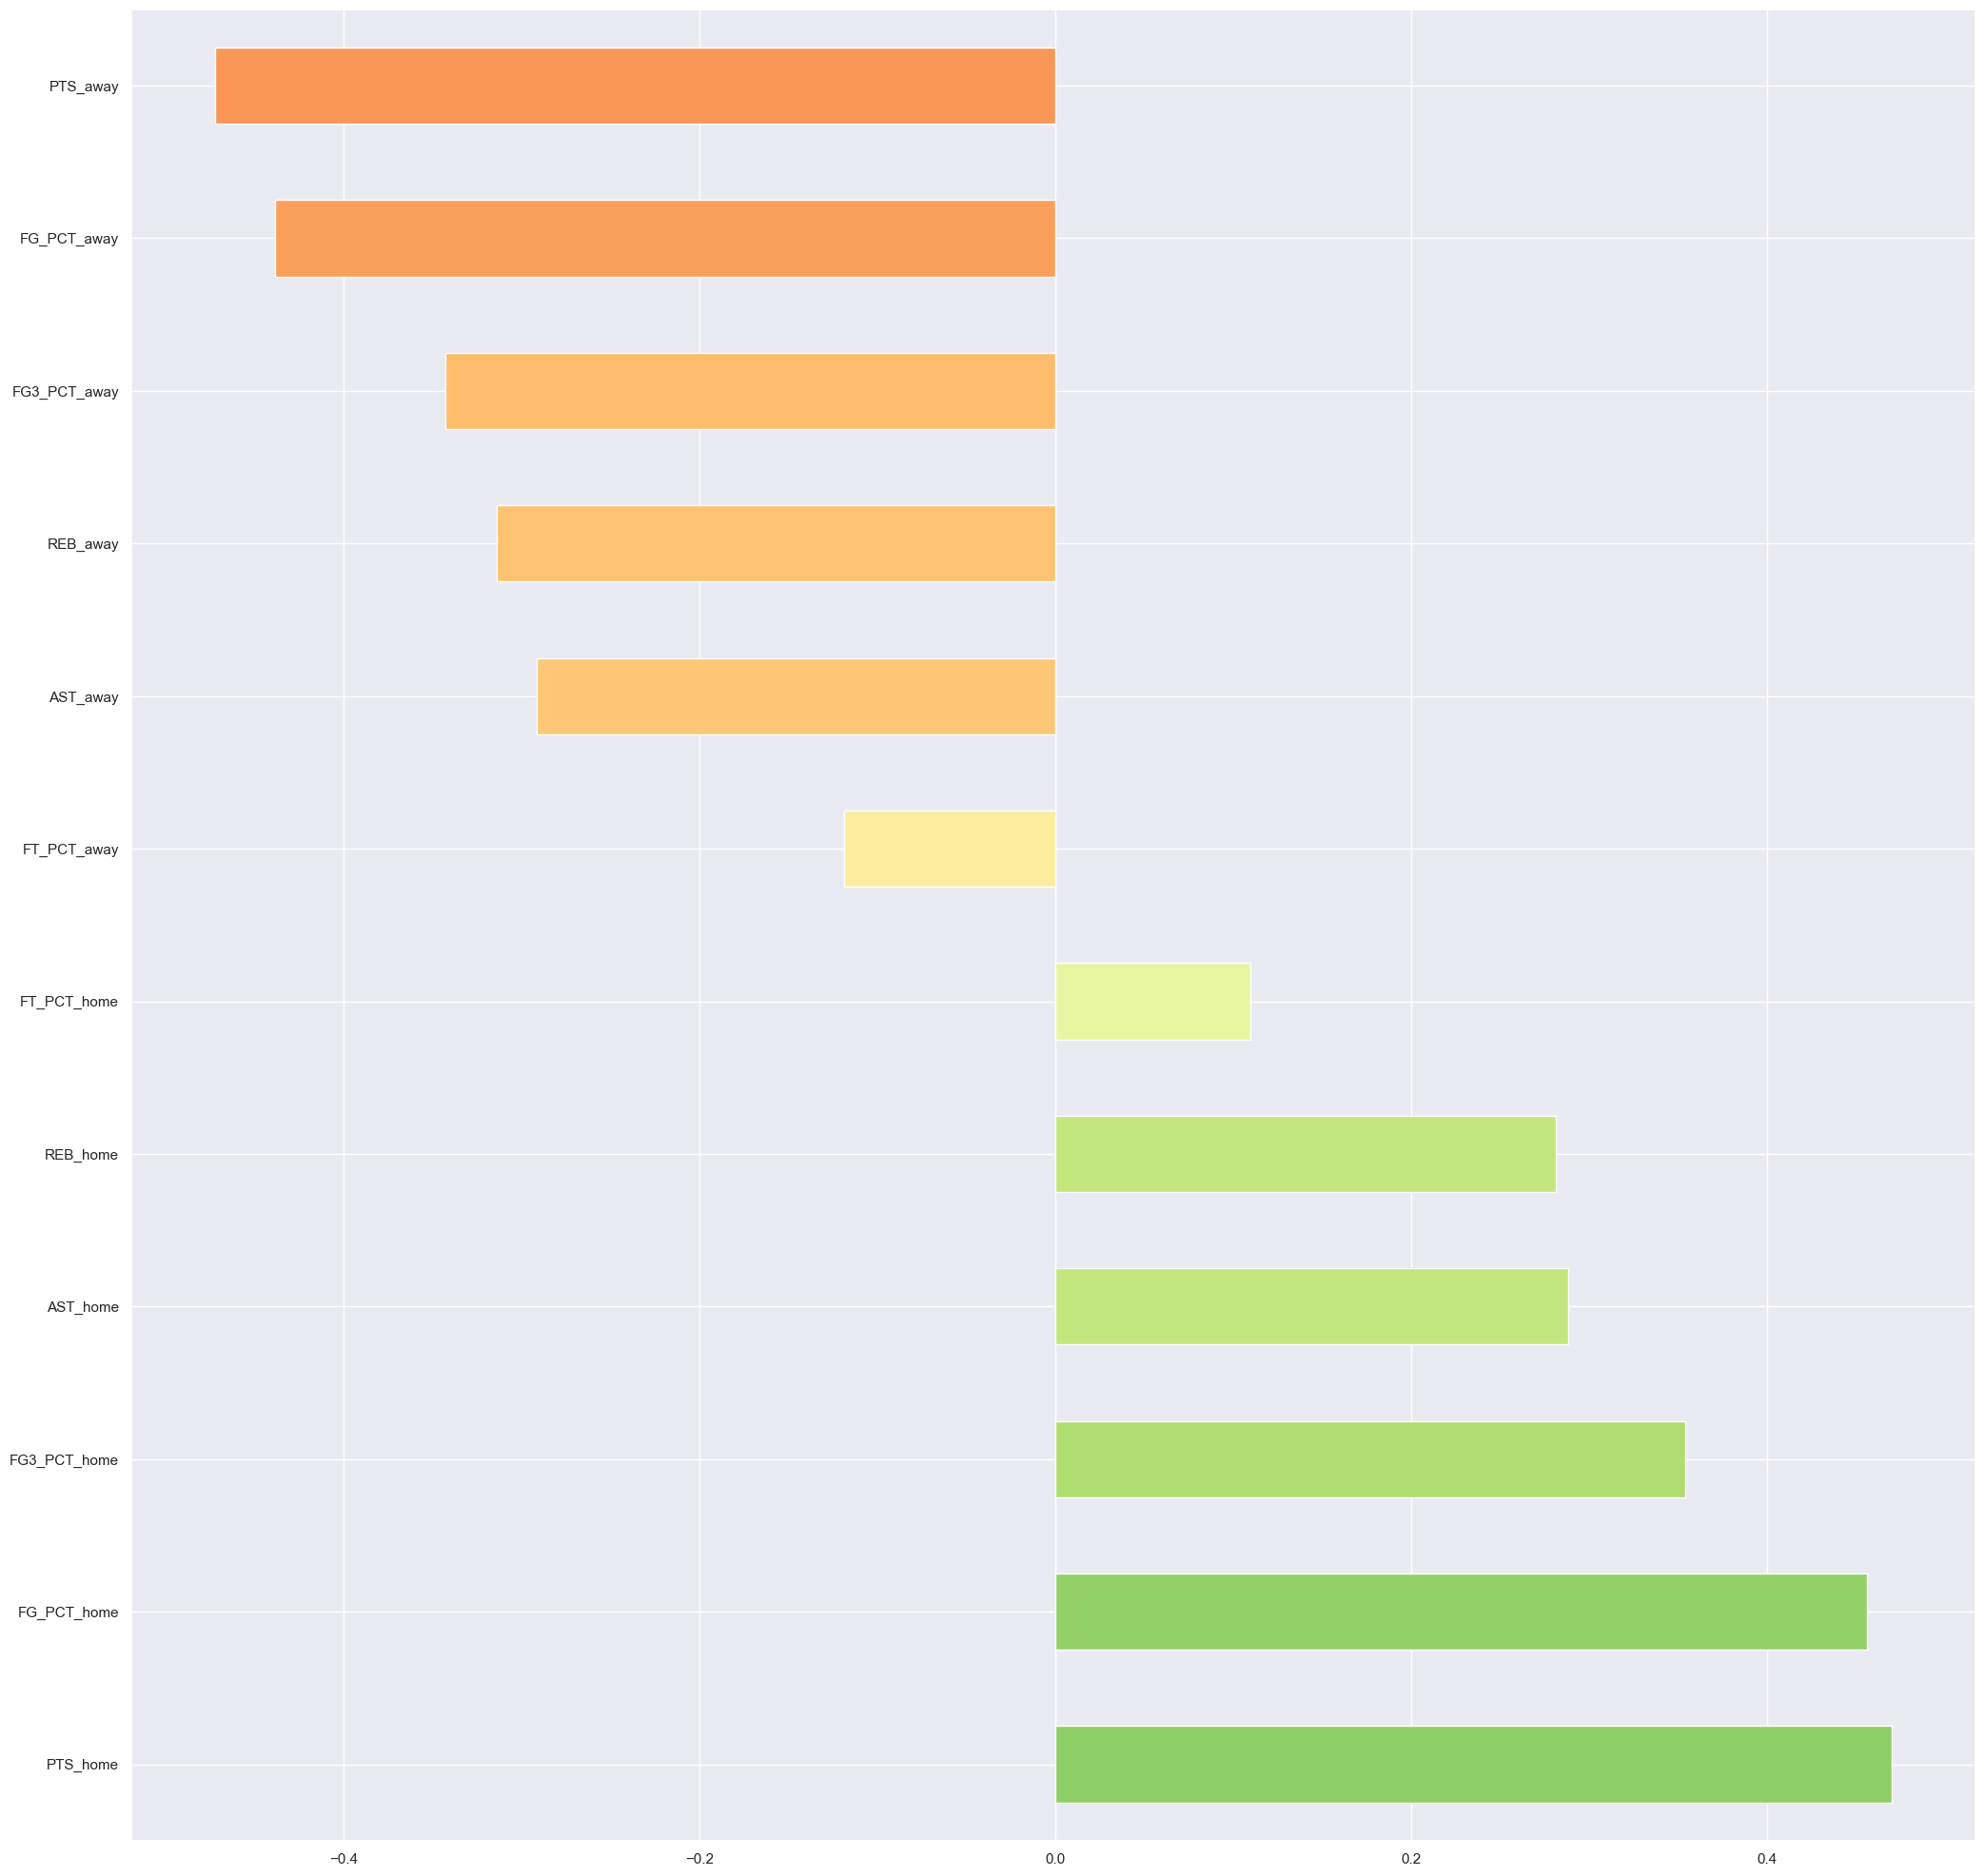

In [87]:
# correlations vs target
df1 = games.drop(columns=['GAME_ID', TARGET])
#df1[cat_cols] = OrdinalEncoder().fit_transform(df1[cat_cols])

df1 = df1[df1['SEASON'].astype(int) >2016]
targets = games[TARGET].loc[games['SEASON'].astype(int) >2016]

x = df1.corrwith(targets, method = 'spearman').sort_values(ascending=False)

print(x)

colors = [plt.cm.RdYlGn(norm(c)) for c in x.values]
x.plot.barh(color=colors)

x2017_2021 = x

### Correlation vs TARGET (All Seasons, Last 5 Seasons, Last Season)

           STATS     x_all  x2017_2021     x2021
0    FG_PCT_home  0.436742    0.456410  0.505021
1       PTS_home  0.400126    0.470094  0.494156
2   FG3_PCT_home  0.311429    0.354337  0.390810
3       AST_home  0.303158    0.288228  0.360099
4       REB_home  0.244826    0.281476  0.307233
5    FT_PCT_home  0.089880    0.109760  0.104841
6    FT_PCT_away -0.106141   -0.118704 -0.140544
7       REB_away -0.252744   -0.313593 -0.304578
8       AST_away -0.288199   -0.291190 -0.305828
9   FG3_PCT_away -0.296431   -0.342496 -0.365179
10      PTS_away -0.419197   -0.471843 -0.498964
11   FG_PCT_away -0.436554   -0.438324 -0.460270


<AxesSubplot: ylabel='STATS'>

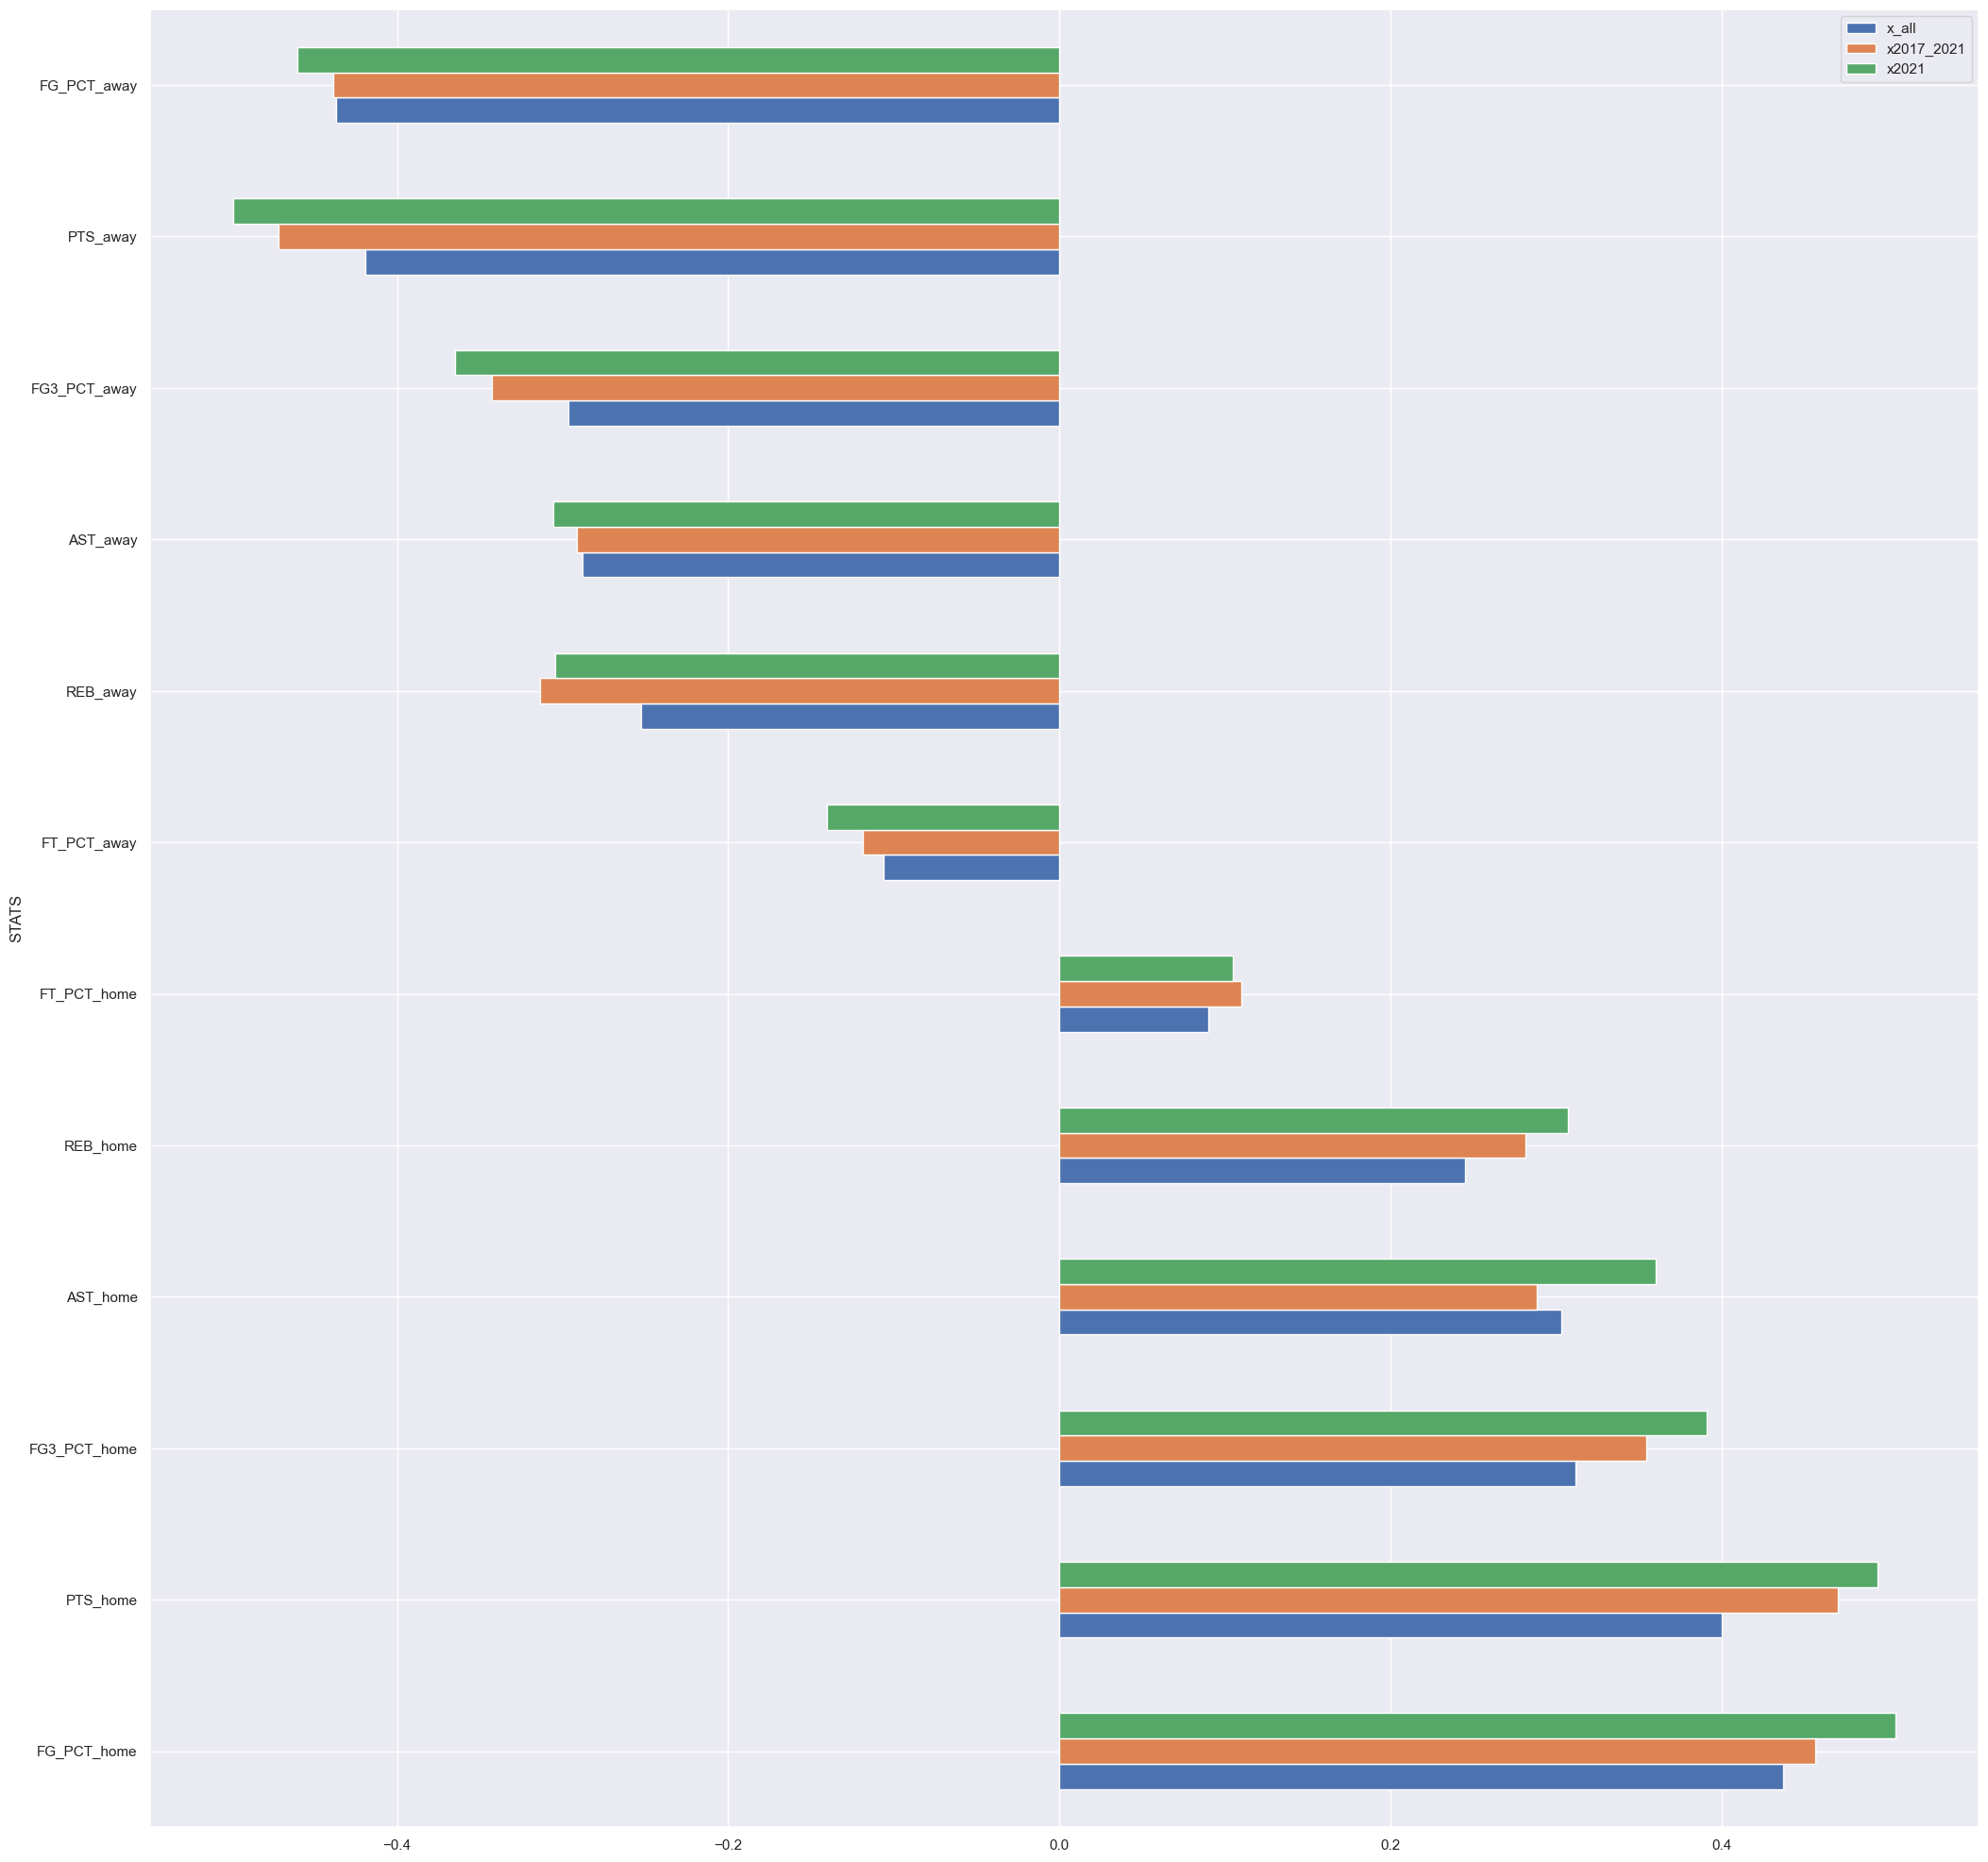

In [88]:
x = pd.concat([x_all, x2017_2021, x2021], axis=1).reset_index()
x = x.rename(columns={'index': 'STATS', 0: 'x_all', 1:'x2017_2021', 2:'x2021'})
print(x)

x.plot.barh(x='STATS')

NOTE - In recent seasons, the order for away teams changes: PTS_away > FG_PCT_away and REB_away > AST_away

###
# ranking.csv

This dataset contains an incremental daily record of the conference standings of each team as it changes each day of the season, updating with current stats such as: 
- games played
- games won
- games lost
- winning percentage
- home record
- road record


In [89]:
ranking = pd.read_csv(DATAPATH / "ranking.csv")
ranking.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612756,0,22021,2022-03-12,West,Phoenix,67,53,14,0.791,28-8,25-6,NaN
1,1610612744,0,22021,2022-03-12,West,Golden State,68,46,22,0.676,28-7,18-15,NaN
2,1610612763,0,22021,2022-03-12,West,Memphis,68,46,22,0.676,24-10,22-12,NaN
3,1610612762,0,22021,2022-03-12,West,Utah,67,42,25,0.627,24-10,18-15,NaN
4,1610612742,0,22021,2022-03-12,West,Dallas,67,41,26,0.612,23-12,18-14,NaN


In [90]:
ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201792 entries, 0 to 201791
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TEAM_ID        201792 non-null  int64  
 1   LEAGUE_ID      201792 non-null  int64  
 2   SEASON_ID      201792 non-null  int64  
 3   STANDINGSDATE  201792 non-null  object 
 4   CONFERENCE     201792 non-null  object 
 5   TEAM           201792 non-null  object 
 6   G              201792 non-null  int64  
 7   W              201792 non-null  int64  
 8   L              201792 non-null  int64  
 9   W_PCT          201792 non-null  float64
 10  HOME_RECORD    201792 non-null  object 
 11  ROAD_RECORD    201792 non-null  object 
 12  RETURNTOPLAY   3990 non-null    float64
dtypes: float64(2), int64(6), object(5)
memory usage: 20.0+ MB


###
### Check for duplicates and nulls

In [91]:
# duplicates
ranking.duplicated().sum()

0

In [92]:
#null values
ranking.isnull().sum()

TEAM_ID               0
LEAGUE_ID             0
SEASON_ID             0
STANDINGSDATE         0
CONFERENCE            0
TEAM                  0
G                     0
W                     0
L                     0
W_PCT                 0
HOME_RECORD           0
ROAD_RECORD           0
RETURNTOPLAY     197802
dtype: int64

In [93]:
# most rows have nulls in RETURNTOPLAY
# look at those that do not
ranking[ranking['RETURNTOPLAY'].notnull()]

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
17999,1610612749,0,22019,2020-12-10,East,Milwaukee,73,56,17,0.767,30-5,26-12,1.0
18000,1610612761,0,22019,2020-12-10,East,Toronto,72,53,19,0.736,26-10,27-9,1.0
18001,1610612738,0,22019,2020-12-10,East,Boston,72,48,24,0.667,26-10,22-14,1.0
18002,1610612754,0,22019,2020-12-10,East,Indiana,73,45,28,0.616,25-11,20-17,1.0
18003,1610612748,0,22019,2020-12-10,East,Miami,73,44,29,0.603,29-7,15-22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22104,1610612741,0,22019,2020-03-12,East,Chicago,65,22,43,0.338,14-20,8-23,0.0
22105,1610612752,0,22019,2020-03-12,East,New York,66,21,45,0.318,11-22,10-23,0.0
22106,1610612765,0,22019,2020-03-12,East,Detroit,66,20,46,0.303,11-22,9-24,0.0
22107,1610612737,0,22019,2020-03-12,East,Atlanta,67,20,47,0.299,14-20,6-27,0.0


In [94]:
ranking[ranking['RETURNTOPLAY'] == 1]

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
17999,1610612749,0,22019,2020-12-10,East,Milwaukee,73,56,17,0.767,30-5,26-12,1.0
18000,1610612761,0,22019,2020-12-10,East,Toronto,72,53,19,0.736,26-10,27-9,1.0
18001,1610612738,0,22019,2020-12-10,East,Boston,72,48,24,0.667,26-10,22-14,1.0
18002,1610612754,0,22019,2020-12-10,East,Indiana,73,45,28,0.616,25-11,20-17,1.0
18003,1610612748,0,22019,2020-12-10,East,Miami,73,44,29,0.603,29-7,15-22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22098,1610612754,0,22019,2020-03-12,East,Indiana,65,39,26,0.600,21-11,18-15,1.0
22099,1610612755,0,22019,2020-03-12,East,Philadelphia,65,39,26,0.600,29-2,10-24,1.0
22100,1610612751,0,22019,2020-03-12,East,Brooklyn,64,30,34,0.469,18-14,12-20,1.0
22101,1610612753,0,22019,2020-03-12,East,Orlando,65,30,35,0.462,16-15,14-20,1.0


In [95]:
ranking[ranking['RETURNTOPLAY'] == 0]

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
18008,1610612766,0,22019,2020-12-10,East,Charlotte,65,23,42,0.354,10-21,13-21,0.0
18009,1610612741,0,22019,2020-12-10,East,Chicago,65,22,43,0.338,14-20,8-23,0.0
18010,1610612752,0,22019,2020-12-10,East,New York,66,21,45,0.318,11-22,10-23,0.0
18011,1610612765,0,22019,2020-12-10,East,Detroit,66,20,46,0.303,11-22,9-24,0.0
18012,1610612737,0,22019,2020-12-10,East,Atlanta,67,20,47,0.299,14-20,6-27,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22104,1610612741,0,22019,2020-03-12,East,Chicago,65,22,43,0.338,14-20,8-23,0.0
22105,1610612752,0,22019,2020-03-12,East,New York,66,21,45,0.318,11-22,10-23,0.0
22106,1610612765,0,22019,2020-03-12,East,Detroit,66,20,46,0.303,11-22,9-24,0.0
22107,1610612737,0,22019,2020-03-12,East,Atlanta,67,20,47,0.299,14-20,6-27,0.0


In [96]:
# are any in west conference?
df = ranking[ranking['RETURNTOPLAY'].notnull()]
df[df['CONFERENCE'] == 'West'].shape[0]

0

NOTE - Not sure what RETURNTOPLAY means, but it is limited to East Conference stats between 2020-03-12 and 2020-12-10, and is probably of almost no utility at the moment

In [97]:
# any LEAGUE_ID not 0?
ranking[ranking['LEAGUE_ID'] != 0].shape[0]

0

NOTE - LEAGUE_ID always 0, can drop

In [98]:
#these fields not needed for processing, analysis, or modeling

drop_fields = ['LEAGUE_ID', 'RETURNTOPLAY', 'TEAM']

#ranking = ranking.drop(drop_fields,axis=1)

###
### Describe the data


In [99]:
# fix data types first

ranking['STANDINGSDATE'] = ranking['STANDINGSDATE'].astype('datetime64[ns]')

category_fields = ['TEAM_ID', 'CONFERENCE', 'SEASON_ID']

for cat in category_fields:
    ranking[cat] = ranking[cat].astype('category')

In [100]:
ranking.describe(include = 'category').T

,count,unique,top,freq
TEAM_ID,201792,30,1610612760,6742
SEASON_ID,201792,39,22010,12480
CONFERENCE,201792,2,East,101083


In [101]:
# why 39 SEASON_IDs?
ranking['SEASON_ID'].value_counts()

22010    12480
22019    12240
22018    10470
22017    10380
22004    10260
22009    10230
22007    10230
22006    10200
22015    10200
22016    10200
22013    10200
22012    10200
22014    10170
22003    10150
22005    10140
22008    10140
22020     8573
22011     8550
22021     4350
12019      900
12006      780
12009      780
12012      750
12015      750
12016      720
12007      720
12013      720
12014      720
12008      690
12010      690
12003      667
12005      660
12004      630
12018      540
12017      510
12021      480
12020      336
12011      270
22002      116
Name: SEASON_ID, dtype: int64

In [102]:
ranking[(ranking['SEASON_ID']==12021) & (ranking['G'] > 0)]

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
3900,1610612744,0,12021,2021-10-18,West,Golden State,5,5,0,1.00,3-0,2-0,NaN
3901,1610612742,0,12021,2021-10-18,West,Dallas,4,4,0,1.00,2-0,2-0,NaN
3902,1610612758,0,12021,2021-10-18,West,Sacramento,4,4,0,1.00,2-0,2-0,NaN
3903,1610612750,0,12021,2021-10-18,West,Minnesota,4,3,1,0.75,1-0,2-1,NaN
3904,1610612756,0,12021,2021-10-18,West,Phoenix,4,3,1,0.75,2-0,1-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6739,1610612761,0,12021,2021-10-04,East,Toronto,1,1,0,1.00,1-0,0-0,NaN
6740,1610612737,0,12021,2021-10-04,East,Atlanta,1,0,1,0.00,0-0,0-1,NaN
6741,1610612753,0,12021,2021-10-04,East,Orlando,1,0,1,0.00,0-0,0-1,NaN
6742,1610612755,0,12021,2021-10-04,East,Philadelphia,1,0,1,0.00,0-0,0-1,NaN


In [103]:
df = ranking[(ranking['SEASON_ID']==12021)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LEAGUE_ID,480.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
G,480.0,2.670833,1.542706,0.0,1.0,3.0,4.0,6.0
W,480.0,1.335417,1.245449,0.0,0.0,1.0,2.0,5.0
L,480.0,1.335417,1.310785,0.0,0.0,1.0,2.0,6.0
W_PCT,480.0,0.468390,0.392305,0.0,0.0,0.5,1.0,1.0
RETURNTOPLAY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NOTE - SEASON_ID beginning with 1 appears to be preseason games

In [104]:
#flag preseaon stats
ranking['PRESEASON'] = ((ranking['SEASON_ID'].astype('int') < 20000).astype('int')).astype('category')
ranking

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,PRESEASON
0,1610612756,0,22021,2022-03-12,West,Phoenix,67,53,14,0.791,28-8,25-6,NaN,0
1,1610612744,0,22021,2022-03-12,West,Golden State,68,46,22,0.676,28-7,18-15,NaN,0
2,1610612763,0,22021,2022-03-12,West,Memphis,68,46,22,0.676,24-10,22-12,NaN,0
3,1610612762,0,22021,2022-03-12,West,Utah,67,42,25,0.627,24-10,18-15,NaN,0
4,1610612742,0,22021,2022-03-12,West,Dallas,67,41,26,0.612,23-12,18-14,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201787,1610612765,0,22013,2014-09-01,East,Detroit,82,29,53,0.354,17-24,12-29,NaN,0
201788,1610612738,0,22013,2014-09-01,East,Boston,82,25,57,0.305,16-25,9-32,NaN,0
201789,1610612753,0,22013,2014-09-01,East,Orlando,82,23,59,0.280,19-22,4-37,NaN,0
201790,1610612755,0,22013,2014-09-01,East,Philadelphia,82,19,63,0.232,10-31,9-32,NaN,0


In [105]:
#home record and road record need to be converted to numeric

ranking['HOME_W'] = ranking['HOME_RECORD'].apply(lambda x: x.split('-')[0]).astype('int')
ranking['HOME_L'] = ranking['HOME_RECORD'].apply(lambda x: x.split('-')[1]).astype('int')
ranking['HOME_W_PCT'] = ranking['HOME_W'] / ( ranking['HOME_W'] + ranking['HOME_L'] )

ranking['ROAD_W'] = ranking['ROAD_RECORD'].apply(lambda x: x.split('-')[0]).astype('int')
ranking['ROAD_L'] = ranking['ROAD_RECORD'].apply(lambda x: x.split('-')[1]).astype('int')
ranking['ROAD_W_PCT'] = ranking['ROAD_W'] / ( ranking['ROAD_W'] + ranking['ROAD_L'] )


In [106]:
df = ranking[ranking['PRESEASON']==0]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LEAGUE_ID,189479.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
G,189479.0,59.942738,25.844127,0.0,40.000000,72.000000,82.000000,82.0
W,189479.0,29.971306,16.320506,0.0,17.000000,30.000000,42.000000,73.0
L,189479.0,29.971432,16.298239,0.0,17.000000,30.000000,41.000000,72.0
W_PCT,189479.0,0.498377,0.170209,0.0,0.382000,0.500000,0.618000,1.0
RETURNTOPLAY,3990.0,0.600000,0.489959,0.0,0.000000,1.000000,1.000000,1.0
HOME_W,189479.0,17.667092,9.518633,0.0,10.000000,18.000000,25.000000,40.0
HOME_L,189479.0,12.304266,7.632834,0.0,6.000000,11.000000,18.000000,34.0
HOME_W_PCT,188155.0,0.587867,0.192320,0.0,0.461538,0.600000,0.729730,1.0
ROAD_W,189479.0,12.304213,7.338667,0.0,7.000000,12.000000,18.000000,34.0


## Validation

In [107]:
# check that key fields are always increasing since they represent running totals

df = ranking[ranking['PRESEASON']==0]

seasons = df["SEASON_ID"].unique().to_list()
teams = df["TEAM_ID"].unique().to_list()
fields = ['G','W','L','HOME_W','HOME_L','ROAD_W','ROAD_L'] 

for season in seasons:
    for team in teams:
        df = ranking[(ranking['SEASON_ID'] == season) & (ranking['TEAM_ID'] == team)]
        df = df.set_index('STANDINGSDATE')
        df = df.sort_index(ascending=True)
        
        for field in fields:
            increasing = df[field].is_monotonic_increasing
            if not(increasing):
                print("Not increasing:", season, team, field)



In [108]:
#sample 5 records to validate against historical record on google

df = ranking[ranking['PRESEASON']==0]
df.sample(n=5)

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,PRESEASON,HOME_W,HOME_L,HOME_W_PCT,ROAD_W,ROAD_L,ROAD_W_PCT
199861,1610612739,0,22014,2015-01-07,East,Cleveland,36,19,17,0.528,11-9,8-8,NaN,0,11,9,0.550000,8,8,0.500000
145725,1610612739,0,22007,2008-09-22,East,Cleveland,82,45,37,0.549,27-14,18-23,NaN,0,27,14,0.658537,18,23,0.439024
151049,1610612741,0,22006,2007-10-03,East,Chicago,82,49,33,0.598,31-10,18-23,NaN,0,31,10,0.756098,18,23,0.439024
10255,1610612764,0,22020,2021-04-19,East,Washington,57,24,33,0.421,13-16,11-17,NaN,0,13,16,0.448276,11,17,0.392857
132836,1610612739,0,22010,2011-01-30,East,Cleveland,47,8,39,0.170,5-15,3-24,NaN,0,5,15,0.250000,3,24,0.111111


In [109]:
#saved output
#verified at: https://www.basketball-reference.com/leagues/NBA_2012_standings_by_date_eastern_conference.html

#TEAM_ID	LEAGUE_ID	SEASON_ID	STANDINGSDATE	CONFERENCE	TEAM	G	W	L	W_PCT	HOME_RECORD	ROAD_RECORD	RETURNTOPLAY	PRESEASON	HOME_W	HOME_L	HOME_W_PCT	ROAD_W	ROAD_L	ROAD_W_PCT
#95703	1610612757	0	22017	2017-11-09	West	Portland	11	6	5	0.545	4-3	2-2	NaN	0	4	3	0.571429	2	2	0.500000
#127548	1610612739	0	22011	2012-01-17	East	Cleveland	13	6	7	0.462	2-2	4-5	NaN	0	2	2	0.500000	4	5	0.444444
#124706	1610612766	0	22011	2012-07-25	East	Charlotte	66	7	59	0.106	4-29	3-30	NaN	0	4	29	0.121212	3	30	0.090909
#179631	1610612766	0	22017	2018-09-17	East	Charlotte	82	36	46	0.439	21-20	15-26	NaN	0	21	20	0.512195	15	26	0.365854
#45342	1610612758	0	22010	2010-12-12	West	Sacramento	21	5	16	0.238	3-10	2-6	NaN	0	3	10	0.230769	2	6	0.250000


In [110]:
# make sure each date only has data for 30 teams
# from the later merge process in data processing, there appears to be an issue
df = ranking.groupby(['STANDINGSDATE']).count()
df = df.reset_index()
df
df[df['TEAM_ID'] > 30]

,STANDINGSDATE,TEAM_ID,LEAGUE_ID,SEASON_ID,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,PRESEASON,HOME_W,HOME_L,HOME_W_PCT,ROAD_W,ROAD_L,ROAD_W_PCT
6290,2020-12-20,33,33,33,33,33,33,33,33,33,33,33,0,33,33,33,33,33,33,33
6291,2020-12-21,33,33,33,33,33,33,33,33,33,33,33,0,33,33,33,33,33,33,33
6297,2020-12-27,36,36,36,36,36,36,36,36,36,36,36,0,36,36,36,29,36,36,31
6298,2020-12-28,38,38,38,38,38,38,38,38,38,38,38,0,38,38,38,33,38,38,34
6299,2020-12-29,35,35,35,35,35,35,35,35,35,35,35,0,35,35,35,31,35,35,34
6300,2020-12-30,31,31,31,31,31,31,31,31,31,31,31,0,31,31,31,29,31,31,31
6301,2020-12-31,31,31,31,31,31,31,31,31,31,31,31,0,31,31,31,30,31,31,31
6302,2021-01-01,32,32,32,32,32,32,32,32,32,32,32,0,32,32,32,32,32,32,32


In [111]:
df = ranking[ranking['STANDINGSDATE'] == '2020-12-28']
df['TEAM_ID'].value_counts()

1610612752    2
1610612743    2
1610612763    2
1610612738    2
1610612749    2
1610612744    2
1610612766    2
1610612742    2
1610612756    1
1610612765    1
1610612764    1
1610612739    1
1610612762    1
1610612761    1
1610612760    1
1610612759    1
1610612758    1
1610612757    1
1610612755    1
1610612745    1
1610612754    1
1610612753    1
1610612740    1
1610612751    1
1610612750    1
1610612741    1
1610612748    1
1610612747    1
1610612746    1
1610612737    1
Name: TEAM_ID, dtype: int64

In [112]:
df[df['TEAM_ID'] == 1610612752]

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,PRESEASON,HOME_W,HOME_L,HOME_W_PCT,ROAD_W,ROAD_L,ROAD_W_PCT
10945,1610612752,0,22020,2020-12-28,East,New York,3,1,2,0.333,1-1,0-1,NaN,0,1,1,0.5,0,1,0.0
13462,1610612752,0,22020,2020-12-28,East,New York,3,1,2,0.333,1-1,0-1,NaN,0,1,1,0.5,0,1,0.0


In [113]:
df = df[df['TEAM_ID'] == 1610612752]
df.duplicated()

10945    False
13462    False
dtype: bool

NOTE - Duplicates exist, pandas appears not to recognize them as duplicates

###
## game_details.csv

In [114]:
details = pd.read_csv(DATAPATH / "games_details.csv")
details

C:\Users\Chris\AppData\Local\Temp\ipykernel_10164\1440549475.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  details = pd.read_csv(DATAPATH / "games_details.csv")


,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22101005,1610612750,MIN,Minnesota,1630162,Anthony Edwards,Anthony,F,NaN,36:22,4.0,10.0,0.400,3.0,8.0,0.375,4.0,4.0,1.000,0.0,8.0,8.0,5.0,3.0,1.0,1.0,1.0,15.0,5.0
1,22101005,1610612750,MIN,Minnesota,1630183,Jaden McDaniels,Jaden,F,NaN,23:54,6.0,8.0,0.750,1.0,3.0,0.333,1.0,1.0,1.000,2.0,4.0,6.0,0.0,0.0,2.0,2.0,6.0,14.0,10.0
2,22101005,1610612750,MIN,Minnesota,1626157,Karl-Anthony Towns,Karl-Anthony,C,NaN,25:17,4.0,9.0,0.444,1.0,3.0,0.333,6.0,8.0,0.750,1.0,9.0,10.0,0.0,0.0,0.0,3.0,4.0,15.0,14.0
3,22101005,1610612750,MIN,Minnesota,1627736,Malik Beasley,Malik,G,NaN,30:52,4.0,9.0,0.444,4.0,9.0,0.444,0.0,0.0,0.000,0.0,3.0,3.0,1.0,1.0,0.0,1.0,4.0,12.0,20.0
4,22101005,1610612750,MIN,Minnesota,1626156,D'Angelo Russell,D'Angelo,G,NaN,33:46,3.0,13.0,0.231,1.0,6.0,0.167,7.0,7.0,1.000,0.0,6.0,6.0,9.0,1.0,0.0,5.0,0.0,14.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645948,11200005,1610612743,DEN,Denver,202706,Jordan Hamilton,NaN,NaN,NaN,19,4.0,9.0,0.444,3.0,6.0,0.500,6.0,7.0,0.857,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0,NaN
645949,11200005,1610612743,DEN,Denver,202702,Kenneth Faried,NaN,NaN,NaN,23,7.0,11.0,0.636,0.0,0.0,0.000,4.0,4.0,1.000,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0,NaN
645950,11200005,1610612743,DEN,Denver,201585,Kosta Koufos,NaN,NaN,NaN,15,3.0,7.0,0.429,0.0,0.0,0.000,0.0,0.0,0.000,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0,NaN
645951,11200005,1610612743,DEN,Denver,202389,Timofey Mozgov,NaN,NaN,NaN,19,1.0,1.0,1.000,0.0,0.0,0.000,0.0,2.0,0.000,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0,NaN


In [115]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645953 entries, 0 to 645952
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            645953 non-null  int64  
 1   TEAM_ID            645953 non-null  int64  
 2   TEAM_ABBREVIATION  645953 non-null  object 
 3   TEAM_CITY          645953 non-null  object 
 4   PLAYER_ID          645953 non-null  int64  
 5   PLAYER_NAME        645953 non-null  object 
 6   NICKNAME           30362 non-null   object 
 7   START_POSITION     247215 non-null  object 
 8   COMMENT            105602 non-null  object 
 9   MIN                540350 non-null  object 
 10  FGM                540350 non-null  float64
 11  FGA                540350 non-null  float64
 12  FG_PCT             540350 non-null  float64
 13  FG3M               540350 non-null  float64
 14  FG3A               540350 non-null  float64
 15  FG3_PCT            540350 non-null  float64
 16  FT

NOTE - MIN (minutes played) appears to be in mixed formats - integer minutes and MIN:SEC format

TEAM_ABBREVIATION, TEAM_CITY, PLAYER_NAME, NICKNAME are not needed and can be linked to index tables if needed

###
### Check for duplicates and nulls

In [116]:
# duplicates
details.duplicated().sum()

0

In [117]:
#null values
details.isnull().sum()

GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
NICKNAME             615591
START_POSITION       398738
COMMENT              540351
MIN                  105603
FGM                  105603
FGA                  105603
FG_PCT               105603
FG3M                 105603
FG3A                 105603
FG3_PCT              105603
FTM                  105603
FTA                  105603
FT_PCT               105603
OREB                 105603
DREB                 105603
REB                  105603
AST                  105603
STL                  105603
BLK                  105603
TO                   105603
PF                   105603
PTS                  105603
PLUS_MINUS           129264
dtype: int64

In [118]:
#the 105603 nulls across all the key stats seems most important
details[details['MIN'].isna()]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
10,22101005,1610612750,MIN,Minnesota,1630195,Leandro Bolmaro,Leandro,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,22101005,1610612750,MIN,Minnesota,1630233,Nathan Knight,Nathan,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,22101005,1610612750,MIN,Minnesota,1627774,Jake Layman,Jake,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,22101005,1610612748,MIA,Miami,2617,Udonis Haslem,Udonis,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,22101005,1610612748,MIA,Miami,1630209,Omer Yurtseven,Omer,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643271,21200003,1610612747,LAL,Los Angeles,203135,Robert Sacre,NaN,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643283,21200001,1610612764,WAS,Washington,201858,Cartier Martin,NaN,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643294,21200001,1610612739,CLE,Cleveland,201956,Omri Casspi,NaN,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
643295,21200001,1610612739,CLE,Cleveland,202720,Jon Leuer,NaN,NaN,DNP - Coach's Decision,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--    
**COMMENT field**

In [119]:
# the COMMENT field seems to indicate when the player did not play
pd.set_option('display.max_rows', 20)
df = details[details['MIN'].isna()]
df['COMMENT'].value_counts()

DNP - Coach's Decision                      54563
DNP - Coach's Decision                      30547
DND - Injury/Illness                         1267
DNP - Injury/Illness                         1151
DNP - Injury/Illness                          960
                                            ...  
NWT - Ankle sprain                              1
DND - Strained rt. calf                         1
DND - Left Achilles Surgery.                    1
DND - Tendonitis Left Ankle                     1
DND - Non-Displaced Fracture, Left Fibul        1
Name: COMMENT, Length: 5348, dtype: int64

In [120]:
# DNP - Did not play, DND - did not dress, NWT - not with team
# are any of these null?
df['COMMENT'].isna().sum()

1

In [121]:
#which one?
df[df['COMMENT'].isna()]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
460855,11700036,1610612758,SAC,Sacramento,204022,Jack Cooley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NOTE - records where all stats are missing indicates games where that player did not play. This is indicated in the COMMENT field except for the one record above

In [122]:
#check pattern
df[df['COMMENT'].str[4:5] != '-']

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
6554,22100754,1610612765,DET,Detroit,203924,Jerami Grant,Jerami,NaN,NWT-Return to Competition Reconditioning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8793,22100667,1610612765,DET,Detroit,203482,Kelly Olynyk,Kelly,NaN,NWT_RETURN_TO_COMPETITION_RECONDITIONING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12479,22100526,1610612753,ORL,Orlando,203082,Terrence Ross,Terrence,NaN,NWT-Return to Competition Reconditioning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12787,22100510,1610612761,TOR,Toronto,1630173,Precious Achiuwa,Precious,NaN,DND-Return to Competition Reconditioning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12788,22100510,1610612761,TOR,Toronto,203920,Khem Birch,Khem,NaN,DND-Return to Competition Reconditioning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424889,11800054,1610612744,GSW,Golden State,203805,Will Cherry,NaN,NaN,DND_COACH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426265,11800002,1610612766,CHA,Charlotte,1628370,Malik Monk,NaN,NaN,DND_COACH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
428643,21701220,1610612752,NYK,New York,201584,Courtney Lee,NaN,NaN,DND_COACH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454836,21700178,1610612746,LAC,LA,201568,Danilo Gallinari,NaN,NaN,Inactive - Injury/Illness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


NOTE - 1121 records do not follow the "XXX -" pattern

In [123]:
#list the comments that do not follow the pattern
df['COMMENT'][df['COMMENT'].str[4:5] != '-'].value_counts()

NWT_NOT_WITH_TEAM                           115
NWT                                          53
NWT_LEAGUE_SUSPENSION                        36
Did Not Dress - Right Ankle Sprain           20
NWT_HEALTH_AND_SAFETY_PROTOCOLS              18
                                           ... 
Did Not Dress - Rt Knee MCL Sprain            1
Did Not Dress - Sprained Rib                  1
DND-lower back contusion                      1
Did Not Dress - Right Big Toe Sprain          1
Inactive - Injury/Illness                     1
Name: COMMENT, Length: 541, dtype: int64

In [124]:
#list any comments when stats not null
df = details[details['MIN'].notna()]
df['COMMENT'].value_counts().sum()

0

NOTE - COMMENT only used when player did not play

--      
**MIN field**

Minutes played seems to have mixed data: integer minutes and MIN:SEC

In [125]:
details['MIN'].value_counts()

5        1989
12:00    1713
24       1185
22       1123
21       1059
         ... 
70          1
54:37       1
52:02       1
52:60       1
54:48       1
Name: MIN, Length: 3394, dtype: int64

In [126]:
# see if any values are left if we filter out nulls, isdigit(), and strings with ":"
df = details[details['MIN'].notna()]
df = df[~df['MIN'].str.isdigit()]
df = df[~df['MIN'].str.contains(':')]
df
df[df['GAME_ID'] == 10800045]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
117268,10800045,1610612745,HOU,Houston,201171,Carl Landry,NaN,NaN,NaN,-9,4.0,8.0,0.500,0.0,0.0,0.0,2.0,2.0,1.000,4.0,3.0,7.0,0.0,0.0,0.0,2.0,3.0,10.0,NaN
117269,10800045,1610612745,HOU,Houston,101236,Chuck Hayes,NaN,NaN,NaN,-5,2.0,3.0,0.667,0.0,0.0,0.0,0.0,0.0,0.000,1.0,4.0,5.0,0.0,1.0,1.0,0.0,0.0,4.0,NaN
117273,10800045,1610612745,HOU,Houston,1897,Metta World Peace,NaN,NaN,NaN,-7,3.0,11.0,0.273,0.0,4.0,0.0,2.0,3.0,0.667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,8.0,NaN
117275,10800045,1610612745,HOU,Houston,101144,Von Wafer,NaN,NaN,NaN,-3,2.0,8.0,0.250,2.0,4.0,0.5,0.0,0.0,0.000,0.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,6.0,NaN
117277,10800045,1610612760,OKC,Oklahoma City,101243,Chris Alexander,NaN,NaN,NaN,-8,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN
117279,10800045,1610612760,OKC,Oklahoma City,2863,Damien Wilkins,NaN,NaN,NaN,-2,4.0,9.0,0.444,1.0,2.0,0.5,0.0,0.0,0.000,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,9.0,NaN
117280,10800045,1610612760,OKC,Oklahoma City,201182,Derrick Byars,NaN,NaN,NaN,-5,0.0,1.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN
117283,10800045,1610612760,OKC,Oklahoma City,101130,Johan Petro,NaN,NaN,NaN,-4,5.0,9.0,0.556,0.0,0.0,0.0,2.0,2.0,1.000,3.0,4.0,7.0,1.0,0.0,1.0,1.0,5.0,12.0,NaN
117284,10800045,1610612760,OKC,Oklahoma City,201142,Kevin Durant,NaN,NaN,NaN,-3,8.0,16.0,0.500,0.0,1.0,0.0,10.0,11.0,0.909,3.0,2.0,5.0,4.0,4.0,3.0,2.0,2.0,26.0,NaN


NOTE - 12 records have negative minutes played

In [127]:
# convert MIN:SEC to float

df = details.loc[details['MIN'].str.contains(':',na=False)]
df['MIN_whole'] = df['MIN'].apply(lambda x: x.split(':')[0]).astype("int8")
df['MIN_seconds'] = df['MIN'].apply(lambda x: x.split(':')[1]).astype("int8")
df['MIN'] = df['MIN_whole'] + (df['MIN_seconds'] / 60)

details['MIN'].loc[details['MIN'].str.contains(':',na=False)] = df['MIN']
details['MIN'] = details['MIN'].astype("float64")

# convert negatives to positive
details['MIN'].loc[details['MIN'] < 0] = -(df['MIN'])

details


C:\Users\Chris\AppData\Local\Temp\ipykernel_10164\2737720028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MIN_whole'] = df['MIN'].apply(lambda x: x.split(':')[0]).astype("int8")
C:\Users\Chris\AppData\Local\Temp\ipykernel_10164\2737720028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MIN_seconds'] = df['MIN'].apply(lambda x: x.split(':')[1]).astype("int8")
C:\Users\Chris\AppData\Local\Temp\ipykernel_10164\2737720028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22101005,1610612750,MIN,Minnesota,1630162,Anthony Edwards,Anthony,F,NaN,36.366667,4.0,10.0,0.400,3.0,8.0,0.375,4.0,4.0,1.000,0.0,8.0,8.0,5.0,3.0,1.0,1.0,1.0,15.0,5.0
1,22101005,1610612750,MIN,Minnesota,1630183,Jaden McDaniels,Jaden,F,NaN,23.900000,6.0,8.0,0.750,1.0,3.0,0.333,1.0,1.0,1.000,2.0,4.0,6.0,0.0,0.0,2.0,2.0,6.0,14.0,10.0
2,22101005,1610612750,MIN,Minnesota,1626157,Karl-Anthony Towns,Karl-Anthony,C,NaN,25.283333,4.0,9.0,0.444,1.0,3.0,0.333,6.0,8.0,0.750,1.0,9.0,10.0,0.0,0.0,0.0,3.0,4.0,15.0,14.0
3,22101005,1610612750,MIN,Minnesota,1627736,Malik Beasley,Malik,G,NaN,30.866667,4.0,9.0,0.444,4.0,9.0,0.444,0.0,0.0,0.000,0.0,3.0,3.0,1.0,1.0,0.0,1.0,4.0,12.0,20.0
4,22101005,1610612750,MIN,Minnesota,1626156,D'Angelo Russell,D'Angelo,G,NaN,33.766667,3.0,13.0,0.231,1.0,6.0,0.167,7.0,7.0,1.000,0.0,6.0,6.0,9.0,1.0,0.0,5.0,0.0,14.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645948,11200005,1610612743,DEN,Denver,202706,Jordan Hamilton,NaN,NaN,NaN,19.000000,4.0,9.0,0.444,3.0,6.0,0.500,6.0,7.0,0.857,0.0,2.0,2.0,0.0,2.0,0.0,1.0,3.0,17.0,NaN
645949,11200005,1610612743,DEN,Denver,202702,Kenneth Faried,NaN,NaN,NaN,23.000000,7.0,11.0,0.636,0.0,0.0,0.000,4.0,4.0,1.000,1.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0,18.0,NaN
645950,11200005,1610612743,DEN,Denver,201585,Kosta Koufos,NaN,NaN,NaN,15.000000,3.0,7.0,0.429,0.0,0.0,0.000,0.0,0.0,0.000,3.0,5.0,8.0,0.0,1.0,0.0,0.0,3.0,6.0,NaN
645951,11200005,1610612743,DEN,Denver,202389,Timofey Mozgov,NaN,NaN,NaN,19.000000,1.0,1.0,1.000,0.0,0.0,0.000,0.0,2.0,0.000,1.0,2.0,3.0,1.0,0.0,0.0,4.0,2.0,2.0,NaN


--     
**START_POSITION field**

In [128]:
details['START_POSITION'].value_counts()

G    98895
F    98889
C    49431
Name: START_POSITION, dtype: int64

NOTE - maybe convert nulls to a character if player did play but did not start

### describe data

In [129]:
details.describe(include = 'float').T.applymap('{:,.4f}'.format)

,count,mean,std,min,25%,50%,75%,max
MIN,"540,338.0000",22.9334,11.2451,0.0000,14.6333,23.3667,31.8333,96.0000
FGM,"540,350.0000",3.5824,3.0240,0.0000,1.0000,3.0000,5.0000,28.0000
FGA,"540,350.0000",7.8913,5.6658,0.0000,3.0000,7.0000,11.0000,50.0000
FG_PCT,"540,350.0000",0.4162,0.2516,0.0000,0.2630,0.4290,0.5710,1.0000
FG3M,"540,350.0000",0.7657,1.2169,0.0000,0.0000,0.0000,1.0000,14.0000
FG3A,"540,350.0000",2.1516,2.5477,0.0000,0.0000,1.0000,4.0000,24.0000
FG3_PCT,"540,350.0000",0.1992,0.2894,0.0000,0.0000,0.0000,0.3750,1.0000
FTM,"540,350.0000",1.7349,2.3535,0.0000,0.0000,1.0000,3.0000,26.0000
FTA,"540,350.0000",2.2885,2.8880,0.0000,0.0000,2.0000,4.0000,39.0000
FT_PCT,"540,350.0000",0.4361,0.4279,0.0000,0.0000,0.5000,0.9090,1.0000


###
### Check distributions

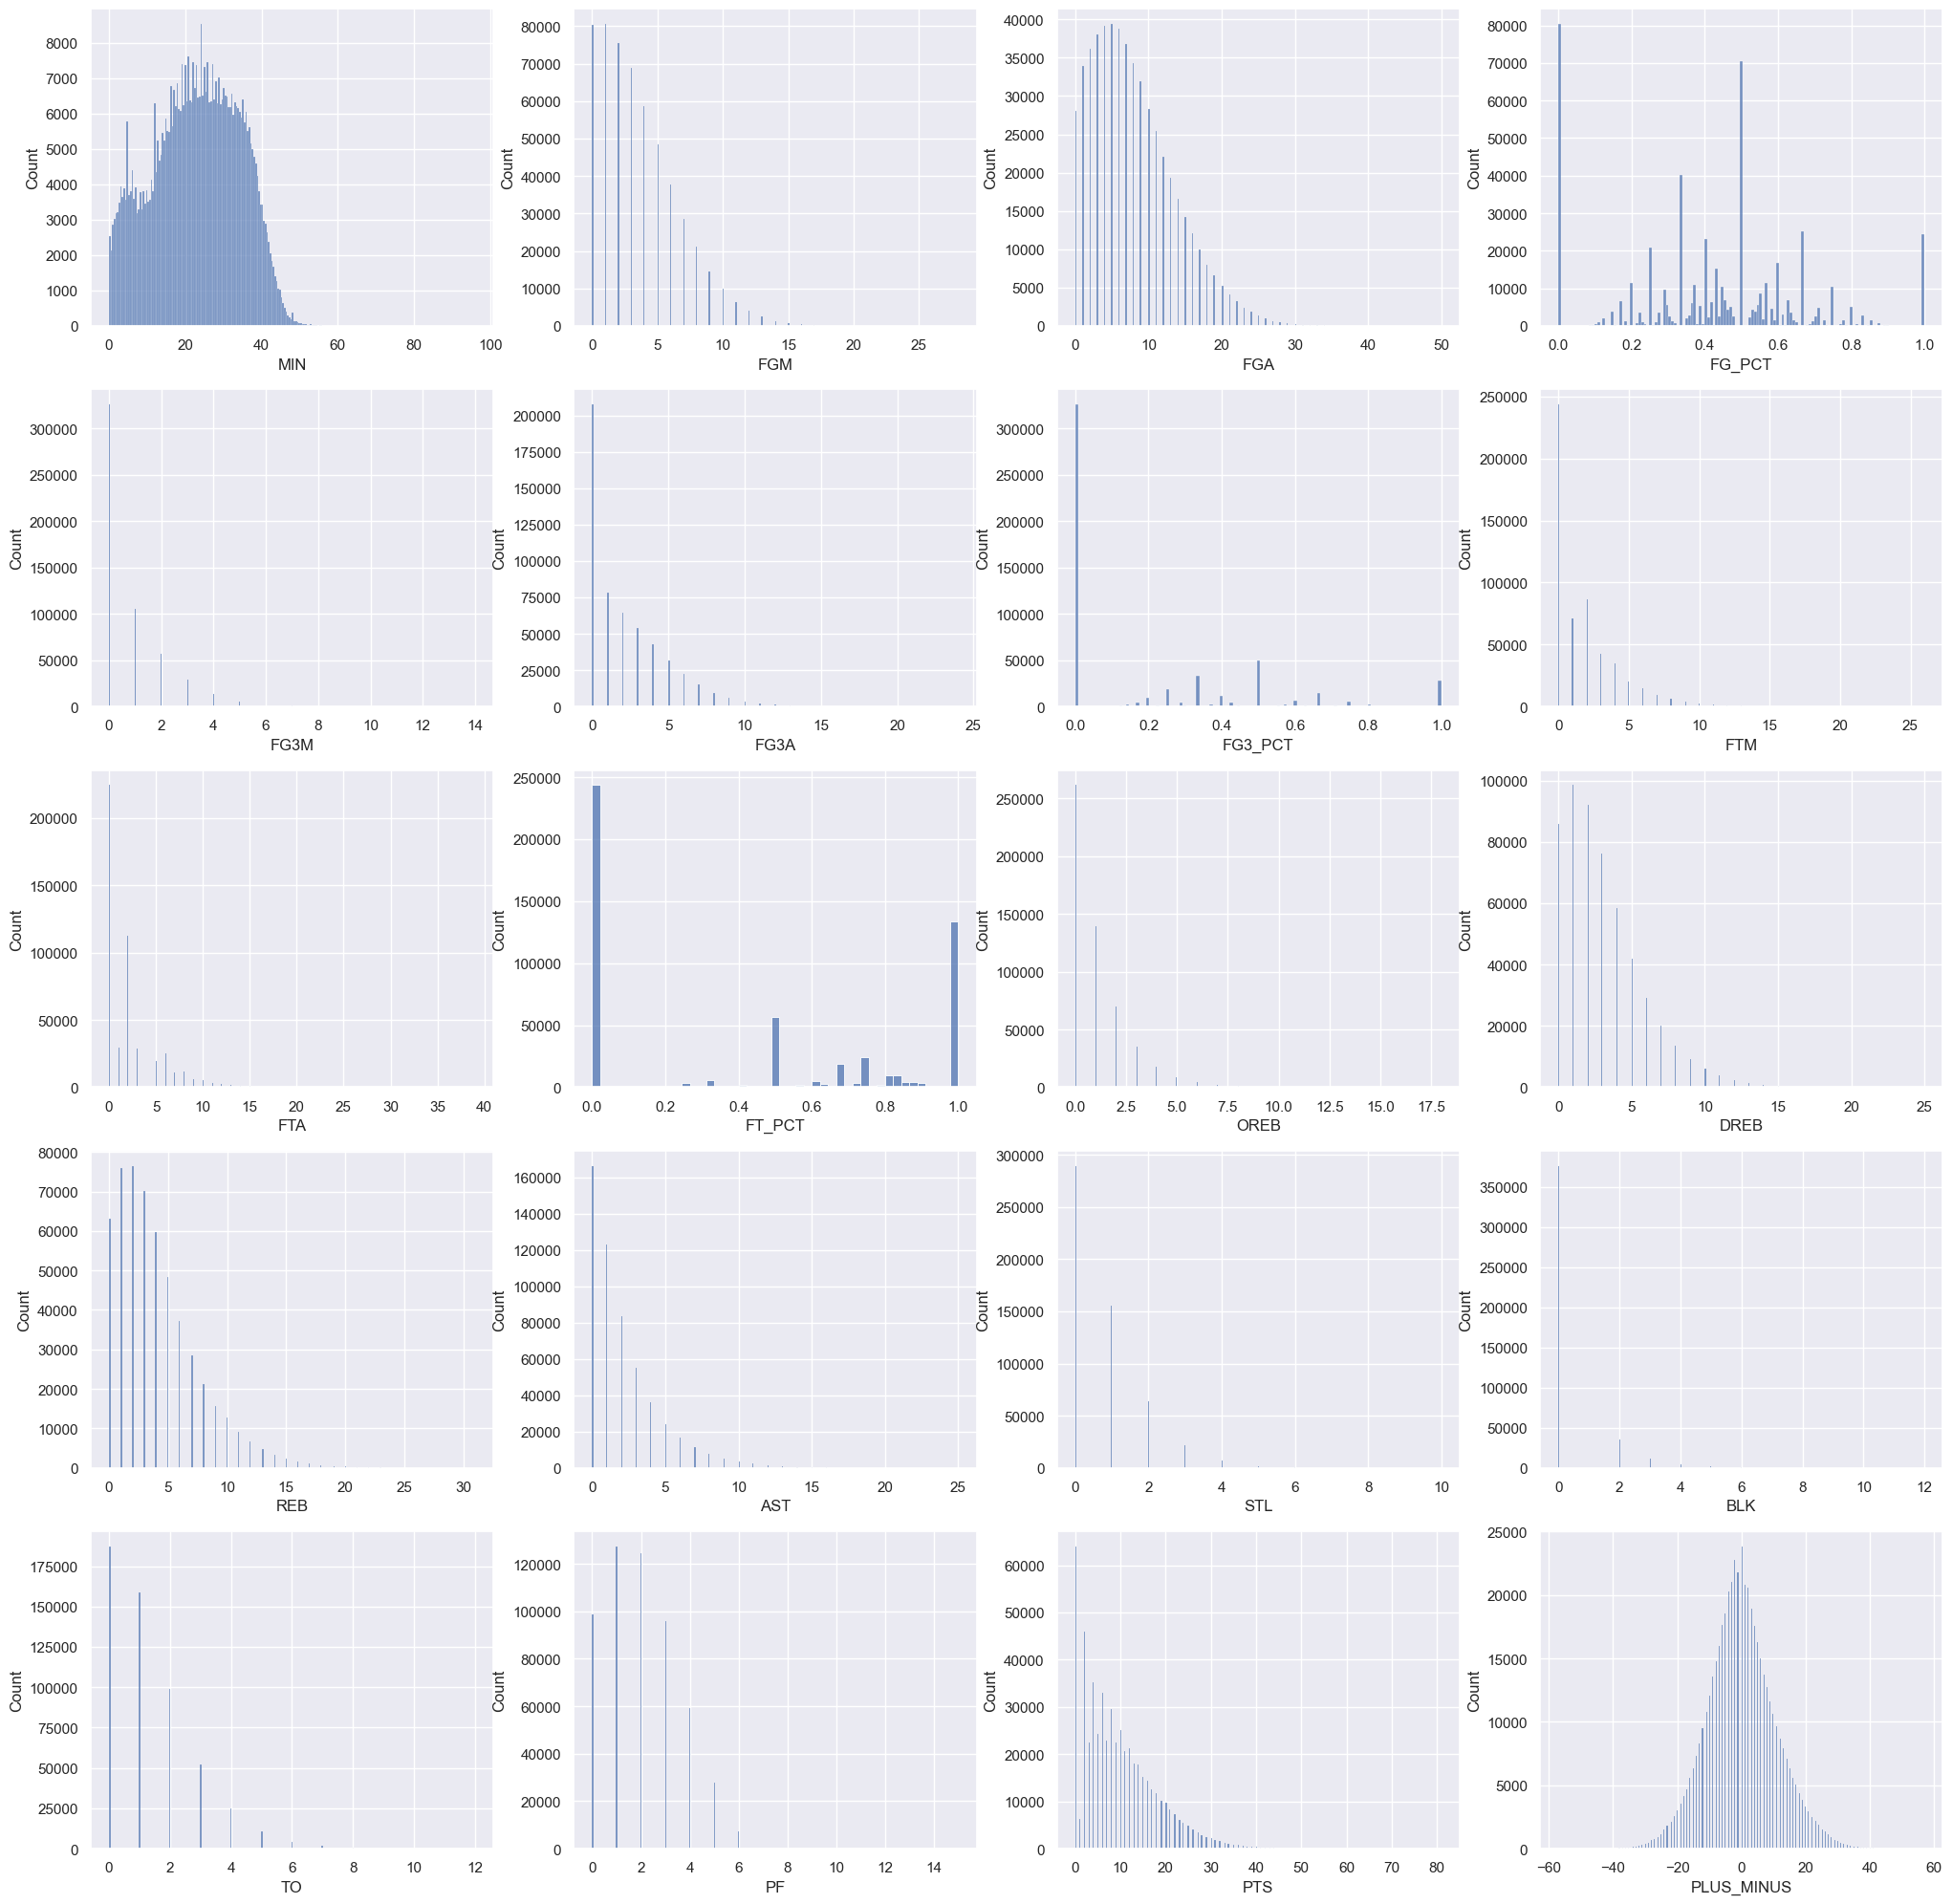

In [130]:
value_list = details.select_dtypes(include=['float']).columns.to_list()

df = details[details['MIN'].notna()]

sns.set(rc={'figure.figsize':(25,25)})
for i, column in enumerate(value_list, 1):
    plt.subplot(5,4,i)
    ax=sns.histplot(x=column, data=df, stat='count')

### check outliers 

**96 minutes in one game**

In [131]:
#list games where players played more than 60 minutes
df.loc[df['MIN'] > 60]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
102161,20800575,1610612744,GSW,Golden State,2037,Jamal Crawford,NaN,G,NaN,60.100000,13.0,31.0,0.419,1.0,5.0,0.200,8.0,10.0,0.800,1.0,3.0,4.0,4.0,0.0,1.0,3.0,0.0,35.0,1.0
184185,10600102,1610612744,GSW,Golden State,101194,Anthony Roberson,NaN,NaN,NaN,78.000000,8.0,16.0,0.500,3.0,7.0,0.429,1.0,2.0,0.500,0.0,3.0,3.0,1.0,2.0,0.0,1.0,1.0,20.0,NaN
184189,10600102,1610612744,GSW,Golden State,2693,Keith McLeod,NaN,NaN,NaN,86.000000,1.0,3.0,0.333,0.0,0.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,2.0,4.0,0.0,4.0,4.0,2.0,NaN
184190,10600102,1610612744,GSW,Golden State,2440,Matt Barnes,NaN,NaN,NaN,96.000000,5.0,8.0,0.625,0.0,0.0,0.000,0.0,0.0,0.000,2.0,5.0,7.0,1.0,1.0,1.0,1.0,4.0,10.0,NaN
185963,10600027,1610612766,CHA,Charlotte,101207,Kevin Burleson,NaN,NaN,NaN,62.000000,0.0,3.0,0.000,0.0,2.0,0.000,4.0,4.0,1.000,0.0,0.0,0.0,1.0,1.0,0.0,2.0,5.0,4.0,NaN
185964,10600027,1610612766,CHA,Charlotte,2679,Matt Carroll,NaN,NaN,NaN,93.000000,5.0,8.0,0.625,1.0,3.0,0.333,2.0,2.0,1.000,0.0,2.0,2.0,1.0,0.0,0.0,1.0,4.0,13.0,NaN
185965,10600027,1610612766,CHA,Charlotte,2056,Primoz Brezec,NaN,NaN,NaN,92.000000,0.0,3.0,0.000,0.0,0.0,0.000,6.0,8.0,0.750,1.0,1.0,2.0,1.0,1.0,1.0,0.0,2.0,6.0,NaN
185966,10600027,1610612766,CHA,Charlotte,101109,Raymond Felton,NaN,NaN,NaN,79.000000,5.0,11.0,0.455,3.0,3.0,1.000,7.0,8.0,0.875,2.0,4.0,6.0,5.0,2.0,1.0,5.0,1.0,20.0,NaN
185967,10600027,1610612766,CHA,Charlotte,200797,Ryan Hollins,NaN,NaN,NaN,84.000000,3.0,5.0,0.600,0.0,0.0,0.000,4.0,5.0,0.800,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,10.0,NaN
185969,10600027,1610612766,CHA,Charlotte,200835,Walter Herrmann,NaN,NaN,NaN,72.000000,0.0,3.0,0.000,0.0,3.0,0.000,0.0,0.0,0.000,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


NOTE - Just 19 records, many in the same game, which indicates an extended overtime game

**field goal attempts**

In [132]:
df.loc[df['FGA'] > 40]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
136797,20700553,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,42.200000,21.0,44.0,0.477,2.0,8.0,0.250,4.0,7.0,0.571,0.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,48.0,-3.0
157787,20601081,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,47.566667,19.0,44.0,0.432,3.0,9.0,0.333,12.0,14.0,0.857,1.0,1.0,2.0,2.0,0.0,0.0,3.0,2.0,53.0,1.0
173342,20600431,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,54.466667,22.0,45.0,0.489,4.0,11.0,0.364,10.0,12.0,0.833,0.0,5.0,5.0,4.0,0.0,0.0,4.0,6.0,58.0,5.0
204039,20500591,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,41.933333,28.0,46.0,0.609,7.0,13.0,0.538,18.0,20.0,0.900,2.0,4.0,6.0,2.0,3.0,1.0,3.0,1.0,81.0,25.0
206535,20500480,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,G,NaN,45.350000,17.0,41.0,0.415,7.0,15.0,0.467,9.0,10.0,0.900,3.0,5.0,8.0,8.0,1.0,0.0,3.0,2.0,50.0,9.0
383815,21900179,1610612745,HOU,Houston,201935,James Harden,NaN,G,NaN,38.683333,16.0,41.0,0.390,8.0,22.0,0.364,9.0,11.0,0.818,1.0,5.0,6.0,6.0,0.0,0.0,5.0,4.0,49.0,16.0
427324,41700176,1610612760,OKC,Oklahoma City,201566,Russell Westbrook,NaN,G,NaN,43.800000,18.0,43.0,0.419,7.0,19.0,0.368,3.0,6.0,0.500,1.0,9.0,10.0,5.0,2.0,0.0,5.0,3.0,46.0,-1.0
463651,41600162,1610612760,OKC,Oklahoma City,201566,Russell Westbrook,NaN,G,NaN,41.366667,17.0,43.0,0.395,2.0,11.0,0.182,15.0,18.0,0.833,2.0,8.0,10.0,13.0,4.0,1.0,4.0,3.0,51.0,11.0
495095,21600021,1610612760,OKC,Oklahoma City,201566,Russell Westbrook,NaN,G,NaN,45.316667,17.0,44.0,0.386,2.0,10.0,0.200,15.0,20.0,0.750,3.0,10.0,13.0,10.0,2.0,0.0,5.0,3.0,51.0,7.0
501291,21501228,1610612747,LAL,Los Angeles,977,Kobe Bryant,NaN,F,NaN,42.150000,22.0,50.0,0.440,6.0,21.0,0.286,10.0,12.0,0.833,0.0,4.0,4.0,4.0,1.0,1.0,2.0,1.0,60.0,7.0


NOTE - according to a google search, the 50 FGA by Kobe Bryant is correct

**free throw attempts**

In [133]:
df.loc[df['FTA'] > 30]

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
307929,21100158,1610612753,ORL,Orlando,2730,Dwight Howard,NaN,C,NaN,43.616667,12.0,21.0,0.571,0.0,0.0,0.0,21.0,39.0,0.538,7.0,16.0,23.0,3.0,4.0,2.0,3.0,2.0,45.0,12.0
516239,21500635,1610612765,DET,Detroit,203083,Andre Drummond,NaN,C,NaN,23.216667,2.0,4.0,0.500,0.0,0.0,0.0,13.0,36.0,0.361,5.0,6.0,11.0,2.0,1.0,1.0,2.0,2.0,17.0,10.0
526090,21500261,1610612746,LAC,LA,201599,DeAndre Jordan,NaN,C,NaN,33.016667,3.0,6.0,0.500,0.0,0.0,0.0,12.0,34.0,0.353,9.0,15.0,24.0,1.0,1.0,2.0,0.0,4.0,18.0,21.0
536846,41400234,1610612746,LAC,Los Angeles,201599,DeAndre Jordan,NaN,C,NaN,29.950000,6.0,7.0,0.857,0.0,0.0,0.0,14.0,34.0,0.412,4.0,13.0,17.0,2.0,2.0,1.0,0.0,3.0,26.0,16.0
618984,21200949,1610612747,LAL,Los Angeles,2730,Dwight Howard,NaN,C,NaN,38.400000,7.0,13.0,0.538,0.0,0.0,0.0,25.0,39.0,0.641,3.0,13.0,16.0,2.0,1.0,3.0,0.0,3.0,39.0,16.0


NOTE - according to a google search, the 39 FTA by Dwight Howard are correct